In [1]:
import time
begin=time.time()

In [2]:
prefix = 'bdb_model_runs_final-space-test'
offense = 'MIA'
defense = 'CLE'

In [ ]:
import os
import numpy as np # linear algebra
from numpy.matlib import repmat
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from fuzzywuzzy import fuzz
import datetime
import sklearn

#for image generation
from scipy import stats
from scipy.special import expit
import matplotlib.image as mpimg

import time
from tqdm import tqdm_notebook

import pickle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as kb
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Activation, 
    BatchNormalization, 
    Concatenate,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling2D
)

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import to_categorical

import h5py
import bdb_gameplan_space as bdb
from matplotlib.colors import ListedColormap

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
def ensure_folder_exists(folder):    
    # Check if the folder exists
    if not os.path.exists(folder):
        print(f"Folder '{folder}' does not exist. Creating it.")
        os.makedirs(folder)
    else:
        print(f"Folder '{folder}' already exists.")

In [5]:
prefix_files = os.path.join(prefix, 'files')
prefix_cnn = os.path.join(prefix, 'cnn')
prefix_list = [prefix, prefix_files, prefix_cnn]
for i in prefix_list:
    ensure_folder_exists(i)

Folder 'bdb_model_runs_final-space-test' already exists.
Folder 'bdb_model_runs_final-space-test\files' already exists.
Folder 'bdb_model_runs_final-space-test\cnn' already exists.


In [6]:
#Motion fixed

play_stats = pd.read_csv("nfl-big-data-bowl-2025//plays.csv")
play_stats = play_stats[['gameId', 'playId', 'yardlineSide', 'yardlineNumber', 'quarter', 'gameClock', 'possessionTeam', 'down', 'yardsToGo', 
                         'preSnapHomeScore', 'preSnapVisitorScore', 'yardsGained', 'expectedPointsAdded',  'offenseFormation', 'playDescription', 'rushLocationType', 'pff_runConceptPrimary']]
play_stats = play_stats.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'yardlineSide': 'FieldPosition', 'yardlineNumber': 'YardLine', 
                                          'quarter': 'Quarter', 'gameClock': 'GameClock', 'possessionTeam': 'PossessionTeam', 'down': 'Down', 
                                          'yardsToGo': 'Distance', 'preSnapHomeScore': 'HomeScoreBeforePlay', 
                                          'preSnapVisitorScore': 'VisitorScoreBeforePlay', 
                                          'yardsGained': 'Yards', 'offenseFormation':'OffenseFormation'})
players = pd.read_csv("nfl-big-data-bowl-2025//players.csv")
players = players[['nflId', 'weight', 'position']]
players = players.rename(columns = {'nflId': 'NflId', 'weight': 'PlayerWeight', 'position': 'Position'})
player_play = pd.read_csv("nfl-big-data-bowl-2025//player_play.csv")
player_play = player_play[['gameId', 'playId', 'nflId', 'hadRushAttempt']]
player_play = player_play.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'nflId': 'NflId'})
player_play.loc[(player_play['hadRushAttempt'] == 1), 'NflIdRusher'] = player_play['NflId']
games = pd.read_csv("nfl-big-data-bowl-2025//games.csv")
games = games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']]
games = games.rename(columns = {'gameId': 'GameId', 'homeTeamAbbr': 'HomeTeamAbbr', 'visitorTeamAbbr': 'VisitorTeamAbbr'})
location_data = pd.DataFrame()
for i in range(1, 10):
    pl = pd.read_csv('nfl-big-data-bowl-2025//tracking_week_' + str(i) + '.csv')
    pl['pid'] = pl['gameId'].astype(str) + pl['playId'].astype(str).str.zfill(4)
    pl['pid'] = pl['playId'].astype('int64')
    pl = pl.loc[(pl['event'] == 'handoff') | (pl['event'] == 'run')].reset_index(drop=True)
    pl = pl[['gameId', 'playId', 'club', 'x', 'y', 's', 'a', 'dis', 'dir', 'nflId', 'playDirection', 'event']]
    pl = pl.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'x': 'X', 'y': 'Y', 's': 'S', 'a': 'A', 'dis': 'Dis', 'dir': 'Dir', 'nflId': 'NflId', 'playDirection': 'PlayDirection'})
    location_data = pd.concat([location_data, pl]).reset_index(drop=True)
train_df = pd.merge(location_data, play_stats, how = 'left', on = ['GameId', 'PlayId']).reset_index(drop=True)
train_df = pd.merge(train_df, players, how = 'left', on = ['NflId']).reset_index(drop=True)
train_df = pd.merge(train_df, player_play, how = 'inner', on = ['GameId', 'PlayId', 'NflId']).reset_index(drop=True)
train_df = pd.merge(train_df, games, how = 'left', on = ['GameId']).reset_index(drop=True)
train_df = train_df.rename(columns = {'club': 'Team'})
train_df['PlayId'] = train_df['GameId'].astype(str) + train_df['PlayId'].astype(str).str.zfill(4)
train_df['PlayId'] = train_df['PlayId'].astype('int64')
train_df.loc[(train_df['PossessionTeam'] == train_df['HomeTeamAbbr']), 'DefensiveTeam'] = train_df['VisitorTeamAbbr']
train_df.loc[(train_df['PossessionTeam'] != train_df['HomeTeamAbbr']), 'DefensiveTeam'] = train_df['HomeTeamAbbr']
#Filter for Runs
#train_df = train_df.loc[(train_df['rushLocationType'].isna() == False) & (train_df['rushLocationType'] != 'UNKNOWN')].reset_index(drop=True)
football_location = location_data.loc[(location_data['club'] == 'football')].reset_index(drop=True)
football_dict = {'GameId':[], 'PlayId':[], 'X':[], 'Y':[], 'PlayDirection':[]}
for idx, i in enumerate(football_location['PlayId']):
    football_dict['GameId'].append(football_location['GameId'].iloc[idx])
    football_dict['PlayId'].append(i)
    football_dict['X'].append(football_location['X'].iloc[idx])
    football_dict['Y'].append(football_location['Y'].iloc[idx])
    football_dict['PlayDirection'].append(football_location['PlayDirection'].iloc[idx])
football_df = pd.DataFrame(football_dict)
football_df = bdb.clean_football_df(football_df)
football_df['PlayId'] = football_df['GameId'].astype(str) + football_df['PlayId'].astype(str).str.zfill(4)
football_df['PlayId'] = football_df['PlayId'].astype('int64')
train_df = train_df.loc[(train_df['Team'] != 'football')].reset_index(drop=True)

In [7]:
cleandf = bdb.clean_df(train_df)
#Fix cleandf
play_list = cleandf.loc[(cleandf['NflIdRusher'].isna() == False)]['PlayId']
for idx, i in enumerate(play_list):
    nflrusherid = cleandf.loc[(cleandf['PlayId'] == i) & (cleandf['NflIdRusher'].isna() == False)]['NflIdRusher'].iloc[0]
    cleandf.loc[(cleandf['PlayId'] == i), 'NflIdRusher'] = nflrusherid
cleandf.loc[cleandf['NflId'] == cleandf['NflIdRusher'], 'BallCarrier'] = 1
cleandf.loc[cleandf['NflId'] != cleandf['NflIdRusher'], 'BallCarrier'] = 0
cleandf['ScoreDiff'] = cleandf.apply(bdb.get_score_diff, axis=1)
cleandf['GameClock'] = ((cleandf['GameClock'].str.split(':').str[0]).astype(int) * 3600 + cleandf['GameClock'].str.split(':').str[1].astype(int)) / 3600 / 15
#Base Downs = (1st & 2nd Down, Ball between -10 & +25, Outside of 2 Minute Drill)
cleandf = cleandf.loc[(cleandf['Down'] < 3)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['YardsFromOwnGoal'] >= 10)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['YardsFromOwnGoal'] < 75)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['GameClock'] > (120/900)) | (cleandf['Quarter'].isin([1, 3]))].reset_index(drop=True)
play_list = list(cleandf.loc[(cleandf['NflIdRusher'] != 0)]['PlayId'])
qb_list = list(cleandf.loc[(cleandf['NflIdRusher'] != 0)]['NflIdRusher'])
for idx, i in enumerate(play_list):
    cleandf.loc[(cleandf['NflIdRusher'] == 0) & (cleandf['PlayId'] == i), 'NflIdRusher'] = qb_list[idx]
cleandf['DefendersInTheBox'] = 0
cleandf['StadiumType'] = 0
cleandf['Turf'] = 0
cleandf = cleandf.reset_index(drop=True)
#cleandf = cleandf.rename(columns = {'NflIdRusher':'NflIdPasser'})
cleandf = cleandf[['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Dir', 'NflId', 'Position',
       'YardLine', 'Quarter', 'GameClock', 'PossessionTeam', 'DefensiveTeam', 'Down',
       'Distance', 'FieldPosition', 'HomeScoreBeforePlay',
       'VisitorScoreBeforePlay', 'NflIdRusher', 'OffenseFormation',
       'PlayDirection', 'Yards', 'expectedPointsAdded', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'ToLeft',
       'BallCarrier', 'TeamOnOffense', 'IsOnOffense', 'YardsFromOwnGoal',
       'ScoreDiff', 'rushLocationType', 'pff_runConceptPrimary']]
#All Plays go to Right and are flipped to have the ball on the left hash. Therefore, Forms with similar personnel and placement but 
#flipped between field and boundary are considered different formations for clustering purposes
for idx, i in enumerate(cleandf['PlayId']):
    football_x = football_df.loc[(football_df['PlayId'] == i)]['X'].iloc[0]
    football_y = football_df.loc[(football_df['PlayId'] == i)]['Y'].iloc[0]
    player_x = cleandf['X'].iloc[idx] - football_x + 60
    cleandf.at[idx, 'X'] = player_x
    if (football_y > (53.33/2)):
        player_y = 53.33 - cleandf['Y'].iloc[idx]
        new_football_y = 53.33 - football_y
    else:
        player_y = cleandf['Y'].iloc[idx]
        new_football_y = football_y
    if new_football_y > 23.42:
        y_diff = new_football_y - 23.42
        player_y-=y_diff
    elif new_football_y < 23.42:
        y_diff = 23.42 - new_football_y
        player_y+=y_diff
    cleandf.at[idx, 'Y'] = player_y
#Everyone stays to be evaluated
cleandf = cleandf.loc[(cleandf['rushLocationType'].isna() == False) & (cleandf['rushLocationType'] != 'UNKNOWN')].reset_index(drop=True)

In [8]:
space_dict = bdb.generateSpaces(cleandf,200,100,1)

  0%|          | 0/4137 [00:00<?, ?it/s]

In [9]:
for idx, i in enumerate(cleandf['PlayId']):
    NflId = cleandf['NflId'].iloc[idx]
    rho = space_dict[i][NflId].sum()
    cleandf.at[idx, 'Space'] = rho
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [10]:
player_space = cleandf.groupby(['NflId', 'Position']).agg({'Space':'sum', 'PlayId':'count'}).reset_index()
player_space = player_space.rename(columns = {'Space':'Space_total', 'PlayId':'Plays_total'})
player_space['Space_average'] = player_space['Space_total'] / player_space['Plays_total']
player_space.loc[(player_space['NflId'] == 46162), 'Position'] = 'SS'
player_space.loc[(player_space['NflId'] == 46199), 'Position'] = 'DE'
cleandf.loc[(cleandf['NflId'] == 46162), 'Position'] = 'SS'
cleandf.loc[(cleandf['NflId'] == 46199), 'Position'] = 'DE'
for idx, i in enumerate(player_space['Plays_total']):
    if i < 50:
        position_adj = np.percentile(player_space.loc[(player_space['Position'] == player_space['Position'].iloc[idx]) & (player_space['Plays_total'] > 50)]['Space_average'], 10)
        player_space.at[idx, 'Space Adj'] = ((i*player_space['Space_average'].iloc[idx]) + ((50-i)*position_adj)) / 50
    else:
        player_space.at[idx, 'Space Adj'] = player_space['Space_average'].iloc[idx]
for idx, i in enumerate(player_space['Plays_total']):
    position_max = player_space.loc[(player_space['Position'] == player_space['Position'].iloc[idx])]['Space Adj'].max()
    player_space.at[idx, 'Space Factor'] = player_space['Space Adj'].iloc[idx] / position_max

In [11]:
del cleandf

In [12]:
play_stats = pd.read_csv("nfl-big-data-bowl-2025//plays.csv")
play_stats = play_stats[['gameId', 'playId', 'yardlineSide', 'yardlineNumber', 'quarter', 'gameClock', 'possessionTeam', 'down', 'yardsToGo', 
                         'preSnapHomeScore', 'preSnapVisitorScore', 'yardsGained', 'expectedPointsAdded',  'offenseFormation', 'playDescription', 'rushLocationType', 'pff_runConceptPrimary']]
play_stats = play_stats.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'yardlineSide': 'FieldPosition', 'yardlineNumber': 'YardLine', 
                                          'quarter': 'Quarter', 'gameClock': 'GameClock', 'possessionTeam': 'PossessionTeam', 'down': 'Down', 
                                          'yardsToGo': 'Distance', 'preSnapHomeScore': 'HomeScoreBeforePlay', 
                                          'preSnapVisitorScore': 'VisitorScoreBeforePlay', 
                                          'yardsGained': 'Yards', 'offenseFormation':'OffenseFormation'})
players = pd.read_csv("nfl-big-data-bowl-2025//players.csv")
players = players[['nflId', 'weight', 'position']]
players = players.rename(columns = {'nflId': 'NflId', 'weight': 'PlayerWeight', 'position': 'Position'})
player_play = pd.read_csv("nfl-big-data-bowl-2025//player_play.csv")
player_play = player_play[['gameId', 'playId', 'nflId', 'hadRushAttempt']]
player_play = player_play.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'nflId': 'NflId'})
player_play.loc[(player_play['hadRushAttempt'] == 1), 'NflIdRusher'] = player_play['NflId']
games = pd.read_csv("nfl-big-data-bowl-2025//games.csv")
games = games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']]
games = games.rename(columns = {'gameId': 'GameId', 'homeTeamAbbr': 'HomeTeamAbbr', 'visitorTeamAbbr': 'VisitorTeamAbbr'})
location_data = pd.DataFrame()
for i in range(1, 10):
    pl = pd.read_csv('nfl-big-data-bowl-2025//tracking_week_' + str(i) + '.csv')
    pl['pid'] = pl['gameId'].astype(str) + pl['playId'].astype(str).str.zfill(4)
    pl['pid'] = pl['playId'].astype('int64')
    pl = pl.loc[(pl['frameType'] == 'SNAP')].reset_index(drop=True)
    pl = pl[['gameId', 'playId', 'club', 'x', 'y', 's', 'a', 'dis', 'dir', 'nflId', 'playDirection', 'event']]
    pl = pl.rename(columns = {'gameId': 'GameId', 'playId': 'PlayId', 'x': 'X', 'y': 'Y', 's': 'S', 'a': 'A', 'dis': 'Dis', 'dir': 'Dir', 'nflId': 'NflId', 'playDirection': 'PlayDirection'})
    location_data = pd.concat([location_data, pl]).reset_index(drop=True)
train_df = pd.merge(location_data, play_stats, how = 'left', on = ['GameId', 'PlayId']).reset_index(drop=True)
train_df = pd.merge(train_df, players, how = 'left', on = ['NflId']).reset_index(drop=True)
train_df = pd.merge(train_df, player_play, how = 'inner', on = ['GameId', 'PlayId', 'NflId']).reset_index(drop=True)
train_df = pd.merge(train_df, games, how = 'left', on = ['GameId']).reset_index(drop=True)
train_df = train_df.rename(columns = {'club': 'Team'})
train_df['PlayId'] = train_df['GameId'].astype(str) + train_df['PlayId'].astype(str).str.zfill(4)
train_df['PlayId'] = train_df['PlayId'].astype('int64')
train_df.loc[(train_df['PossessionTeam'] == train_df['HomeTeamAbbr']), 'DefensiveTeam'] = train_df['VisitorTeamAbbr']
train_df.loc[(train_df['PossessionTeam'] != train_df['HomeTeamAbbr']), 'DefensiveTeam'] = train_df['HomeTeamAbbr']
#Filter for Runs
#train_df = train_df.loc[(train_df['rushLocationType'].isna() == False) & (train_df['rushLocationType'] != 'UNKNOWN')].reset_index(drop=True)
football_location = location_data.loc[(location_data['club'] == 'football')].reset_index(drop=True)
football_dict = {'GameId':[], 'PlayId':[], 'X':[], 'Y':[], 'PlayDirection':[]}
for idx, i in enumerate(football_location['PlayId']):
    football_dict['GameId'].append(football_location['GameId'].iloc[idx])
    football_dict['PlayId'].append(i)
    football_dict['X'].append(football_location['X'].iloc[idx])
    football_dict['Y'].append(football_location['Y'].iloc[idx])
    football_dict['PlayDirection'].append(football_location['PlayDirection'].iloc[idx])
football_df = pd.DataFrame(football_dict)
football_df = bdb.clean_football_df(football_df)
football_df['PlayId'] = football_df['GameId'].astype(str) + football_df['PlayId'].astype(str).str.zfill(4)
football_df['PlayId'] = football_df['PlayId'].astype('int64')
train_df = train_df.loc[(train_df['Team'] != 'football')].reset_index(drop=True)

In [13]:
cleandf = bdb.clean_df(train_df)
#Fix cleandf
play_list = cleandf.loc[(cleandf['NflIdRusher'].isna() == False)]['PlayId']
for idx, i in enumerate(play_list):
    nflrusherid = cleandf.loc[(cleandf['PlayId'] == i) & (cleandf['NflIdRusher'].isna() == False)]['NflIdRusher'].iloc[0]
    cleandf.loc[(cleandf['PlayId'] == i), 'NflIdRusher'] = nflrusherid
cleandf.loc[cleandf['NflId'] == cleandf['NflIdRusher'], 'BallCarrier'] = 1
cleandf.loc[cleandf['NflId'] != cleandf['NflIdRusher'], 'BallCarrier'] = 0
cleandf['ScoreDiff'] = cleandf.apply(bdb.get_score_diff, axis=1)
cleandf['GameClock'] = ((cleandf['GameClock'].str.split(':').str[0]).astype(int) * 3600 + cleandf['GameClock'].str.split(':').str[1].astype(int)) / 3600 / 15
#Base Downs = (1st & 2nd Down, Ball between -10 & +25, Outside of 2 Minute Drill)
cleandf = cleandf.loc[(cleandf['Down'] < 3)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['YardsFromOwnGoal'] >= 10)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['YardsFromOwnGoal'] < 75)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['GameClock'] > (120/900)) | (cleandf['Quarter'].isin([1, 3]))].reset_index(drop=True)
play_list = list(cleandf.loc[(cleandf['NflIdRusher'] != 0)]['PlayId'])
qb_list = list(cleandf.loc[(cleandf['NflIdRusher'] != 0)]['NflIdRusher'])
for idx, i in enumerate(play_list):
    cleandf.loc[(cleandf['NflIdRusher'] == 0) & (cleandf['PlayId'] == i), 'NflIdRusher'] = qb_list[idx]
cleandf['DefendersInTheBox'] = 0
cleandf['StadiumType'] = 0
cleandf['Turf'] = 0
cleandf = cleandf.reset_index(drop=True)
#cleandf = cleandf.rename(columns = {'NflIdRusher':'NflIdPasser'})
cleandf = cleandf[['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Dir', 'NflId', 'Position',
       'YardLine', 'Quarter', 'GameClock', 'PossessionTeam', 'DefensiveTeam', 'Down',
       'Distance', 'FieldPosition', 'HomeScoreBeforePlay',
       'VisitorScoreBeforePlay', 'NflIdRusher', 'OffenseFormation',
       'PlayDirection', 'Yards', 'expectedPointsAdded', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'ToLeft',
       'BallCarrier', 'TeamOnOffense', 'IsOnOffense', 'YardsFromOwnGoal',
       'ScoreDiff', 'rushLocationType', 'pff_runConceptPrimary']]
#All Plays go to Right and are flipped to have the ball on the left hash. Therefore, Forms with similar personnel and placement but 
#flipped between field and boundary are considered different formations for clustering purposes
for idx, i in enumerate(cleandf['PlayId']):
    football_x = football_df.loc[(football_df['PlayId'] == i)]['X'].iloc[0]
    football_y = football_df.loc[(football_df['PlayId'] == i)]['Y'].iloc[0]
    player_x = cleandf['X'].iloc[idx] - football_x + 60
    cleandf.at[idx, 'X'] = player_x
    if (football_y > (53.33/2)):
        player_y = 53.33 - cleandf['Y'].iloc[idx]
        new_football_y = 53.33 - football_y
    else:
        player_y = cleandf['Y'].iloc[idx]
        new_football_y = football_y
    if new_football_y > 23.42:
        y_diff = new_football_y - 23.42
        player_y-=y_diff
    elif new_football_y < 23.42:
        y_diff = 23.42 - new_football_y
        player_y+=y_diff
    cleandf.at[idx, 'Y'] = player_y
#Runs filtered out of cleandf for better data to train neural network.
#Runs stay in off_form_df and def_form_df to get wider range of formations to test.
#(off_form_df+def_form_df) and cleandf follow the same cleaning procedures for simplicity and organization, but serve different purposes.
off_form_df = cleandf.loc[(cleandf['PossessionTeam'] == offense)].reset_index(drop=True)
def_form_df = cleandf.loc[(cleandf['DefensiveTeam'] == defense)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['PossessionTeam'] != offense)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['DefensiveTeam'] != defense)].reset_index(drop=True)
cleandf = cleandf.loc[(cleandf['rushLocationType'].isna() == False) & (cleandf['rushLocationType'] != 'UNKNOWN')].reset_index(drop=True)

In [14]:
def one_hot_enc(df2, var):
    one_hot = pd.get_dummies(df2[var])
    df2 = (df2
              .drop(var, axis=1)
              .join(one_hot)
         )
    return df2

In [15]:
## game state information for each row

plays = cleandf.groupby('PlayId').first().drop(columns=['Team', 'X', 'Y', 'Dir', 'NflId', 'PossessionTeam',
                                                        'ToLeft', 'IsOnOffense', 'BallCarrier', 'HomeTeamAbbr',
                                                       'VisitorTeamAbbr', 'PlayDirection', 'YardLine', 
                                                       'A', 'S', 'FieldPosition',
                                                       'Dis', 'GameId', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay'])
# one-hot categoricals
plays = one_hot_enc(plays, 'OffenseFormation')
di = {"outdoor":1, "indoor":0, "artificial":1, "natural":0, "home":1, "away":0}
plays = plays.replace({'StadiumType':di, 'Turf':di, 'TeamOnOffense':di})
di = {1:"D1", 2:"D2", 3:"D3", 4:"D4"}
plays = plays.replace({'Down':di})
plays = one_hot_enc(plays, 'Down')
di = {1:"Q1", 2:"Q2", 3:"Q3", 4:"Q4", 5:"OT"}
plays = plays.replace({'Quarter':di})
plays = one_hot_enc(plays, 'Quarter')

# add play id back to groupby dataframe
pids = plays.index.tolist()
plays['PlayId'] = pids

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_27352\3665325619.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plays = plays.replace({'StadiumType':di, 'Turf':di, 'TeamOnOffense':di})


In [16]:
### Define functions that generate spatial control fields for each play in input dataframe
def generateImages(df,nx,ny,alpha):
    plays = df.groupby('PlayId')
    nPlays = plays.ngroups
    playDict = {}
    
    xg = np.linspace(0,100,nx)
    yg = np.linspace(0,53.3,ny)
    x, y = np.meshgrid(xg,yg)
    grid = np.stack((x, y), axis=-1)
    
    
    for playId, playData in tqdm_notebook(plays):
        playDensities = makeFields(playData,grid)
        playTensor = makeTensor(playDensities,alpha)
        if np.isnan(playTensor).any():
            print(playId)
        playDict[playId] = playTensor
        
    return playDict

def makeTensor(rho,alpha):
    #alpha should be in the range [1e-3, 1e2]
    #dens_list[0] = defense
    #dens_list[1] = offense
    #dens_list[2] = ball carrier
    
    rho_def = rho[0]/np.max(rho[0])*127
    rho_off = rho[1]/np.max(rho[1])*127
    rho_bc = rho[2]/np.max(rho[2])*127
    rho_comp = (expit(alpha*(rho_off-rho_def)))*127
    playTensor = np.stack([rho_def,rho_off,rho_bc,rho_comp], axis = -1)
    playTensor = playTensor.astype('int8')
    #converting to int8 to save memory
    
    return playTensor

def makeFields(df,grid): 
    ny, nx, _ = grid.shape
    rho_def = np.zeros((ny,nx))
    rho_off = np.zeros((ny,nx))
    rho_bc = np.zeros((ny,nx))
    
    
    for _, row in df.iterrows():
        pos = [row['X'],53.3 - row['Y']]
        spe = row['S']
        ori = row['Dir']
        
        if np.isnan(ori):
            ori = 0
            
        rho = dens(pos,spe,ori,grid)
   
        if row['IsOnOffense']:
            rho_off += rho
            if row['BallCarrier']:
                rho_bc += rho
        else:
            rho_def += rho
            
    return [rho_def,rho_off,rho_bc]

def dens(pos,spe,ori,grid):
    #need to convert units on parameters and estimate proper values for football vs. soccer
    roc = 4
    srat = spe**2/13**2
    
    R = np.array([[np.cos(ori),-np.sin(ori)], [np.sin(ori),np.cos(ori)]])
    S2 = np.array([[((roc-roc*srat)/2)**2,0],[0,((roc+roc*srat)/2)**2+1e-8]])
    sigma = np.matmul(np.matmul(R,S2),np.transpose(R))
    mu = (pos[0]+spe*np.cos(ori)*0.5, pos[1]+spe*np.sin(ori)*0.5)
    
    return stats.multivariate_normal.pdf(grid, mean = mu, cov = sigma)

In [17]:
image_dict = generateImages(cleandf,200,100,1)
np.save(prefix + '/image_dict.npy',image_dict)

C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_27352\4238100970.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for playId, playData in tqdm_notebook(plays):


  0%|          | 0/3946 [00:00<?, ?it/s]

In [18]:
def saveToFile(gameStates,yards,playIds,imageDict):
    n = gameStates.shape[0]
    print('Saving files for each play...')
    for ii in tqdm_notebook(range(n)):
        gameState = gameStates[ii,:]
        y = int(yards[ii]) 
        yvec = np.concatenate((np.zeros((1,y+99)),np.ones((1,100-y))), axis = 1)
        
        playId = playIds[ii]
        image = imageDict[playId]
        
        np.save(prefix + '/files/gameState'+str(playId)+'.npy',gameState)
        np.save(prefix + '/files/image'+str(playId)+'.npy',image)
        np.save(prefix + '/files/yardage'+str(playId)+'.npy',yvec)
        
    return 

def splitGS(gs, yard_var):
    n = gs.shape[0]
    yards = gs[:,yard_var]
    pids = gs[:,-1].astype('int64')
    
    gs = np.delete(gs, -1, axis=1)
    gs = np.delete(gs, yard_var, axis=1)
    gs[:,7] = (100-gs[:,7])/100.
        
    gs = gs.astype('float')
    return gs, yards, pids

In [19]:
del plays['Position']
del plays['DefensiveTeam']
del plays['rushLocationType']
del plays['pff_runConceptPrimary']

In [20]:
for idx, i in enumerate(plays.columns):
    if i == 'Yards':
        yard_var = idx
        break

playMat = plays.to_numpy()
playMat = playMat.astype('float')
nanInd = np.argwhere(np.isnan(playMat))
playMat[nanInd[:,0],nanInd[:,1]] = np.zeros((1,1))
gs = playMat

yards = gs[:,yard_var]
pids = gs[:,-1].astype('int64')
    
gs[:,7] = (100-gs[:,7])/100.
        
gs = gs.astype('float')
gsTrain, gsTV = train_test_split(gs,train_size = 0.7)
gsVal, gsTest = train_test_split(gsTV, test_size = 0.5)

yardsTrain = gsTrain[:,yard_var]
pidTrain = gsTrain[:,-1]
gsTrain = np.delete(gsTrain, -1, axis=1)
gsTrain = np.delete(gsTrain, yard_var, axis=1)

yardsTest = gsTest[:,yard_var]
pidTest = gsTest[:,-1]
gsTest = np.delete(gsTest, -1, axis=1)
gsTest = np.delete(gsTest, yard_var, axis=1)

yardsVal = gsVal[:,yard_var]
pidVal = gsVal[:,-1]
gsVal = np.delete(gsVal, -1, axis=1)
gsVal = np.delete(gsVal, yard_var, axis=1)

In [21]:
#imageDict = np.load('cnn_model_rerun/image_dict.npy',allow_pickle='TRUE').item()
gs, y, pids = splitGS(playMat, yard_var)
saveToFile(gs,y,pids,image_dict)

temp = list(pids)
np.save(prefix + '/PlayIds.npy',temp)

Saving files for each play...


C:\Users\patrick.powers\AppData\Local\Temp\ipykernel_27352\3881646398.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ii in tqdm_notebook(range(n)):


  0%|          | 0/3946 [00:00<?, ?it/s]

In [22]:
def create_cnn(height, width, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
            filt = (5,5)
        else:
            filt = (3,3)
        # CONV => RELU => BN => POOL
        
        x = Conv2D(f, filt, padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = BatchNormalization()(x)
    
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    
    
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

#Normal Data (Unaugmented)

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, imageDim=(100,200),
                 nChannels = 4, gsDim = 37, shuffle=True):
        'Initialization'
        self.imageDim = imageDim
        self.gsDim = gsDim
        self.nChannels = nChannels
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        Xim, yardage = self.__data_generation(list_IDs_temp)

        return Xim, yardage

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        Xim = np.empty((self.batch_size, *self.imageDim, self.nChannels))
        Xgs = np.empty((self.batch_size, self.gsDim))
        yardage = np.empty((self.batch_size,199), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            temp = np.load(prefix + '/files/image' + str(int(ID)) + '.npy')
            Xim[i,] = temp.astype('float')/128.
            
            # Store output
            yardage_temp = np.load(prefix + '/files/yardage' + str(int(ID)) + '.npy')
            yardage_temp_adj = []
            pl = 0
            for j in yardage_temp[0]:
                if (j == 1) & (pl == 0):
                    yardage_temp_adj.append(1)
                    pl+=1
                else:
                    yardage_temp_adj.append(0)
            yardage_temp_adj = np.array(yardage_temp_adj)
            yardage[i,] = yardage_temp_adj
            
        return Xim, yardage

In [23]:
batch_size = 64
training_generator = DataGenerator(
    list_IDs = pidTrain, 
    batch_size = batch_size)
validation_generator = DataGenerator(
    list_IDs = pidVal, 
    batch_size = batch_size)
testing_generator = DataGenerator(
    list_IDs = pidTest, 
    batch_size = batch_size)

In [24]:
cnn = create_cnn(100, 200, 4)
x = cnn.output
x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

x = Dense(199, activation="softmax")(x)

model = Model(inputs = cnn.input, 
              outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 200, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 200, 16)   │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 100, 200, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 100, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 100, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 50, 100, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 25, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 19200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 19200)          │        76,800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    19,661,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             

 Total params: 20,001,399 (76.30 MB)

 Trainable params: 19,959,927 (76.14 MB)

 Non-trainable params: 41,472 (162.00 KB)

In [25]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath=prefix + '/cnn/cnnWeights.h5.keras', verbose=1, save_best_only=False)

es = EarlyStopping(monitor='val_loss', 
                   mode='min',
                   restore_best_weights=True, 
                   verbose=1, 
                   patience=11)
es.set_model(model)

lr = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.5,
                       patience=5,
                       verbose=1,
                       mode='min',
                       min_delta=0.00001)

history = model.fit(training_generator,
                   validation_data = validation_generator,
                   epochs = 100,
                   callbacks = [es, lr, checkpointer],
                   verbose = 1)

# Save the model
model.save("yardage_predictor_redo.h5")

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.0098 - loss: 5.9001
Epoch 1: saving model to bdb_model_runs_final-space-test/cnn/cnnWeights.h5.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.0099 - loss: 5.8966 - val_accuracy: 0.0903 - val_loss: 4.9671 - learning_rate: 0.0010
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.0450 - loss: 5.3401
Epoch 2: saving model to bdb_model_runs_final-space-test/cnn/cnnWeights.h5.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 537ms/step - accuracy: 0.0453 - loss: 5.3371 - val_accuracy: 0.1111 - val_loss: 4.5217 - learning_rate: 0.0010
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.0980 - loss: 4.7619
Epoch 3: saving model to bdb_model_runs_final-space-test/cnn/cnnWeights.h5.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 546ms/step - accuracy: 0.0978 - loss: 4.7603 - val_accuracy: 0.0816 - val_loss: 3.9483 - learning_rate: 0.0010
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.0993 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


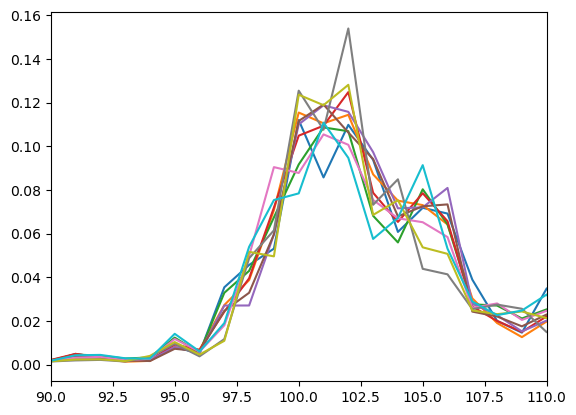

In [26]:
#Epochs = 30
for i in range(0, 10):
    PlayId1 = pidTest[i]
    im1 = np.load(prefix + '/files/image' + str(int(PlayId1)) + '.npy')/128.
    y1 = np.load(prefix + '/files/yardage' + str(int(PlayId1)) + '.npy')
    dist1 = model.predict(im1.reshape((1,100,200,4)))
    plt.plot(dist1.reshape(-1,))
    plt.xlim([90,110])

In [27]:
#Offense Cleaning
total_form_df = pd.concat([off_form_df, def_form_df]).reset_index(drop=True)
play_df = pd.DataFrame()
playlist = list(total_form_df['PlayId'].drop_duplicates())
for idx, i in enumerate(playlist):
    pl = total_form_df.loc[(total_form_df['PlayId'] == i)].reset_index(drop=True)
    pl = pl.loc[(pl['IsOnOffense'] == True)].reset_index(drop=True)
    snap = pd.DataFrame(bdb.offense_locations(pl))
    snap = snap.iloc[5:, :].reset_index(drop=True)
    for jdx, j in enumerate(snap['NflId']):
        if (j in list(pl['NflId'])):
            pl2 = pl.loc[(pl['PlayId'] == i) & (pl['NflId'] == j)].reset_index(drop=True)
            play_df = pd.concat([play_df, pl2]).reset_index(drop=True)

offense_formation_dict = bdb.generateFormationImages(play_df,200,100,1)
np.save(prefix + '/offense_formation_dict.npy',offense_formation_dict)

  0%|          | 0/520 [00:00<?, ?it/s]

17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 20, Silhouette score: 0.2281
Number of clusters: 21, Silhouette score: 0.2311
Number of clusters: 22, Silhouette score: 0.2253
Number of clusters: 23, Silhouette score: 0.2301
Number of clusters: 24, Silhouette score: 0.2294
Number of clusters: 25, Silhouette score: 0.2277
Number of clusters: 26, Silhouette score: 0.2351
Number of clusters: 27, Silhouette score: 0.2365
Number of clusters: 28, Silhouette score: 0.2361


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 29, Silhouette score: 0.2364
Number of clusters: 30, Silhouette score: 0.2349
Number of clusters: 31, Silhouette score: 0.2374
Number of clusters: 32, Silhouette score: 0.2292


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 33, Silhouette score: 0.2361
Number of clusters: 34, Silhouette score: 0.2414
Number of clusters: 35, Silhouette score: 0.2357
Number of clusters: 36, Silhouette score: 0.2373


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 37, Silhouette score: 0.2427
Number of clusters: 38, Silhouette score: 0.2421
Number of clusters: 39, Silhouette score: 0.2370
Number of clusters: 40, Silhouette score: 0.2346


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 41, Silhouette score: 0.2308
Number of clusters: 42, Silhouette score: 0.2343
Number of clusters: 43, Silhouette score: 0.2357
Number of clusters: 44, Silhouette score: 0.2396


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 45, Silhouette score: 0.2388
Number of clusters: 46, Silhouette score: 0.2415
Number of clusters: 47, Silhouette score: 0.2408
Number of clusters: 48, Silhouette score: 0.2367


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

Number of clusters: 49, Silhouette score: 0.2347


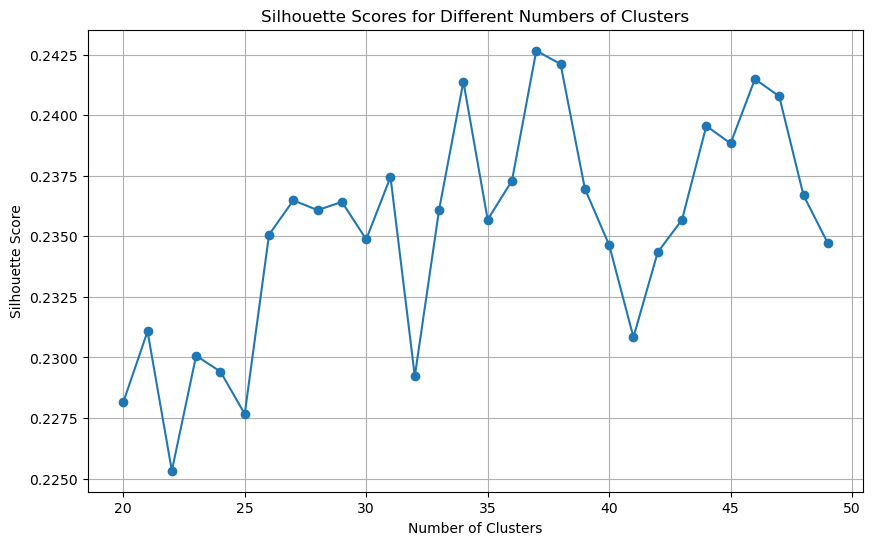

Optimal Number of Clusters: 37


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [28]:
#Finding all offensive formation plays
form_dict = {}
for i in offense_formation_dict.keys():
    if (i in playlist):
        form_dict[i] = offense_formation_dict[i]
images = np.array(list(form_dict.values()))
clustering = bdb.KMeansClusteringWithVGG16(min_clusters=20, max_clusters=50)#len(images)-1)
labels = clustering.fit(images)
league_dict = {'PlayId':[], 'Label':[], 'Team':[]}
for idx, label in enumerate(labels):
    # Assuming you want to store the labels in the same dict
    league_dict['PlayId'].append(list(form_dict.keys())[idx])
    league_dict['Label'].append(label)
    league_dict['Team'].append(play_df.loc[(play_df['PlayId'] == list(form_dict.keys())[idx])]['PossessionTeam'].iloc[0])
leaguedf = pd.DataFrame(league_dict)
leaguedf.loc[(leaguedf['Team'] != offense), 'Team'] = defense

In [29]:
#Finding shared formations between offense and ones defense has faced
ldf = leaguedf.drop_duplicates(subset = ['Label', 'Team'], keep = 'first').reset_index(drop=True)
labels = list(leaguedf.drop_duplicates(subset = 'Label')['Label'])
reciprocated_labels = []
for i in labels:
    if (len(ldf.loc[(ldf['Label'] == i)]) > 1):
        reciprocated_labels.append(i)

In [30]:
for idx, i in enumerate(off_form_df['PlayId']):
    if (str(i) == 'nan'):
        position_adj = np.percentile(player_space.loc[(player_space['Position'] == off_form_df['Position'].iloc[idx]) & (player_space['Plays_total'] > 50)]['Space Factor'], 10)
        off_form_df.at[idx, 'Space Factor'] = position_adj
for idx, i in enumerate(def_form_df['PlayId']):
    if (str(i) == 'nan'):
        position_adj = np.percentile(player_space.loc[(player_space['Position'] == def_form_df['Position'].iloc[idx]) & (player_space['Plays_total'] > 50)]['Space Factor'], 10)
        def_form_df.at[idx, 'Space Factor'] = position_adj

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2742


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


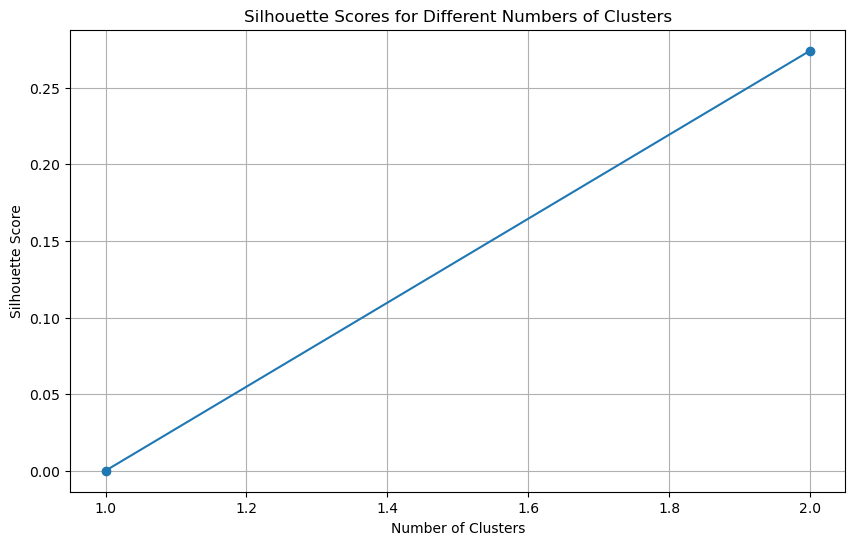

C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Optimal Number of Clusters: 2


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
23


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2283
Number of clusters: 3, Silhouette score: 0.2066
Number of clusters: 4, Silhouette score: 0.2305
Number of clusters: 5, Silhouette score: 0.1333
Number of clusters: 6, Silhouette score: 0.1751
Number of clusters: 7, Silhouette score: 0.2444
Number of clusters: 8, Silhouette score: 0.2072


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

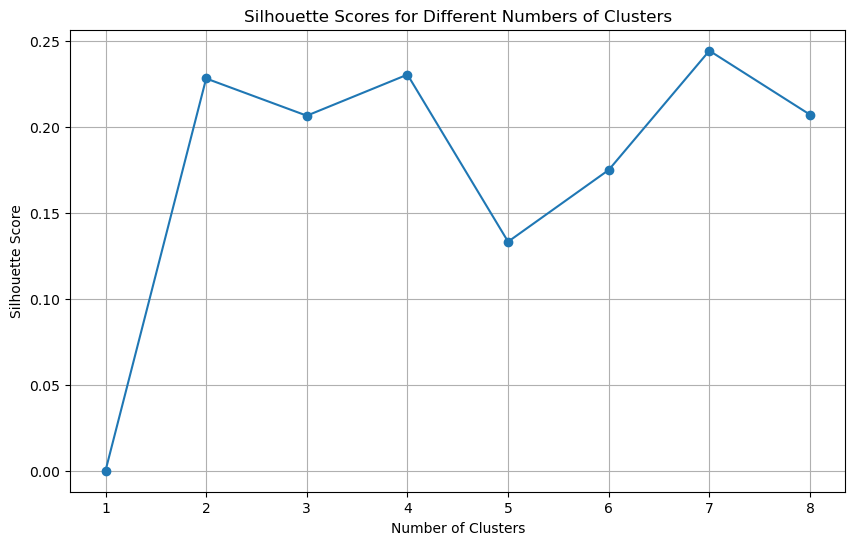

Optimal Number of Clusters: 7


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
35


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.3472
Number of clusters: 3, Silhouette score: 0.3393
Number of clusters: 4, Silhouette score: 0.2702
Number of clusters: 5, Silhouette score: 0.2142
Number of clusters: 6, Silhouette score: 0.1027
Number of clusters: 7, Silhouette score: 0.1050
Number of clusters: 8, Silhouette score: 0.1539
Number of clusters: 9, Silhouette score: 0.1331
Number of clusters: 10, Silhouette score: 0.0984
Number of clusters: 11, Silhouette score: 0.0990


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

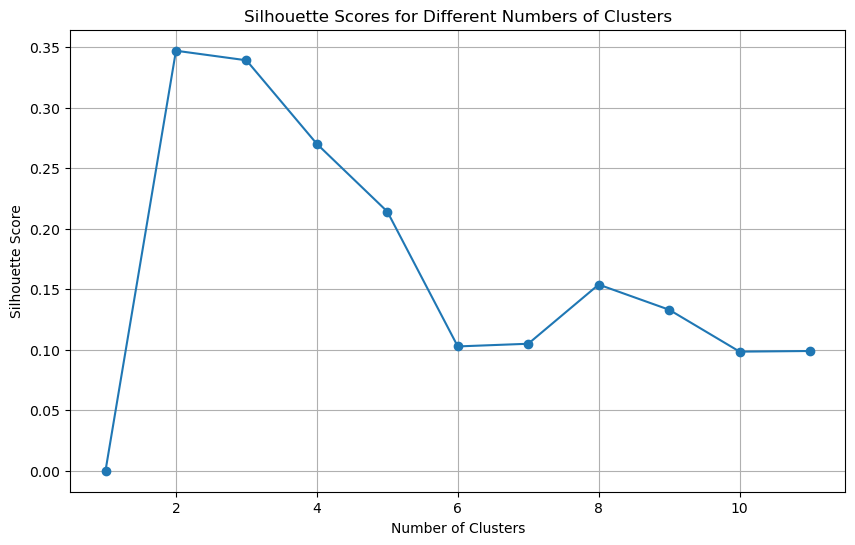

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
25


  0%|          | 0/22 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2691
Number of clusters: 3, Silhouette score: 0.2274
Number of clusters: 4, Silhouette score: 0.2325
Number of clusters: 5, Silhouette score: 0.2933
Number of clusters: 6, Silhouette score: 0.2363
Number of clusters: 7, Silhouette score: 0.2819
Number of clusters: 8, Silhouette score: 0.2629
Number of clusters: 9, Silhouette score: 0.2323
Number of clusters: 10, Silhouette score: 0.2347
Number of clusters: 11, Silhouette score: 0.2666
Number of clusters: 12, Silhouette score: 0.2598
Number of clusters: 13, Silhouette score: 0.2238
Number of clusters: 14, Silhouette score: 0.2086
Number of clusters: 15, Silhouette score: 0.1511
Number of clusters: 16, Silhouette score: 0.1217
Number of clusters: 17, Silhouette score: 0.0913
Number of clusters: 18, Silhouette score: 0.0883
Number of clusters: 19, Silhouette score: 0.0286
Number of clusters: 20, S

C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

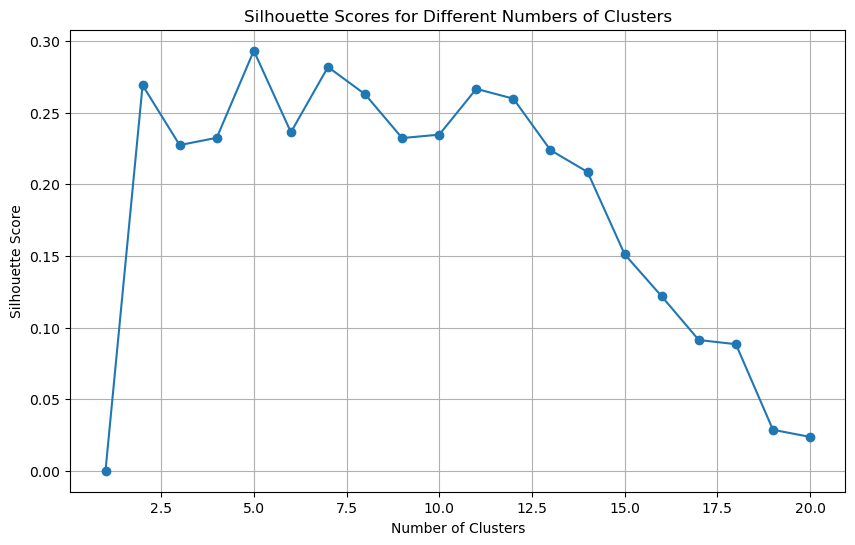

Optimal Number of Clusters: 5


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
20


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2595
Number of clusters: 3, Silhouette score: 0.2089
Number of clusters: 4, Silhouette score: 0.2265
Number of clusters: 5, Silhouette score: 0.2255
Number of clusters: 6, Silhouette score: 0.2055
Number of clusters: 7, Silhouette score: 0.1529
Number of clusters: 8, Silhouette score: 0.1618


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

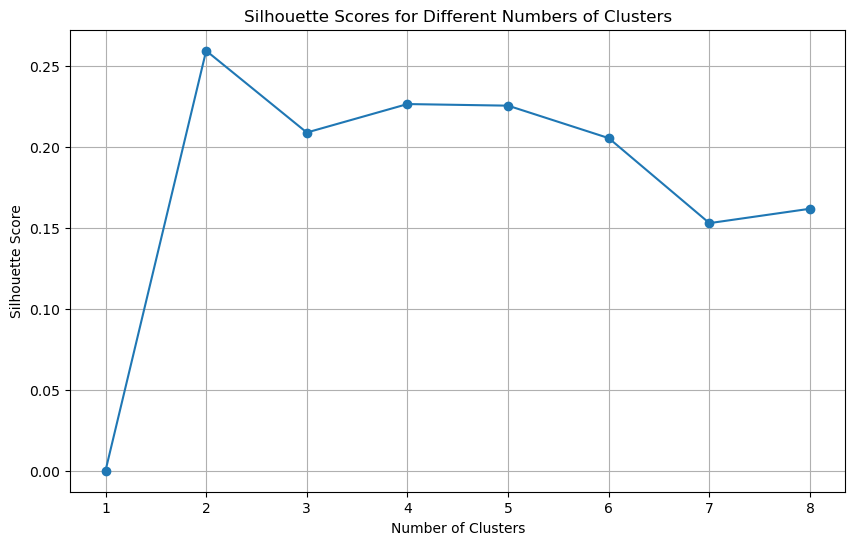

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6


  0%|          | 0/14 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2426
Number of clusters: 3, Silhouette score: 0.2087
Number of clusters: 4, Silhouette score: 0.1791
Number of clusters: 5, Silhouette score: 0.1812
Number of clusters: 6, Silhouette score: 0.1832
Number of clusters: 7, Silhouette score: 0.1845
Number of clusters: 8, Silhouette score: 0.1361
Number of clusters: 9, Silhouette score: 0.1574
Number of clusters: 10, Silhouette score: 0.1401
Number of clusters: 11, Silhouette score: 0.1038
Number of clusters: 12, Silhouette score: 0.0878


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

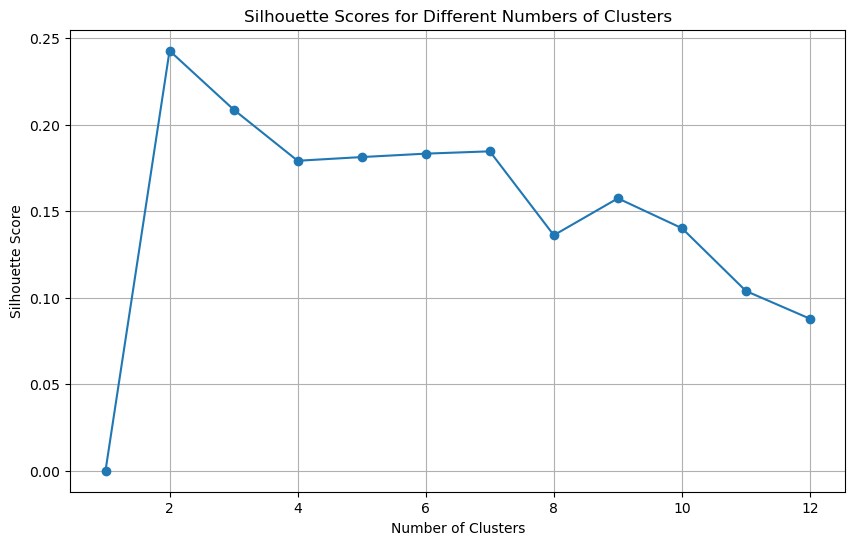

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
18


  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.1549
Number of clusters: 3, Silhouette score: -0.0046


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


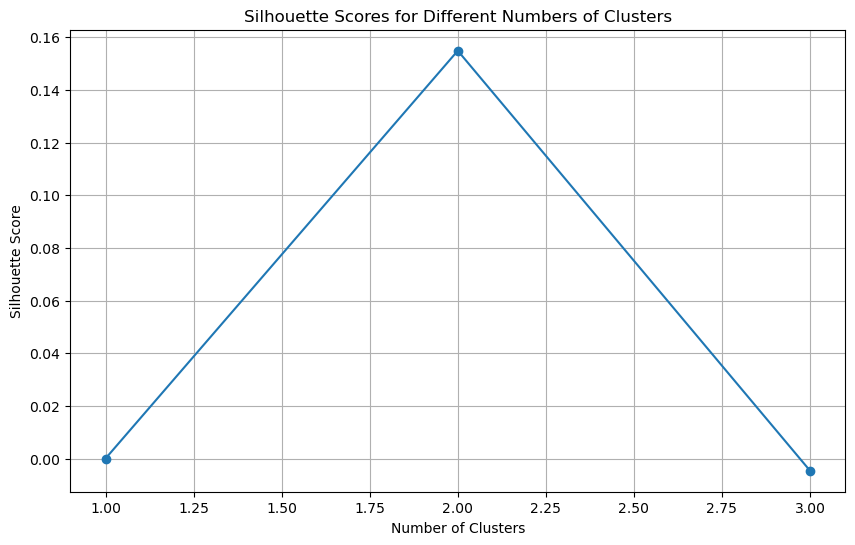

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2417
Number of clusters: 3, Silhouette score: 0.1273
Number of clusters: 4, Silhouette score: 0.2549
Number of clusters: 5, Silhouette score: 0.2889
Number of clusters: 6, Silhouette score: 0.2851
Number of clusters: 7, Silhouette score: 0.2162
Number of clusters: 8, Silhouette score: 0.1602


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

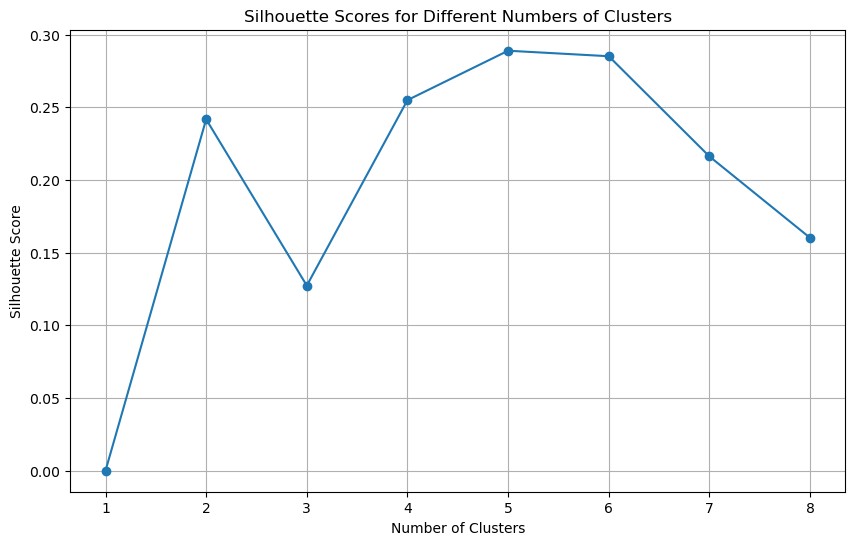

Optimal Number of Clusters: 5


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1


  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2689


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


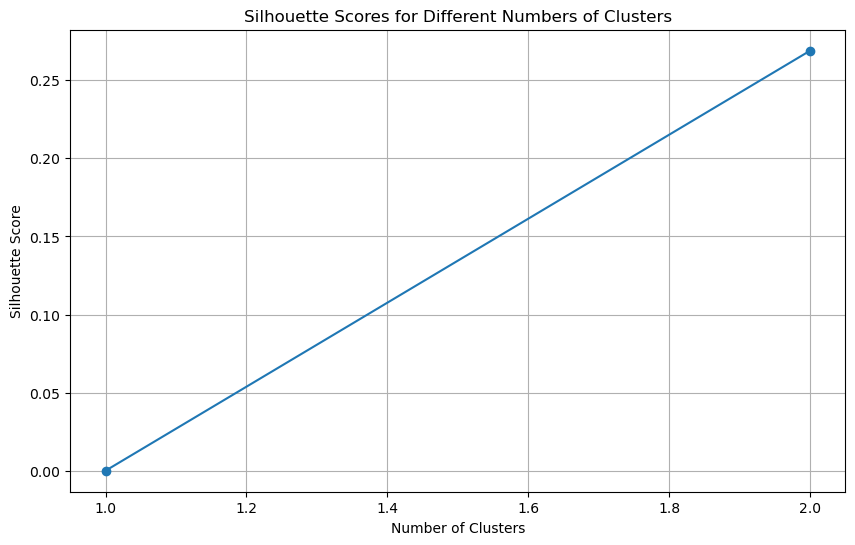

C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Optimal Number of Clusters: 2


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
12


  0%|          | 0/12 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.4617
Number of clusters: 3, Silhouette score: 0.3246
Number of clusters: 4, Silhouette score: 0.4067
Number of clusters: 5, Silhouette score: 0.3639
Number of clusters: 6, Silhouette score: 0.2945
Number of clusters: 7, Silhouette score: 0.3385
Number of clusters: 8, Silhouette score: 0.2957
Number of clusters: 9, Silhouette score: 0.1886
Number of clusters: 10, Silhouette score: 0.1387


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

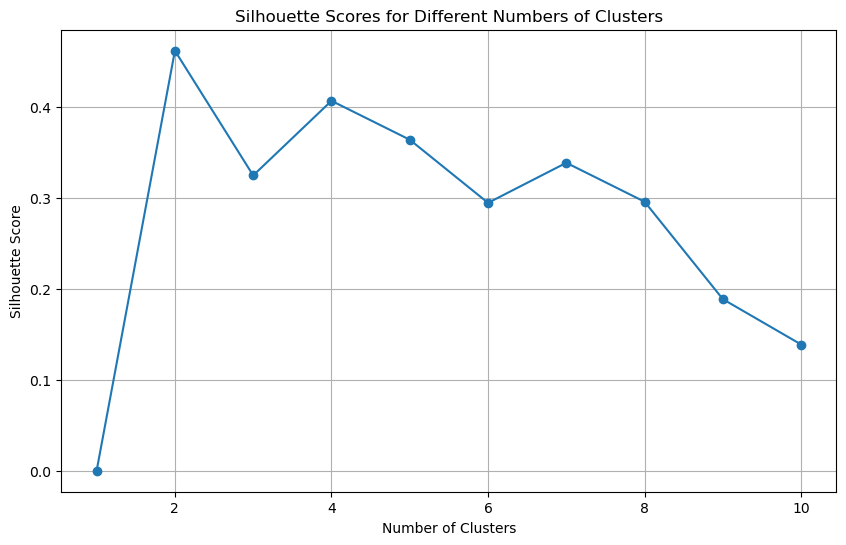

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
22


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
21


  0%|          | 0/14 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2164
Number of clusters: 3, Silhouette score: 0.2359
Number of clusters: 4, Silhouette score: 0.2199
Number of clusters: 5, Silhouette score: 0.2863
Number of clusters: 6, Silhouette score: 0.1382
Number of clusters: 7, Silhouette score: 0.1222
Number of clusters: 8, Silhouette score: 0.2888
Number of clusters: 9, Silhouette score: 0.2232
Number of clusters: 10, Silhouette score: 0.1958
Number of clusters: 11, Silhouette score: 0.2000
Number of clusters: 12, Silhouette score: 0.1566


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

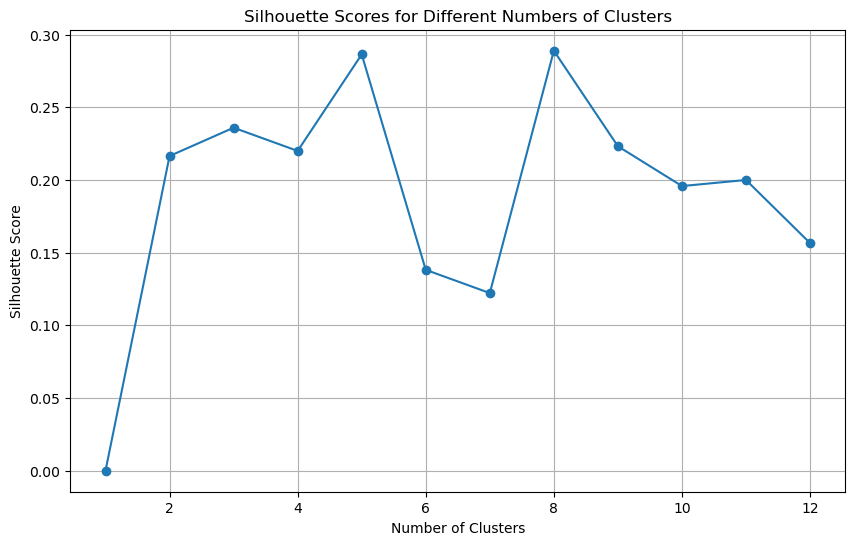

Optimal Number of Clusters: 8


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
9


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


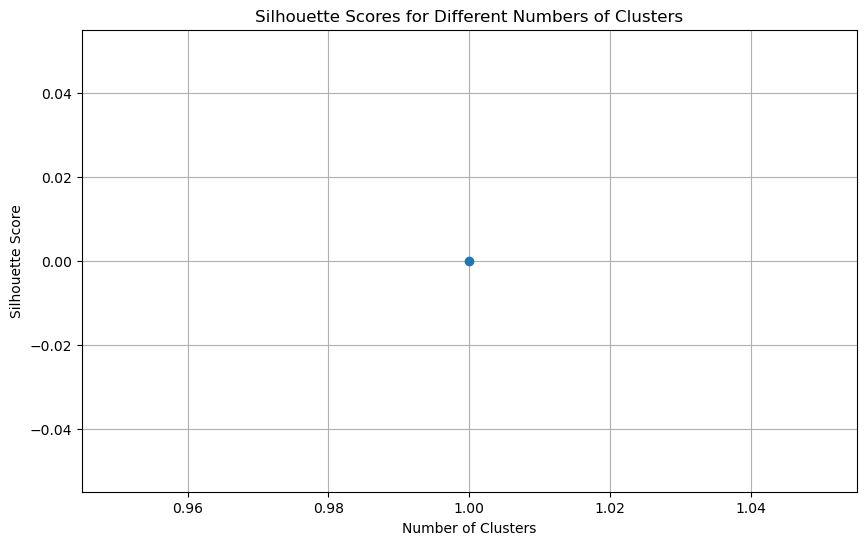

Optimal Number of Clusters: 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
10


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2412
Number of clusters: 3, Silhouette score: 0.3277
Number of clusters: 4, Silhouette score: 0.2818
Number of clusters: 5, Silhouette score: 0.2132
Number of clusters: 6, Silhouette score: 0.1971
Number of clusters: 7, Silhouette score: 0.2357
Number of clusters: 8, Silhouette score: 0.1628


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

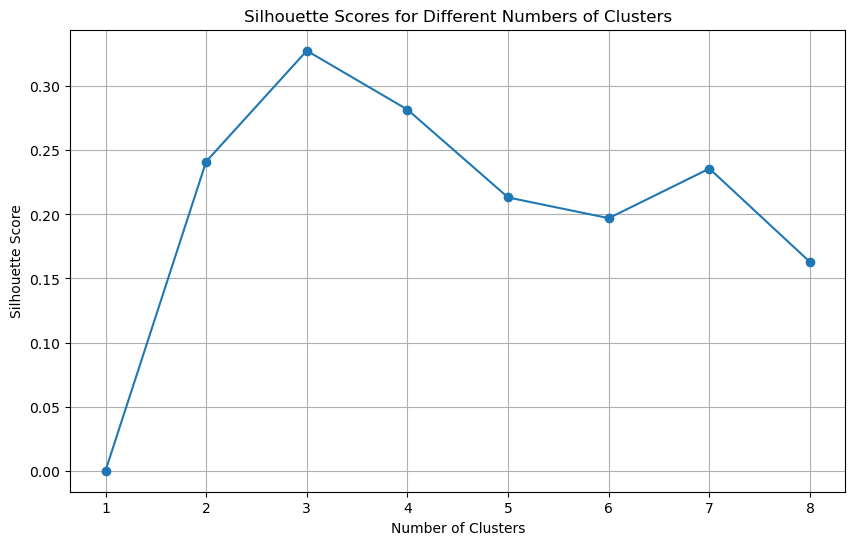

Optimal Number of Clusters: 3


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
13


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


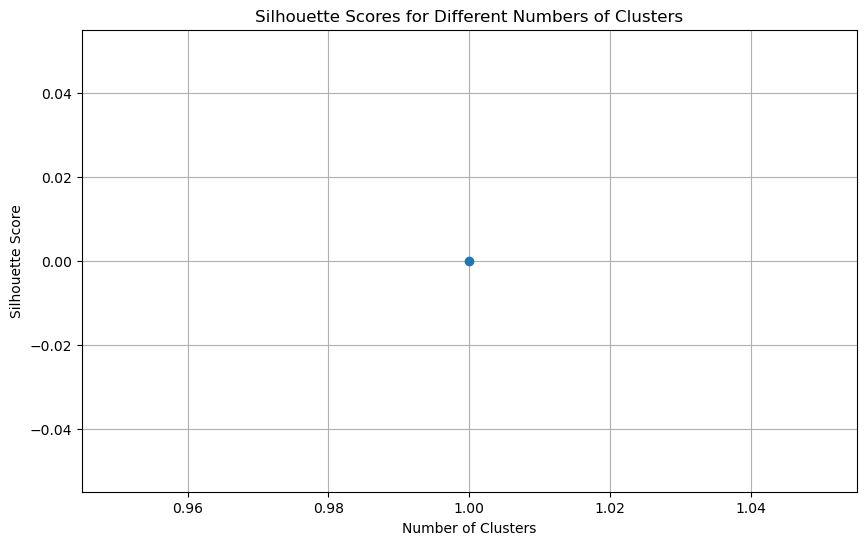

Optimal Number of Clusters: 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


11


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.4206
Number of clusters: 3, Silhouette score: 0.2910
Number of clusters: 4, Silhouette score: 0.3325
Number of clusters: 5, Silhouette score: 0.2872
Number of clusters: 6, Silhouette score: 0.2134
Number of clusters: 7, Silhouette score: 0.1748
Number of clusters: 8, Silhouette score: 0.1097


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

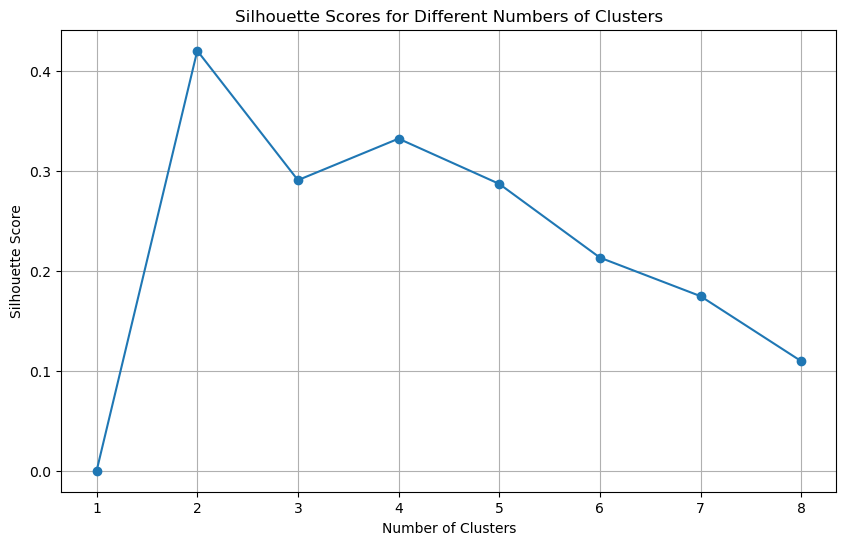

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
8


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


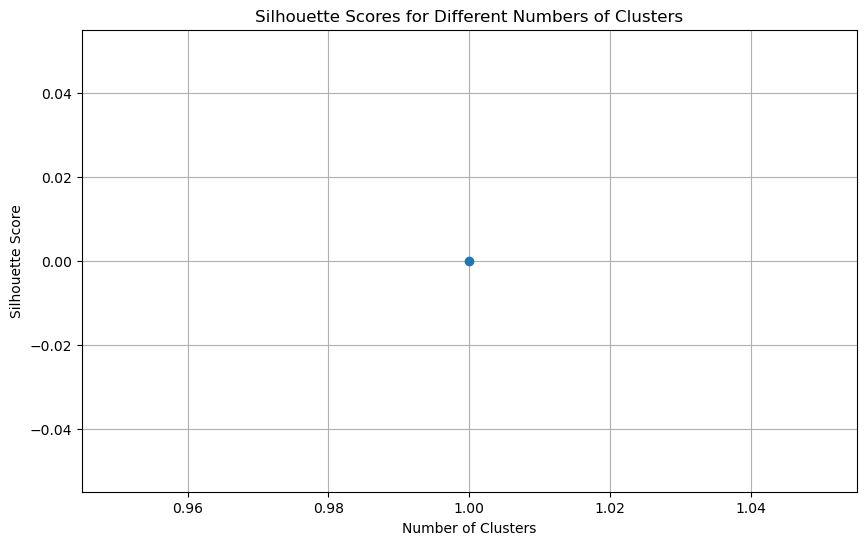

Optimal Number of Clusters: 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


15


  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2467


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


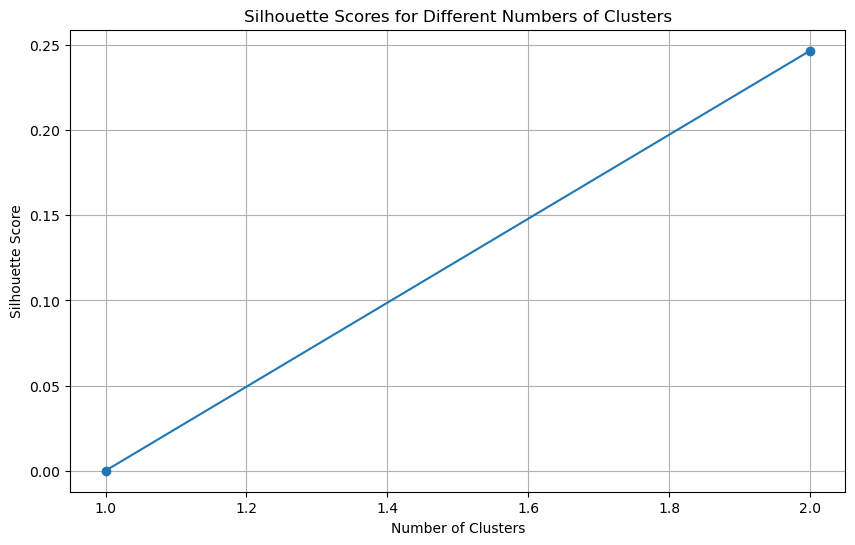

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
29


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


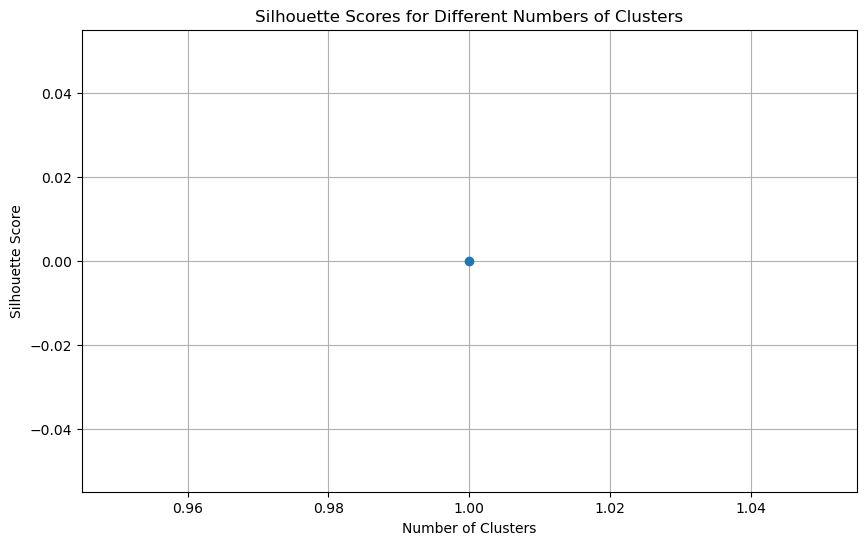

Optimal Number of Clusters: 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
14


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


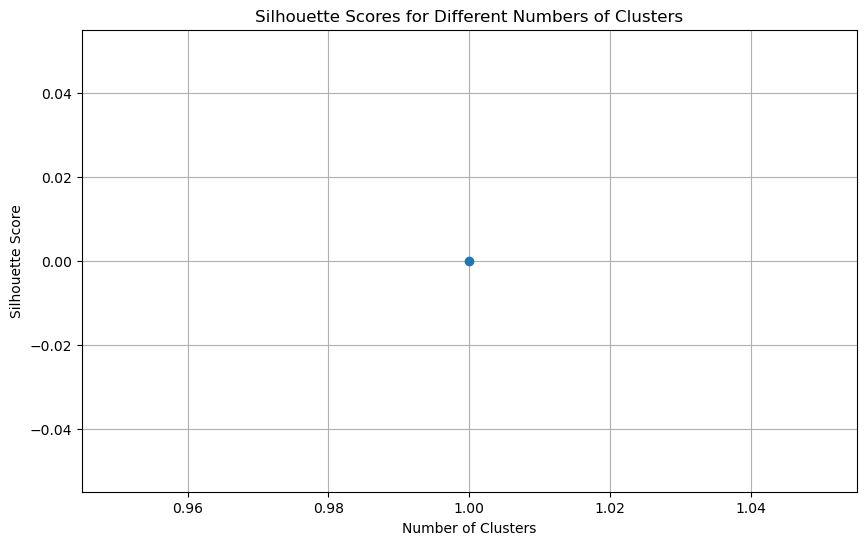

Optimal Number of Clusters: 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


27


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


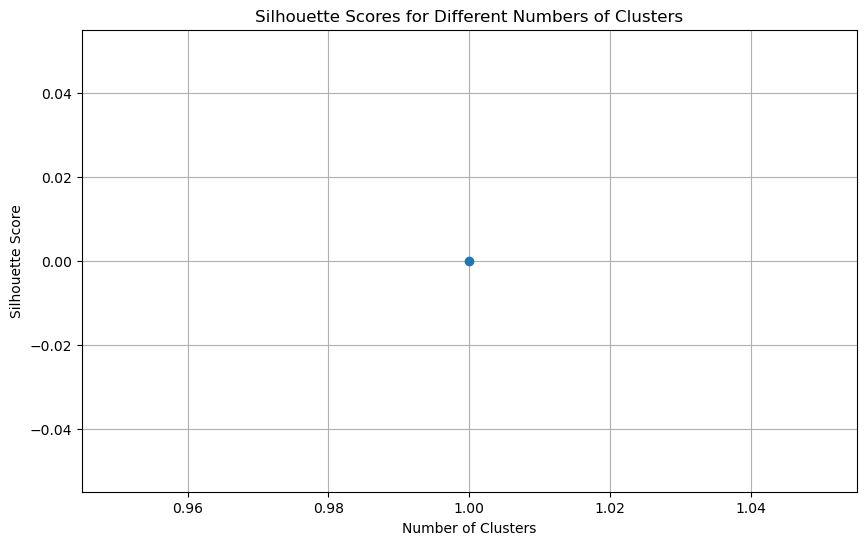

Optimal Number of Clusters: 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


33


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.2273
Number of clusters: 3, Silhouette score: 0.2190
Number of clusters: 4, Silhouette score: 0.2582
Number of clusters: 5, Silhouette score: 0.1991
Number of clusters: 6, Silhouette score: 0.1559
Number of clusters: 7, Silhouette score: 0.1483
Number of clusters: 8, Silhouette score: 0.0463


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

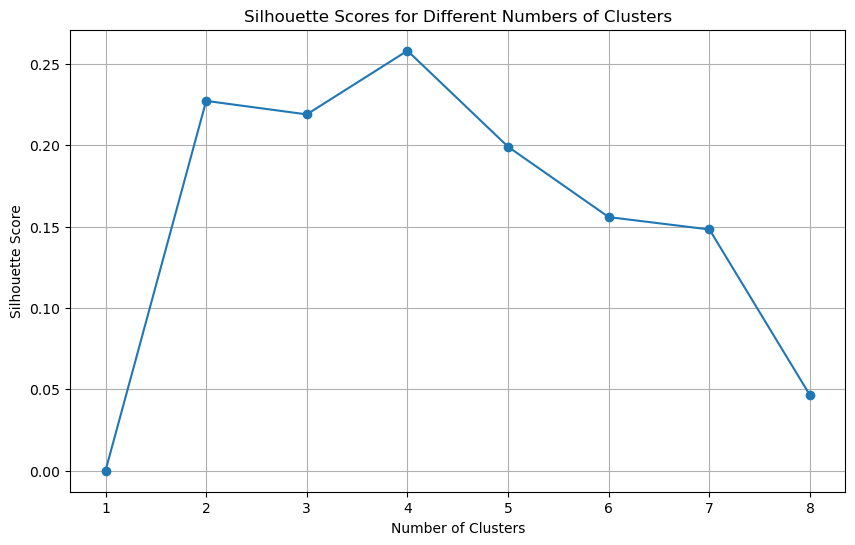

Optimal Number of Clusters: 4


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
34


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.3287
Number of clusters: 3, Silhouette score: 0.3259
Number of clusters: 4, Silhouette score: 0.3327
Number of clusters: 5, Silhouette score: 0.3246
Number of clusters: 6, Silhouette score: 0.1269


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

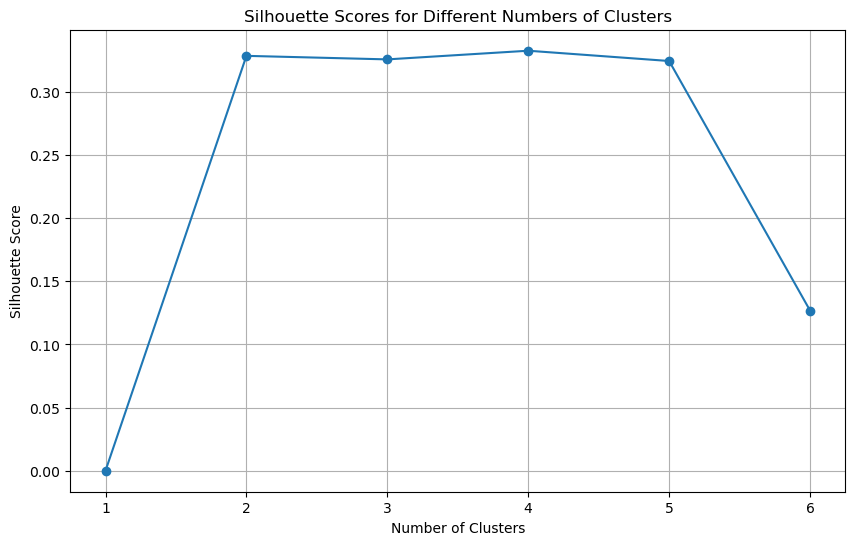

Optimal Number of Clusters: 4


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
31


  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.4069


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


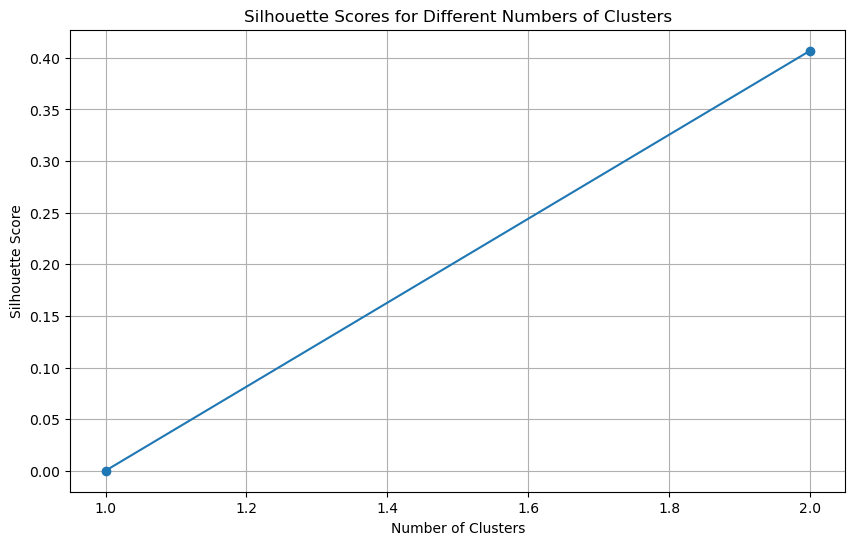

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


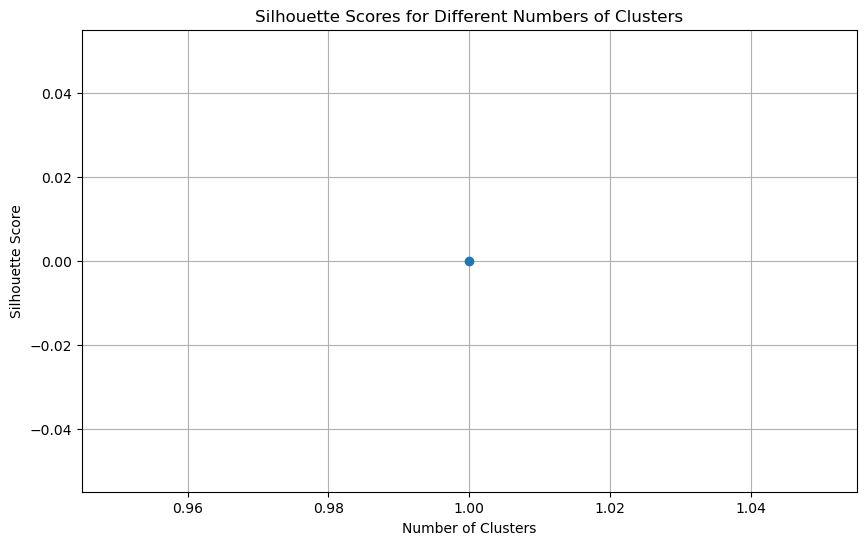

Optimal Number of Clusters: 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


5


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.3363
Number of clusters: 3, Silhouette score: 0.2483
Number of clusters: 4, Silhouette score: 0.2411
Number of clusters: 5, Silhouette score: 0.2571
Number of clusters: 6, Silhouette score: 0.2638
Number of clusters: 7, Silhouette score: 0.1074
Number of clusters: 8, Silhouette score: 0.0775


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

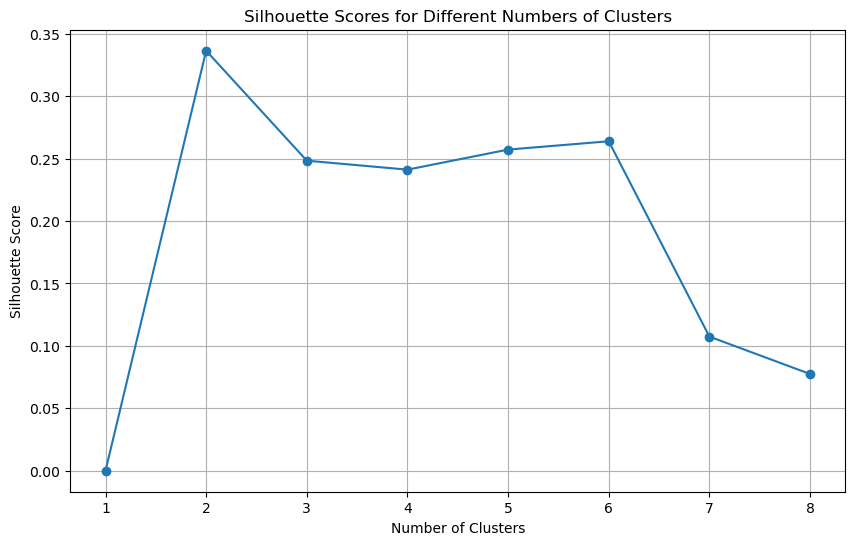

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)


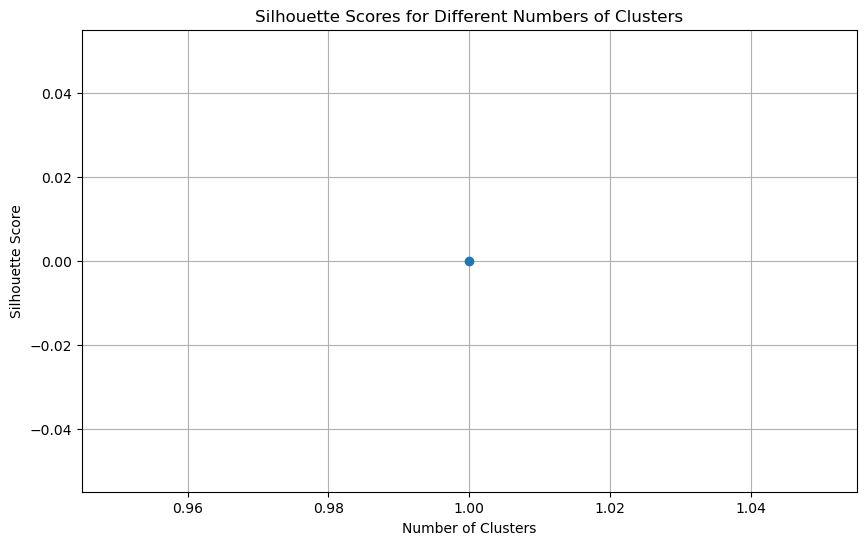

Optimal Number of Clusters: 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


0


  0%|          | 0/14 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.3074
Number of clusters: 3, Silhouette score: 0.2340
Number of clusters: 4, Silhouette score: 0.2042
Number of clusters: 5, Silhouette score: 0.1751
Number of clusters: 6, Silhouette score: 0.1200
Number of clusters: 7, Silhouette score: 0.2375
Number of clusters: 8, Silhouette score: 0.2652
Number of clusters: 9, Silhouette score: 0.2710
Number of clusters: 10, Silhouette score: 0.2269
Number of clusters: 11, Silhouette score: 0.2049
Number of clusters: 12, Silhouette score: 0.1598


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

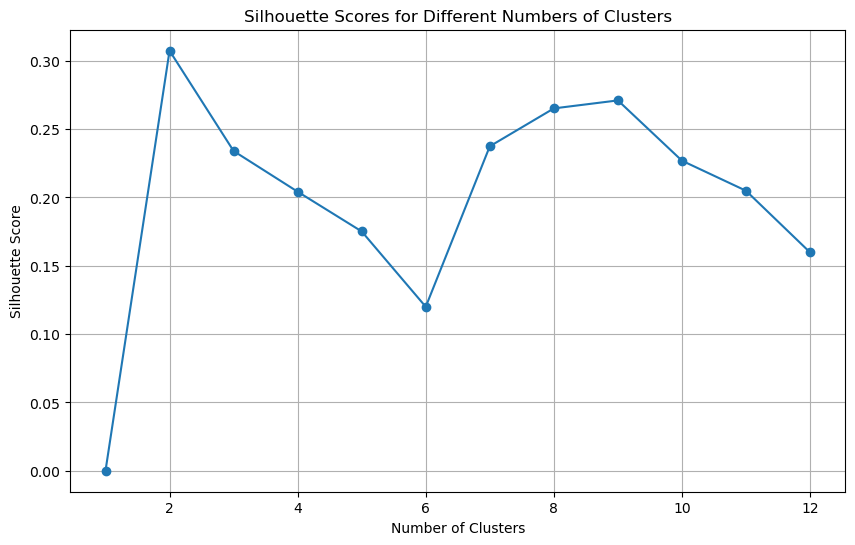

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
36


  0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.4876
Number of clusters: 3, Silhouette score: 0.4124
Number of clusters: 4, Silhouette score: 0.4198
Number of clusters: 5, Silhouette score: 0.3708
Number of clusters: 6, Silhouette score: 0.3804
Number of clusters: 7, Silhouette score: 0.2197
Number of clusters: 8, Silhouette score: 0.2754
Number of clusters: 9, Silhouette score: 0.2202
Number of clusters: 10, Silhouette score: 0.1681
Number of clusters: 11, Silhouette score: 0.0969
Number of clusters: 12, Silhouette score: 0.0830
Number of clusters: 13, Silhouette score: 0.0489


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

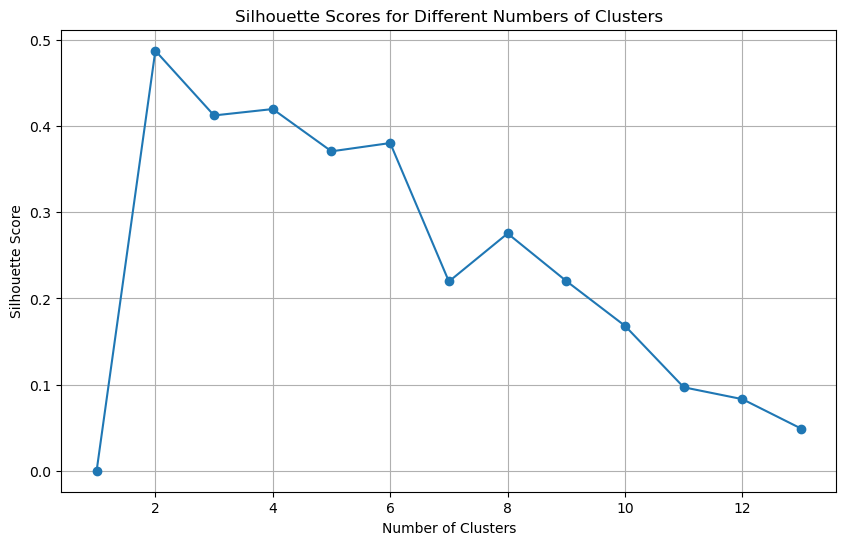

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
17


  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.1550
Number of clusters: 3, Silhouette score: 0.0383


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


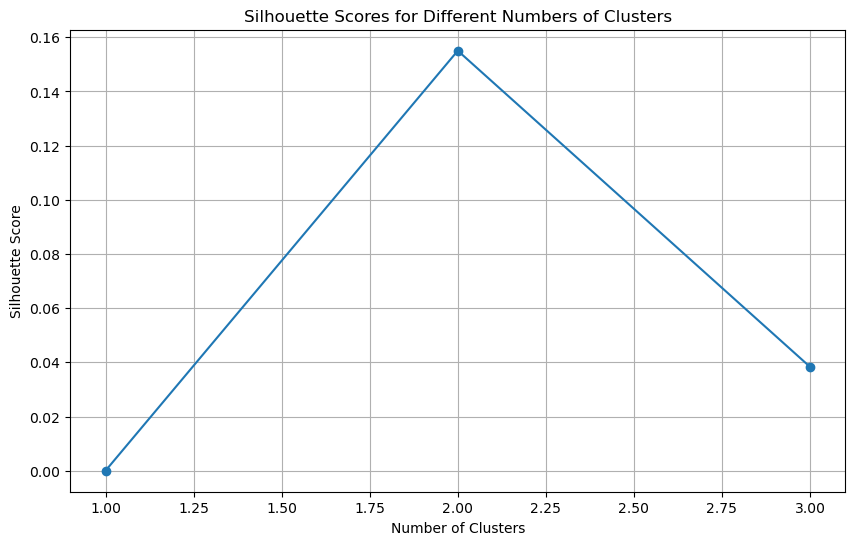

Optimal Number of Clusters: 2


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
3


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


19


  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
Number of clusters: 1, Silhouette score: N/A (defaulted to 0)
Number of clusters: 2, Silhouette score: 0.0747


C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


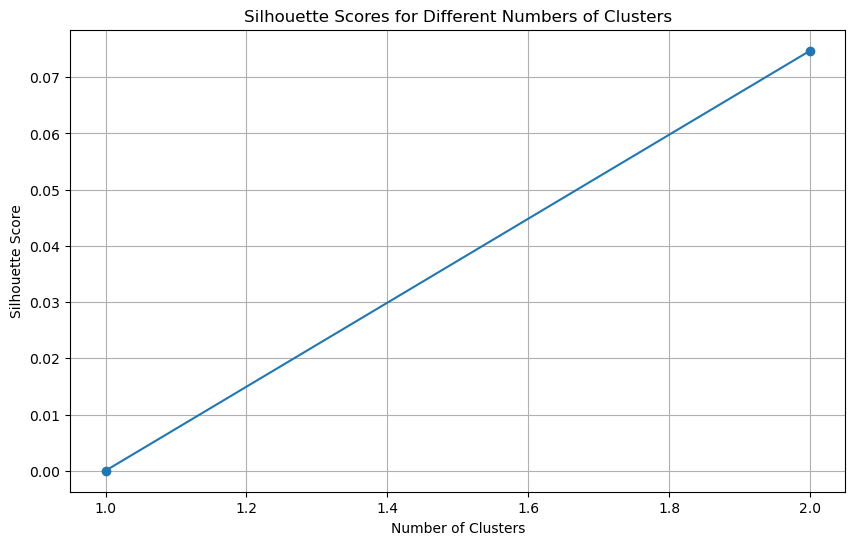

C:\tools\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Optimal Number of Clusters: 2


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
26


In [31]:
#Clustering all the defensive looks against each reciprocated formation
defensive_clustering = pd.DataFrame()
predict_dict = {'PlayId':[], 'O_Label':[], 'D_Label':[], 'Count':[], 'Prediction':[], 'Mean':[], 'Mean EPA':[], 'Explosive_%':[], 'Negative_%':[]}
drawings_dict = {}
predicted_plays = pd.DataFrame()
weights = np.linspace(-99, 99, 199)
ooo = 0
oo = pd.DataFrame()
#pmf multiplication is just times they happen added up
for i in reciprocated_labels:
    def_play_df = pd.DataFrame()
    defensive_label_df = leaguedf.loc[(leaguedf['Team'] == defense) & (leaguedf['Label'] == i)].reset_index(drop=True)
    for jdx, j in enumerate(defensive_label_df['PlayId']):
        pl = def_form_df.loc[(def_form_df['PlayId'] == j) & (def_form_df['IsOnOffense'] == False)].reset_index(drop=True)
        pl2 = pd.DataFrame()
        snap = pd.DataFrame(bdb.defense_locations(pl)).reset_index(drop=True)
        for kdx, k in enumerate(snap['NflId']):
            if (k in list(pl['NflId'])):
                pl2 = def_form_df.loc[(def_form_df['PlayId'] == j) & (def_form_df['IsOnOffense'] == False) & (def_form_df['NflId'] == k)].reset_index(drop=True)
                def_play_df = pd.concat([def_play_df, pl2]).reset_index(drop=True)
    #Find best offense and best of each defensive cluster, then predict
    defense_formation_dict = bdb.generateDefFormationImages(def_play_df,200,100,1)
    def_form_dict = {}
    for j in defense_formation_dict.keys():
        #if (i in playlist):
        def_form_dict[j] = defense_formation_dict[j]
    def_images = np.array(list(def_form_dict.values()))
    if len(def_images) > 2:
        def_clustering = bdb.DefKMeansClusteringWithVGG16(min_clusters=1, max_clusters=len(def_images)-1)
        def_labels = def_clustering.def_fit(def_images)
    elif len(def_images) > 1:
        def_clustering = bdb.DefKMeansClusteringWithVGG16(min_clusters=1, max_clusters=len(def_images))
        def_labels = def_clustering.def_fit(def_images)
    else:
        def_labels = np.array([0])
    def_dict = {'PlayId':[], 'Label':[], 'Team':[]}
    for idx, label in enumerate(def_labels):
        # Assuming you want to store the labels in the same dict
        def_dict['PlayId'].append(list(def_form_dict.keys())[idx])
        def_dict['Label'].append(label)
        def_dict['Team'].append(defense)
    def_df = pd.DataFrame(def_dict)
    dunique = def_form_df.drop_duplicates(subset = ['PlayId', 'expectedPointsAdded']).reset_index(drop=True)
    def_df = pd.merge(def_df, dunique[['PlayId', 'expectedPointsAdded']], how = 'left', on = 'PlayId').reset_index(drop=True)
    def_labels_deduped = np.unique(def_labels)
    #Find Offensive PlayID with Max EPA with this label
    offense_plays = list(leaguedf.loc[(leaguedf['Team'] == offense) & (leaguedf['Label'] == i)]['PlayId'])
    off_df = off_form_df.loc[(off_form_df['PlayId'].isin(offense_plays))].reset_index(drop=True)
    offense_max_pid = off_df.loc[(off_df['expectedPointsAdded'] == off_df['expectedPointsAdded'].min())]['PlayId'].iloc[0]
    offense_max = off_df.loc[(off_df['IsOnOffense'] == True) & (off_df['PlayId'] == offense_max_pid) & (off_df['PossessionTeam'] == offense)].reset_index(drop=True)
    #Find all Defensive PlayIds with Max EPA for all clusters within this label
    defense_plays = pd.DataFrame()
    for j in def_labels_deduped:
        pl = def_df.loc[(def_df['Label'] == j)].reset_index(drop=True)
        defense_min_pid = pl.loc[(pl['expectedPointsAdded'] == pl['expectedPointsAdded'].min())]['PlayId'].iloc[0]
        defense_min = def_form_df.loc[(def_form_df['PlayId'] == defense_min_pid) & (def_form_df['IsOnOffense'] == False)].reset_index(drop=True)
        offense_max['PlayIdO'] = offense_max['PlayId']
        offense_max['PlayIdD'] = defense_min['PlayId']
        defense_min['PlayIdO'] = offense_max['PlayId']
        defense_min['PlayIdD'] = defense_min['PlayId']
        defense_min = defense_min.loc[(defense_min['DefensiveTeam'] == defense) & (defense_min['IsOnOffense'] == False)].reset_index(drop=True)
        defense_comp = pd.concat([defense_min, offense_max]).reset_index(drop=True)
        defense_comp['PlayId'] = defense_comp['PlayIdD']
        defense_comp['Count'] = len(pl)
        defense_comp['O_Label'] = i
        defense_comp['D_Label'] = j
        defense_plays = pd.concat([defense_plays, defense_comp]).reset_index(drop=True)
        outliers = defense_min.loc[(defense_min['X'] > 70) | (defense_min['X'] < 50)].reset_index(drop=True)
        oo = pd.concat([oo, outliers])
        if (len(outliers) > 0):
            ooo+=1
            break
    predicted_plays = pd.concat([predicted_plays, defense_plays]).reset_index(drop=True)
    compare_dict = bdb.generateImages(defense_plays, 200, 100, 1)
    #Fix Drawings Dict
    for jdx, j in enumerate(compare_dict.keys()):
        drawings_dict[j] = compare_dict[j]
        o_label = defense_plays.loc[(defense_plays['PlayId'] == j)]['O_Label'].iloc[0]
        d_label = defense_plays.loc[(defense_plays['PlayId'] == j)]['D_Label'].iloc[0]
        play_count = defense_plays.loc[(defense_plays['PlayId'] == j)]['Count'].iloc[0]
        model_prediction = model.predict(compare_dict[j].reshape(1, 100, 200, 4) / 128.)
        avg = np.sum(weights * model_prediction)
        predict_dict['PlayId'].append(j)
        predict_dict['O_Label'].append(o_label)
        predict_dict['D_Label'].append(d_label)
        predict_dict['Count'].append(play_count)
        predict_dict['Prediction'].append(model_prediction)
        predict_dict['Mean'].append(avg)
        predict_dict['Mean EPA'].append(avg * 0.135 - 0.543)
        predict_dict['Explosive_%'].append(model_prediction[0][111:].sum())
        predict_dict['Negative_%'].append(model_prediction[0][:99].sum())
    print(i)

In [32]:
predict_df = pd.DataFrame(predict_dict)

In [33]:
offensive_formations = {'O_Label':[], 'Prediction':[], 'Mean':[], 'Mean EPA':[], 'Explosive_%':[], 'Negative_%':[]}
labels_unique = list(predict_df['O_Label'].drop_duplicates())
for idx, i in enumerate(labels_unique):
    pl = predict_df.loc[(predict_df['O_Label'] == i)].reset_index(drop=True)
    avg = (weights * pl['Prediction'].iloc[0]).sum()
    offensive_formations['O_Label'].append(i)
    offensive_formations['Prediction'].append((pl['Prediction'] * pl['Count']).sum() / pl['Count'].sum())
    offensive_formations['Mean'].append(avg)
    offensive_formations['Mean EPA'].append(avg * 0.135 - 0.543)
    offensive_formations['Explosive_%'].append(pl['Prediction'][0][0][111:].sum())
    offensive_formations['Negative_%'].append(pl['Prediction'][0][0][:99].sum())

In [34]:
ppdict = bdb.generateImages(predicted_plays, 1600, 800, 1)

  0%|          | 0/33 [00:00<?, ?it/s]

C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:179: RuntimeWarning: invalid value encountered in divide
  rho_bc = rho[2]/np.max(rho[2])*127
C:\Users\patrick.powers\AppData\Roaming\Python\Python312\site-packages\bdb_gameplan_space16\fns.py:182: RuntimeWarning: invalid value encountered in cast
  playTensor = playTensor.astype('int8')


In [35]:
player_number = pd.DataFrame()
for i in range(1, 10):
    pl = pd.read_csv('nfl-big-data-bowl-2025/tracking_week_' + str(i) + '.csv')
    pl = pl.loc[(pl['frameType'] == 'SNAP')].reset_index(drop=True)
    pl = pl.loc[(pl['displayName'] != 'football')].reset_index(drop=True)
    player_number = pd.concat([player_number, pl]).reset_index(drop=True)
player_number = player_number.rename(columns = {'playId':'PlayId', 'nflId':'NflId', 'jerseyNumber':'JerseyNumber'})
player_number['PlayId'] = player_number['gameId'].astype(str) + player_number['PlayId'].astype(str).str.zfill(4)
player_number['PlayId'] = player_number['PlayId'].astype('int64')
player_number = player_number[['PlayId', 'NflId', 'JerseyNumber']].reset_index(drop=True)

In [36]:
predict_df.head()

PlayId  O_Label  D_Label  Count  \
0  20220911010063       23        0      2   
1  20220918012368       35        0      2   
2  20221002011998       25        0      5   
3  20220922002083       20        0      8   
4  20220911010772        6        0      5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Prediction  \
0  [[5.336361e-05, 6.421924e-05, 7.148661e-05, 3.858779e-05, 3.8017995e-05, 7.214788e-05, 4.5222245e-05, 7.778485e-05, 4.4285738e-05, 5.0935112e-05, 4.6234127e-05, 5.3855594e-05, 3.6732832e-05, 6.198471e-05, 5.0708477e-05, 3.5230074e-05, 7.921832e-05, 6.405495e-05, 5.6562003e-05, 4.9921837e-05, 6.0532067e-05, 5.657074e-05, 3.8006827e-05, 5.9712052e-05, 4.3066266e-05, 3.6930167e-05, 4.5560413e-05, 4.434655e-05, 7.553541e-05, 4.1608037e-05, 4.797787e-05, 4.9065166e-05, 4.0542374e-05, 5.4770066e-0...   
1  [[5.396634e-05, 4.8972914e-05, 5.920882e-05, 2.6217189e-05, 3.691343e-05, 4.7664947e-05, 4.2379772e-05, 3.947089e-05, 3.9504783e-05, 4.4901597e-05, 3.6515397e-05, 3.805193e-05, 3.34796e-05, 3.990555e-05, 4.6371617e-05, 3.8593702e-05, 5.4868957e-05, 4.4525026e-05, 4.3766104e-05, 6.4525e-05, 3.562349e-05, 4.171092e-05, 3.20474e-05, 4.1467592e-05, 4.6247915e-05, 2.6031554e-05, 3.2354117e-05, 3.1761454e-05, 4.837181e-05, 4.01285e-05, 2.9888506e-05, 3.0681676e-05, 3.423542e-05, 4.157478e-05, 5.92...   
2  [[5.0332124e-05, 4.857823e-05, 6.2833846e-05, 2.453634e-05, 3.6303503e-05, 3.941775e-05, 3.9785067e-05, 3.459166e-05, 4.0509833e-05, 4.3390803e-05, 3.1642743e-05, 3.4332414e-05, 3.0841922e-05, 3.9720166e-05, 4.9347833e-05, 3.6001824e-05, 4.8275473e-05, 3.6373647e-05, 3.9155933e-05, 6.0056675e-05, 3.3730907e-05, 3.855542e-05, 2.8706605e-05, 3.6783807e-05, 4.1455707e-05, 2.4636602e-05, 2.9804203e-05, 2.9473471e-05, 4.2025415e-05, 3.8368427e-05, 2.465684e-05, 2.7343487e-05, 2.9936411e-05, 3.703...   
3  [[5.7788573e-05, 4.7586844e-05, 5.9812286e-05, 2.8361388e-05, 3.53991e-05, 4.774126e-05, 4.4387507e-05, 3.7603528e-05, 3.9353436e-05, 4.8102993e-05, 3.851539e-05, 4.3154323e-05, 3.1766274e-05, 4.0560695e-05, 4.8531474e-05, 3.8155722e-05, 5.450944e-05, 4.4224955e-05, 4.023703e-05, 6.689159e-05, 3.5655583e-05, 3.9023438e-05, 3.271837e-05, 3.916272e-05, 4.559701e-05, 2.6117748e-05, 3.140616e-05, 3.240001e-05, 4.432959e-05, 3.807499e-05, 2.893387e-05, 3.083086e-05, 3.2164644e-05, 3.9159622e-05, ...   
4  [[6.528827e-05, 6.6325396e-05, 7.7832636e-05, 3.771816e-05, 4.745146e-05, 5.9068047e-05, 5.501564e-05, 5.219935e-05, 4.5557088e-05, 4.5339857e-05, 4.7815323e-05, 4.77554e-05, 3.8331505e-05, 6.1092906e-05, 5.2026502e-05, 4.5579254e-05, 6.441009e-05, 6.0972136e-05, 5.435452e-05, 7.185016e-05, 5.432716e-05, 6.0948354e-05, 4.4593697e-05, 5.5954853e-05, 5.431452e-05, 3.6514e-05, 4.111911e-05, 4.366217e-05, 5.8245136e-05, 6.1206454e-05, 4.2708085e-05, 3.8516413e-05, 4.3186257e-05, 5.2550644e-05, 7...   

       Mean  Mean EPA  Explosive_%  Negative_%  
0  4.331524  0.041756     0.080478    0.121274  
1  4.550448  0.071311     0.097957    0.098133  
2  4.626104  0.081524     0.105081    0.096753  
3  4.551261  0.071420     0.097416    0.097187  
4  4.381750  0.048536     0.094927    0.111332

In [37]:
ofdf = pd.DataFrame(offensive_formations)
ofdf.sort_values(by = 'Mean', ascending=False).reset_index(drop=True)

O_Label  \
0         2   
1        15   
2         8   
3        25   
4         9   
5         0   
6        22   
7        32   
8        20   
9        35   
10       27   
11       31   
12       34   
13       17   
14       18   
15       21   
16       13   
17        6   
18       19   
19        1   
20       11   
21       14   
22        5   
23       23   
24        3   
25       29   
26        4   
27       36   
28       10   
29       12   
30       33   
31       26   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Prediction  \
0   [[5.6843714e-05, 5.1424126e-05, 6.851252e-05, 2.8548013e-05, 4.076476e-05, 5.6540568e-05, 4.5347842e-05, 4.677565e-05, 4.4885102e-05, 5.539251e-05, 3.9193517e-05, 4.510234e-05, 3.9984683e-05, 4.495926e-05, 5.3225725e-05, 4.5496858e-05, 6.375383e-05, 4.8050046e-05, 4.750538e-05, 6.8528265e-05, 3.9281116e-05, 4.3873984e-05, 3.5082758e-05, 4.477458e-05, 5.0307262e-05, 2.9249068e-05, 3.8886654e-05, 3.3796852e-05, 6.4191634e-05, 3.9128012e-05, 3.3560398e-05, 3.6754773e-05, 3.7788963e-05, 4.708734...   
1   [[4.9128244e-05, 4.199821e-05, 5.0883453e-05, 2.185723e-05, 3.520351e-05, 4.078502e-05, 3.6067424e-05, 3.3628603e-05, 3.3921297e-05, 4.144736e-05, 3.129166e-05, 3.5375553e-05, 3.141e-05, 3.455252e-05, 4.3336207e-05, 3.834886e-05, 4.9028968e-05, 3.6382142e-05, 4.056577e-05, 5.878341e-05, 2.8661005e-05, 3.364509e-05, 3.0069574e-05, 3.5473797e-05, 4.174926e-05, 2.2259754e-05, 2.9580247e-05, 2.677907e-05, 4.5593148e-05, 3.110057e-05, 2.5097324e-05, 2.5762953e-05, 2.9099245e-05, 3.739811e-05, 4.9...   
2   [[6.085523e-05, 5.663537e-05, 7.209006e-05, 3.2576285e-05, 4.2077114e-05, 5.215266e-05, 4.836179e-05, 4.2289845e-05, 4.45811e-05, 5.278408e-05, 4.166665e-05, 4.4208486e-05, 3.5649067e-05, 4.9271315e-05, 5.6282053e-05, 4.316986e-05, 6.099764e-05, 5.052429e-05, 4.4395947e-05, 7.4468015e-05, 4.0410327e-05, 4.6317462e-05, 3.7520473e-05, 4.5429486e-05, 5.4435226e-05, 3.1649233e-05, 3.64252e-05, 3.6152145e-05, 4.9337566e-05, 4.5119214e-05, 3.173592e-05, 3.4876837e-05, 4.060909e-05, 4.4085922e-05, ...   
3   [[5.0332124e-05, 4.857823e-05, 6.2833846e-05, 2.4536339e-05, 3.6303503e-05, 3.941775e-05, 3.9785067e-05, 3.459166e-05, 4.0509833e-05, 4.3390803e-05, 3.1642743e-05, 3.4332414e-05, 3.0841922e-05, 3.9720166e-05, 4.9347833e-05, 3.6001824e-05, 4.8275473e-05, 3.6373647e-05, 3.9155933e-05, 6.0056675e-05, 3.3730907e-05, 3.855542e-05, 2.8706603e-05, 3.6783807e-05, 4.1455707e-05, 2.4636602e-05, 2.9804203e-05, 2.9473473e-05, 4.2025415e-05, 3.8368427e-05, 2.4656842e-05, 2.7343489e-05, 2.993641e-05, 3.70...   
4   [[6.268064e-05, 5.356556e-05, 6.513459e-05, 3.3730834e-05, 4.2255157e-05, 6.293233e-05, 4.9964696e-05, 5.1600528e-05, 4.2043805e-05, 5.3624954e-05, 4.4079483e-05, 4.970368e-05, 3.8105027e-05, 5.0308237e-05, 4.7239355e-05, 4.3269636e-05, 6.523421e-05, 4.951774e-05, 4.822167e-05, 7.138619e-05, 4.2104195e-05, 4.4134544e-05, 3.796824e-05, 4.6534533e-05, 4.851518e-05, 2.959161e-05, 3.649086e-05, 3.8656992e-05, 5.686346e-05, 4.4271714e-05, 3.514701e-05, 3.8188955e-05, 4.0544568e-05, 4.9300146e-05,...   
5   [[5.312606e-05, 5.8939797e-05, 7.3296134e-05, 3.270574e-05, 3.6926784e-05, 4.4623153e-05, 4.413193e-05, 3.6984446e-05, 4.7992147e-05, 4.818982e-05, 3.5403562e-05, 4.1819352e-05, 3.079046e-05, 4.9160666e-05, 4.9820064e-05, 4.0388662e-05, 5.3876498e-05, 4.4852826e-05, 3.8696613e-05, 6.991812e-05, 3.9901908e-05, 4.3796346e-05, 3.1384905e-05, 4.5396126e-05, 4.4840675e-05, 3.119e-05, 3.393252e-05, 3.2862754e-05, 3.9140286e-05, 4.6165573e-05, 2.972818e-05, 3.07375

In [38]:
players1 = pd.read_csv('nfl-big-data-bowl-2025/players.csv')

In [40]:
ofdf_mean = ofdf.sort_values(by = 'Mean', ascending=False).reset_index(drop=True)
ofdf_expl = ofdf.sort_values(by = 'Explosive_%', ascending=False).reset_index(drop=True)
ofdf_neg = ofdf.sort_values(by = 'Negative_%', ascending=False).reset_index(drop=True)

In [41]:
ofdf_mean_list = list(ofdf.sort_values(by = 'Mean', ascending=False).reset_index(drop=True)['O_Label'])[:5]
ofdf_expl_list = list(ofdf.sort_values(by = 'Explosive_%', ascending=False).reset_index(drop=True)['O_Label'])[:5]
ofdf_neg_list = list(ofdf.sort_values(by = 'Negative_%', ascending=False).reset_index(drop=True)['O_Label'])[:5]

In [42]:
best_list = np.unique(ofdf_mean_list +  ofdf_expl_list + ofdf_neg_list)

In [43]:
print(ofdf_mean['O_Label'].iloc[:5])
print(ofdf_expl['O_Label'].iloc[:5])
print(ofdf_neg['O_Label'].iloc[:5])

0     2
1    15
2     8
3    25
4     9
Name: O_Label, dtype: int64
0     2
1     0
2    15
3     8
4    25
Name: O_Label, dtype: int64
0    26
1    11
2    23
3    19
4     4
Name: O_Label, dtype: int64


In [44]:
play_stats1 = pd.read_csv("nfl-big-data-bowl-2025//plays.csv")

In [45]:
best_list

array([ 0,  2,  4,  8,  9, 11, 15, 19, 23, 25, 26])

In [46]:
len(ofdf_mean)

32

In [47]:
predicted_plays.head()

GameId          PlayId  Team      X          Y     S     A   Dis  \
0  2022091101  20220911010063  away  60.95  18.360001  0.53  0.70  0.18   
1  2022091101  20220911010063  away  60.43  28.430001  0.61  0.77  0.06   
2  2022091101  20220911010063  away  75.24  23.130001  0.22  0.12  0.01   
3  2022091101  20220911010063  away  65.52  24.480001  0.12  1.48  0.01   
4  2022091101  20220911010063  away  68.60  13.690001  0.17  0.19  0.05   

        Dir    NflId Position  YardLine  Quarter  GameClock PossessionTeam  \
0  1.407084  41227.0      OLB        22        1    0.93437            CAR   
1  0.983842  44813.0       DE        22        1    0.93437            CAR   
2 -4.701393  44903.0       SS        22        1    0.93437            CAR   
3 -2.060710  44974.0      MLB        22        1    0.93437            CAR   
4  0.636347  46073.0       CB        22        1    0.93437            CAR   

  DefensiveTeam  Down  Distance FieldPosition  HomeScoreBeforePlay  \
0           CLE     1        10           CAR                    0   
1           CLE     1        10           CAR                    0   
2           CLE     1        10           CAR                    0   
3           CLE     1        10           CAR                    0   
4           CLE     1        10           CAR                    0   

   VisitorScoreBeforePlay  NflIdRusher OffenseFormation PlayDirection  Yards  \
0                       0          NaN       SINGLEBACK         right      0   
1                       0          NaN       SINGLEBACK         right      0   
2                       0          NaN       SINGLEBACK         right      0   
3                       0          NaN       SINGLEBACK         right      0   
4                       0          NaN       SINGLEBACK         right      0   

   expectedPointsAdded HomeTeamAbbr VisitorTeamAbbr  ToLeft  BallCarrier  \
0            -0.711197          CAR             CLE   False          0.0   
1            -0.711197          CAR             CLE   False          0.0   
2            -0.711197          CAR             CLE   False          0.0   
3            -0.711197          CAR             CLE   False          0.0   
4            -0.711197          CAR             CLE   False          0.0   

  TeamOnOffense  IsOnOffense  YardsFromOwnGoal  ScoreDiff rushLocationType  \
0          home        False                22          0              NaN   
1          home        False                22          0              NaN   
2          home        False                22          0              NaN   
3          home        False                22          0              NaN   
4          home        False                22          0              NaN   

  pff_runConceptPrimary         PlayIdO         PlayIdD  Count  O_Label  \
0                  DRAW  20220929002375  20220911010063      2       23   
1                  DRAW  20220929002375  20220911010063      2       23   
2                  DRAW  20220929002375  20220911010063      2       23   
3                  DRAW  20220929002375  20220911010063      2       23   
4                  DRAW  20220929002375  20220911010063      2       23   

   D_Label  
0        0  
1        0  
2        0  
3        0  
4        0

In [ ]:
#5 best
var = 'Mean'
ofdf = pd.DataFrame(offensive_formations)
ofdf = ofdf.sort_values(by = 'Mean', ascending=False).reset_index(drop=True)
for hdx, h in enumerate(ofdf_mean['O_Label']):
    offensive_play = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdO'].drop_duplicates())[0]
    playlistD = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdD'].drop_duplicates())
    for idx, i in enumerate(playlistD):
        def_label = predicted_plays.loc[(predicted_plays['PlayIdD'] == i)]['D_Label'].iloc[0]
        snapo = predicted_plays.loc[(predicted_plays['PlayIdO'] == offensive_play) & (predicted_plays['PossessionTeam'] == offense) & (predicted_plays['IsOnOffense'] == True)].reset_index(drop=True)
        snapo = snapo.sort_values(by = 'Y').reset_index(drop=True)
        pos_pl = 0
        for jdx, j in enumerate(snapo['Position']):
            if (j in ['T', 'G', 'C']):
                if pos_pl == 0:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Terron Armstead')]['nflId'].iloc[0]
                elif pos_pl == 1:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Robert Jones')]['nflId'].iloc[0]
                elif pos_pl == 2:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Connor Williams')]['nflId'].iloc[0]
                elif pos_pl == 3:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Robert Hunt')]['nflId'].iloc[0]
                elif pos_pl == 4:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Brandon Shell')]['nflId'].iloc[0]
                pos_pl+=1
        snapo = pd.merge(snapo, player_number, how = 'left', on = 'NflId').reset_index(drop=True)
        snapd = predicted_plays.loc[(predicted_plays['PlayIdD'] == i) & (predicted_plays['DefensiveTeam'] == defense) & (predicted_plays['IsOnOffense'] == False)].reset_index(drop=True)
        snapd = pd.merge(snapd, player_number, how = 'left', left_on = ['PlayIdD', 'NflId'], right_on = ['PlayId', 'NflId']).reset_index(drop=True)
        snap = pd.concat([snapo, snapd]).reset_index(drop=True)
        snap = pd.merge(snap, player_space[['NflId', 'Space Factor Adj']], how = 'left', on = 'NflId').reset_index(drop=True)
        
        
        field_width = 53.33  # NFL field width
        field_length = 120  # View range: -20 to 20
        hashmark_to_sideline = 23.42  # NFL official hash mark distance from sideline
        hashmark_width = .67  # hashmark length
        number_to_sideline = 12  # NFL official hash mark distance from sideline
        number_width = 2  # hashmark length
    
        fig, ax = bdb.plt.subplots(figsize=(field_width/5, field_length/7.5))
    
        overlay_image = ppdict[i][:, :, 3]
        overlay_image = np.rot90(overlay_image)
        overlay_image = np.flip(overlay_image, axis=1)
        
        custom_cmap = ListedColormap(["#311D00", "mediumseagreen", "#FC4C02"])
        x_min, x_max, y_min, y_max = -field_width/2, field_width/2, -field_length/2, field_length/2
        ax.imshow(overlay_image, cmap=custom_cmap, extent=[x_min, x_max, y_min, y_max], zorder = 5)
    
        # Main field (excluding end zones)
        ax.add_patch(bdb.patches.Rectangle(
            (-field_width/2, -field_length/2), field_width, field_length,
            linewidth=2, edgecolor='black', facecolor='none', zorder=9))
        
        for idx, row in snap.iterrows():
            x_draw = row['X'] - (field_length / 2)# - 50
            y_draw = row['Y'] - (field_width / 2)
            #y_draw_d = 53.33 - row['Y'] - (field_width / 2)
            pos = row['Position']
            team = row['PossessionTeam']
            size = row['Space Factor Adj']
            jersey_number = int(row['JerseyNumber'])
            if team == offense:
                if pos in ['T', 'G', 'C']:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#008E97', edgecolor='black', lw=2)).set_zorder(10)
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
                else:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#008E97', edgecolor='black', lw=2)).set_zorder(10)
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
            else:
                if pos in ['DT', 'DE', 'NT']:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#FF3C00', edgecolor='black', lw=2)).set_zorder(10)
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
                else:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#FF3C00', edgecolor='black', lw=2)).set_zorder(10)   
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
            
        for yard in range(int((-field_length/2)), int((field_length/2)), 1):
            linestyle = '-' #if yard % 10 == 0 else '--'
            y_position = yard
            if yard % 5 == 0:
                ax.plot([-field_width/2, field_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
            else:
                ax.plot([-field_width/2 + hashmark_to_sideline - hashmark_width/2, -field_width/2 + hashmark_to_sideline + hashmark_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
                ax.plot([field_width/2 - hashmark_to_sideline + hashmark_width/2, field_width/2 - hashmark_to_sideline - hashmark_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
    
            number_offset = number_width / 2  # Half the height of the number box
    
            if (yard % 10 == 0) & (yard != int(-field_length/2)) & (yard != int((field_length/2))):
                # Left numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                
                # Right numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
    
        ax.set_xlim(-field_width/2, field_width/2)
        ax.set_ylim(-field_length/2, field_length/2)
        bdb.plt.gca().set_facecolor('green')
        bdb.plt.axis('off')
        #bdb.plt.title(str(i))
        bdb.plt.ylim(-15, 20) 
        bdb.plt.savefig(prefix + '/testfig/best/testfig-O' + str(h) + '-D' + str(def_label) + '-' + str(i)+  '.jpg', bbox_inches="tight", pad_inches = 0, dpi = 600)
        bdb.plt.show()

In [ ]:
for i in range(len(predict_df)):
    bdb.plt.figure(figsize=(10, 6))  # Optional: Set figure size01
    bdb.plt.ylim([0, .5])
    bdb.plt.xlim([94, 109])
    new_x_ticks = [94, 99, 104, 109]
    new_x_labels = [-5, 0, 5, 10]
    new_y_ticks = [0, .1, .2, .3, .4, .5]
    new_y_labels = ['0%', '10%', '20%', '30%', '40%', '50%']
    bdb.plt.xticks(new_x_ticks, new_x_labels)
    bdb.plt.yticks(new_y_ticks, new_y_labels)
    y_values = predict_df['Prediction'].iloc[i][0].reshape(-1,)
    x_values = np.array(range(len(y_values)))
    bdb.plt.plot(x_values, y_values, color='black')
    bdb.plt.fill_between(x_values, y_values, 0, where=(x_values >= 99), alpha=1, color='#008E97')
    bdb.plt.fill_between(x_values, y_values, 0, where=(x_values <= 99), alpha=1, color='#FC4C02')# alpha controls the transparency
    bdb.plt.show()

In [ ]:
for i in range(len(ofdf_mean.iloc[:8])):
    bdb.plt.figure(figsize=(10, 6))  # Optional: Set figure size01
    bdb.plt.ylim([0, .5])
    bdb.plt.xlim([94, 109])
    new_x_ticks = [94, 99, 104, 109]
    new_x_labels = [-5, 0, 5, 10]
    new_y_ticks = [0, .1, .2, .3]
    new_y_labels = ['0%', '10%', '20%', '30%']
    bdb.plt.xticks(new_x_ticks, new_x_labels)
    bdb.plt.yticks(new_y_ticks, new_y_labels)
    y_values = ofdf_mean['Prediction'].iloc[i][0].reshape(-1,)
    x_values = np.array(range(len(y_values)))
    bdb.plt.plot(x_values, y_values, color='black')
    bdb.plt.fill_between(x_values, y_values, 0, where=(x_values >= 99), alpha=1, color='#008E97')
    bdb.plt.fill_between(x_values, y_values, 0, where=(x_values <= 99), alpha=1, color='#FC4C02')# alpha controls the transparency
    bdb.plt.show()

In [ ]:
#5 best
var = 'Mean'
ofdf = pd.DataFrame(offensive_formations)
ofdf = ofdf.sort_values(by = 'Mean', ascending=False).reset_index(drop=True)
for hdx, h in enumerate(ofdf_mean['O_Label'][:8]):
    offensive_play = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdO'].drop_duplicates())[0]
    playlistD = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdD'].drop_duplicates())
    for idx, i in enumerate(playlistD):
        def_label = predicted_plays.loc[(predicted_plays['PlayIdD'] == i)]['D_Label'].iloc[0]
        snapo = predicted_plays.loc[(predicted_plays['PlayIdO'] == offensive_play) & (predicted_plays['PossessionTeam'] == offense) & (predicted_plays['IsOnOffense'] == True)].reset_index(drop=True)
        snapo = pd.merge(snapo, player_number, how = 'left', left_on = ['PlayIdO', 'NflId'], right_on = ['PlayId', 'NflId']).reset_index(drop=True)
        snapd = predicted_plays.loc[(predicted_plays['PlayIdD'] == i) & (predicted_plays['DefensiveTeam'] == defense) & (predicted_plays['IsOnOffense'] == False)].reset_index(drop=True)
        snapd = pd.merge(snapd, player_number, how = 'left', left_on = ['PlayIdD', 'NflId'], right_on = ['PlayId', 'NflId']).reset_index(drop=True)
        snap = pd.concat([snapo, snapd]).reset_index(drop=True)
        snap = pd.merge(snap, player_space[['NflId', 'Space Factor Adj']], how = 'left', on = 'NflId').reset_index(drop=True)
        
        field_width = 53.33  # NFL field width
        field_length = 120  # View range: -20 to 20
        hashmark_to_sideline = 23.42  # NFL official hash mark distance from sideline
        hashmark_width = .67  # hashmark length
        number_to_sideline = 12  # NFL official hash mark distance from sideline
        number_width = 2  # hashmark length
    
        fig, ax = bdb.plt.subplots(figsize=(field_width/5, field_length/7.5))
    
        overlay_image = ppdict[i][:, :, 3]
        overlay_image = np.rot90(overlay_image)
        overlay_image = np.flip(overlay_image, axis=1)
        
        custom_cmap = ListedColormap(["#311D00", "mediumseagreen", "#FC4C02"])
        x_min, x_max, y_min, y_max = -field_width/2, field_width/2, -field_length/2, field_length/2
        ax.imshow(overlay_image, cmap=custom_cmap, extent=[x_min, x_max, y_min, y_max], zorder = 5)
    
        # Main field (excluding end zones)
        ax.add_patch(bdb.patches.Rectangle(
            (-field_width/2, -field_length/2), field_width, field_length,
            linewidth=2, edgecolor='black', facecolor='none', zorder=9))
        
        for idx, row in snap.iterrows():
            x_draw = row['X'] - (field_length / 2)# - 50
            y_draw = row['Y'] - (field_width / 2)
            #y_draw_d = 53.33 - row['Y'] - (field_width / 2)
            pos = row['Position']
            team = row['PossessionTeam']
            size = row['Space Factor Adj']
            jersey_number = int(row['JerseyNumber'])
            if team == offense:
                if pos in ['T', 'G', 'C']:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#008E97', edgecolor='black', lw=2)).set_zorder(10)
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
                else:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#008E97', edgecolor='black', lw=2)).set_zorder(10)
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + (14*size)), zorder=11, weight='bold')
            else:
                if pos in ['DT', 'DE', 'NT']:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#FF3C00', edgecolor='black', lw=2)).set_zorder(10)
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
                else:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#FF3C00', edgecolor='black', lw=2)).set_zorder(10)   
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + (14*size)), zorder=11, weight='bold')
            
        for yard in range(int((-field_length/2)), int((field_length/2)), 1):
            linestyle = '-' #if yard % 10 == 0 else '--'
            y_position = yard
            if yard % 5 == 0:
                ax.plot([-field_width/2, field_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
            else:
                ax.plot([-field_width/2 + hashmark_to_sideline - hashmark_width/2, -field_width/2 + hashmark_to_sideline + hashmark_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
                ax.plot([field_width/2 - hashmark_to_sideline + hashmark_width/2, field_width/2 - hashmark_to_sideline - hashmark_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
    
            number_offset = number_width / 2  # Half the height of the number box
    
            if (yard % 10 == 0) & (yard != int(-field_length/2)) & (yard != int((field_length/2))):
                # Left numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                
                # Right numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
    
        ax.set_xlim(-field_width/2, field_width/2)
        ax.set_ylim(-field_length/2, field_length/2)
        bdb.plt.gca().set_facecolor('green')
        bdb.plt.axis('off')
        #bdb.plt.title(str(i))
        bdb.plt.ylim(-15, 20) 
        bdb.plt.savefig(prefix + '/testfig/best/testfig-O' + str(h) + '-D' + str(def_label) + '-' + str(i)+  '.jpg', bbox_inches="tight", pad_inches = 0, dpi = 600)
        bdb.plt.show()

In [ ]:
for idx, i in enumerate(player_space['Position']):
    position_adj = player_space.loc[(player_space['Position'] == player_space['Position'].iloc[idx])]['Space Factor'].min()
    player_space.at[idx, 'Space Factor Adj'] = player_space['Space Factor'].iloc[idx] - position_adj
    print(idx)

In [50]:
for idx, i in enumerate(player_space['Position']):
    position_adj = player_space.loc[(player_space['Position'] == player_space['Position'].iloc[idx])]['Space Factor'].min()
    player_space.at[idx, 'Space Factor Adj'] = player_space['Space Factor'].iloc[idx] - position_adj
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

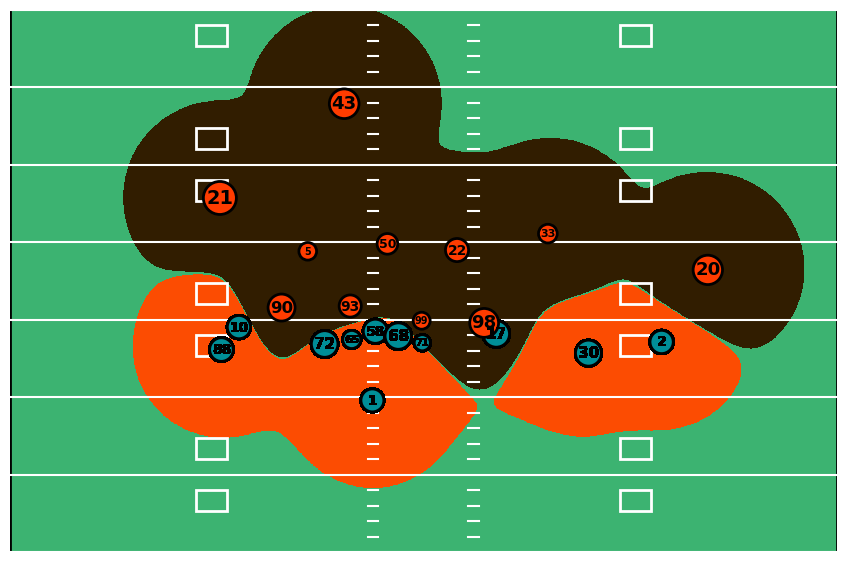

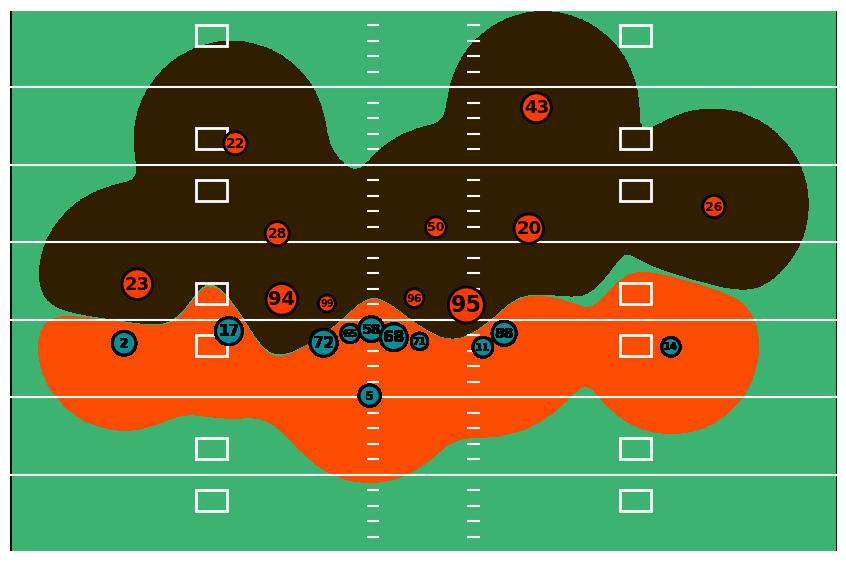

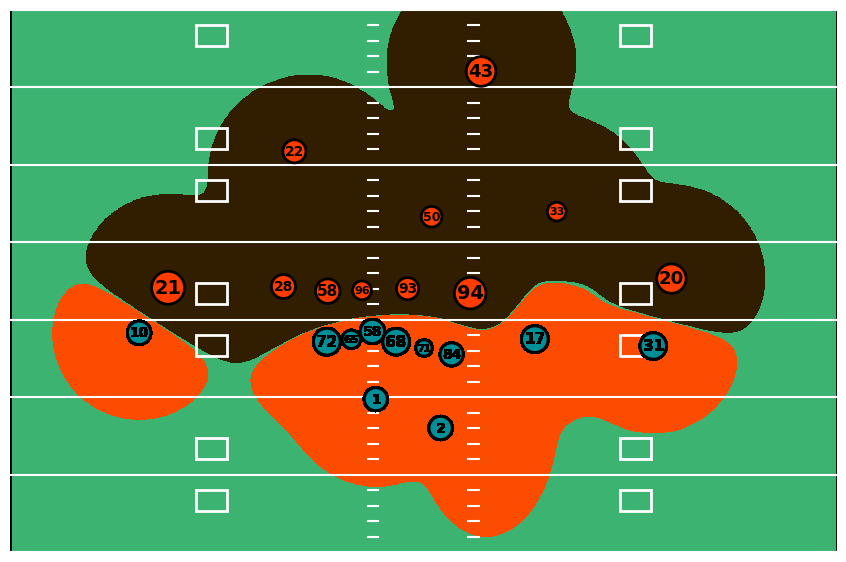

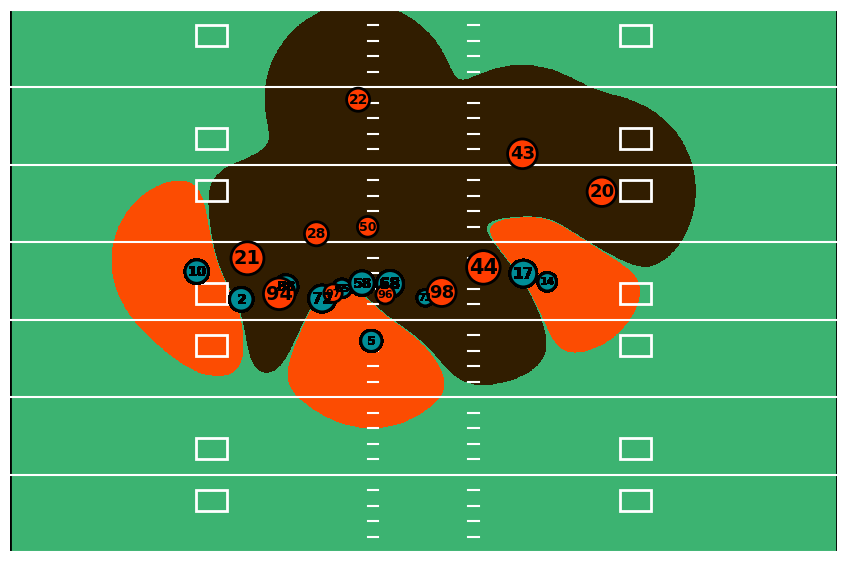

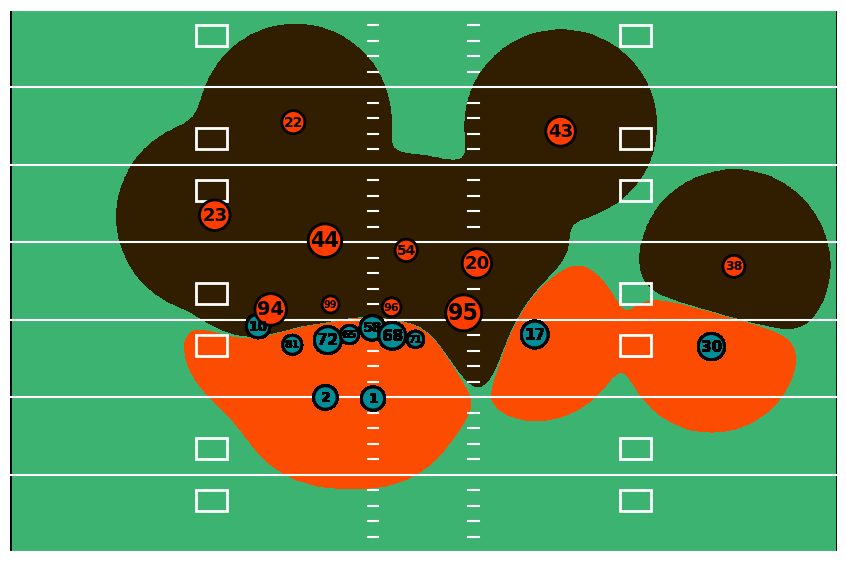

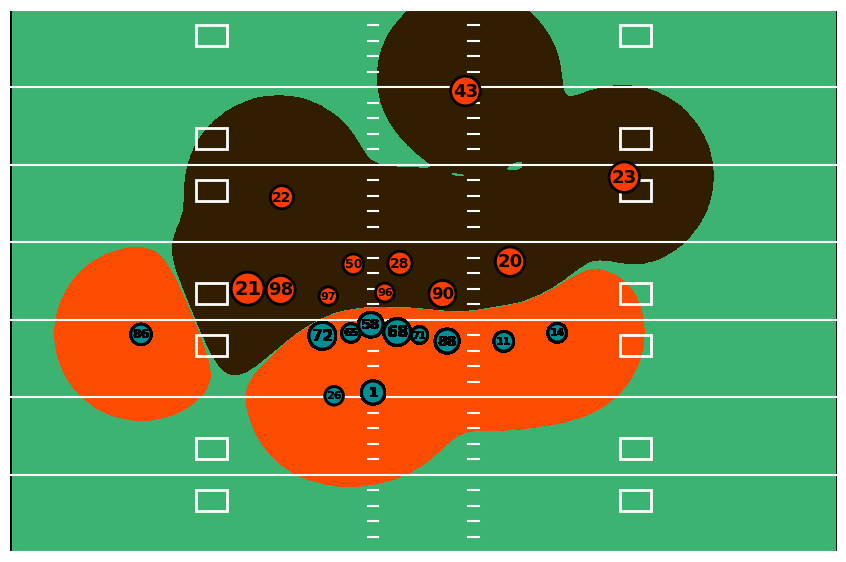

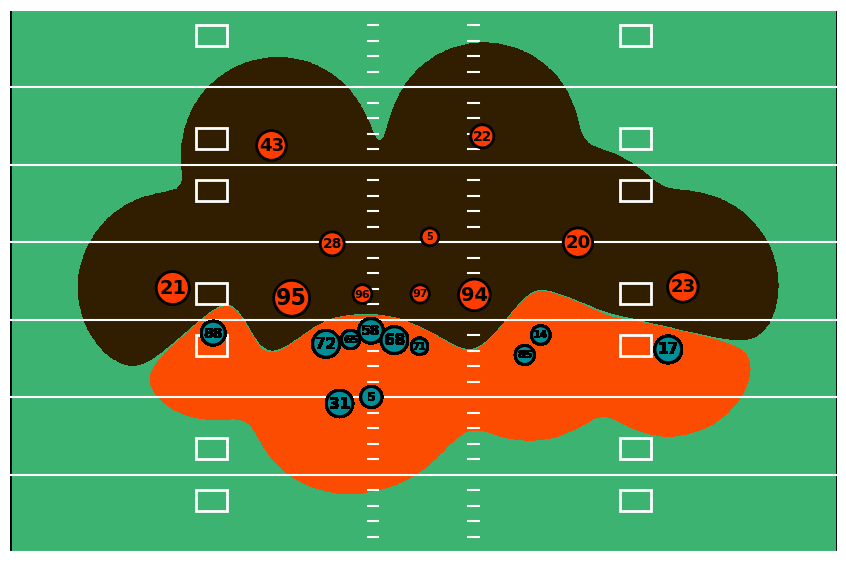

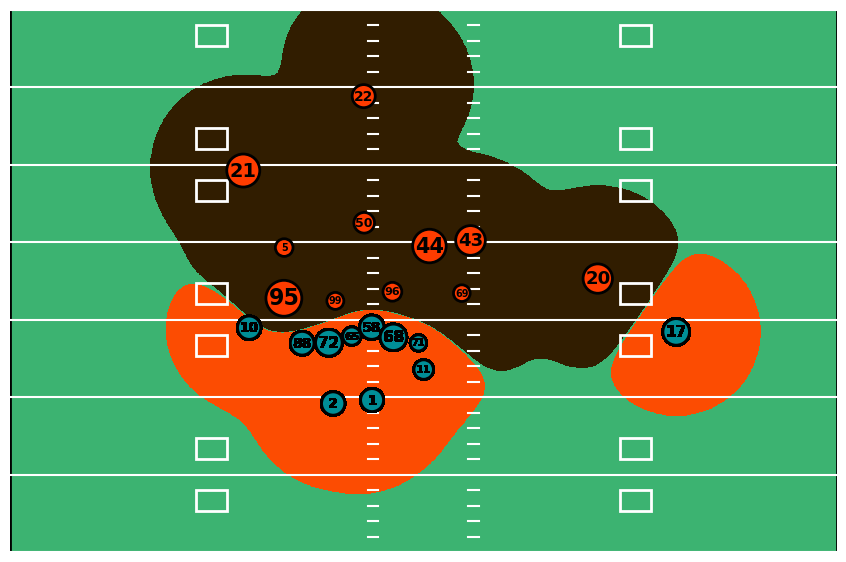

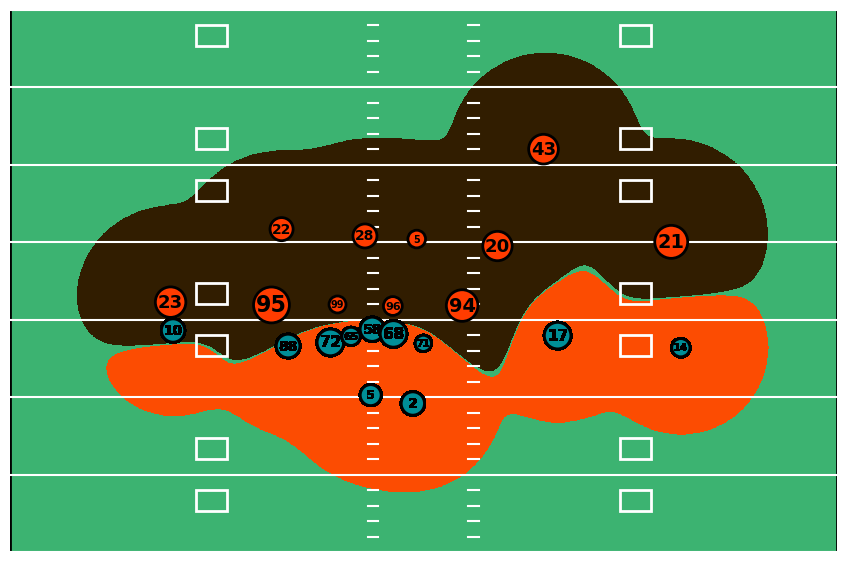

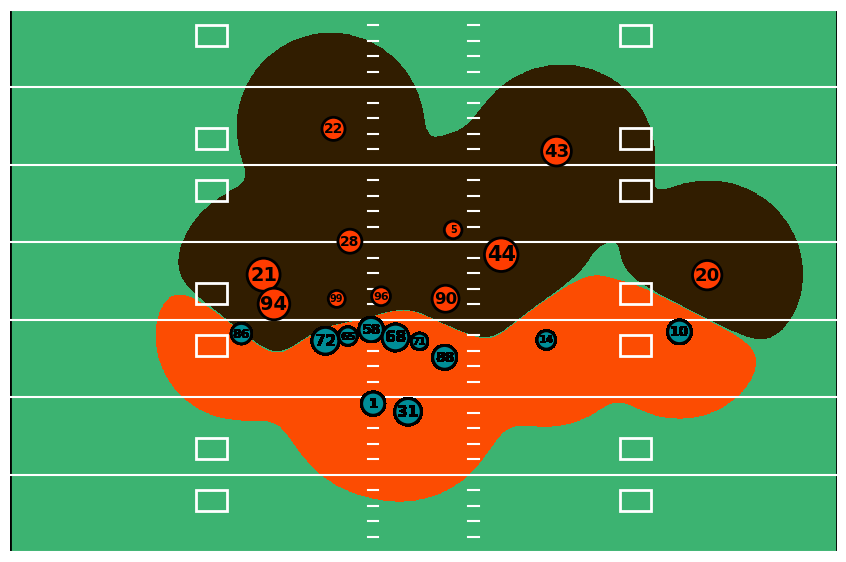

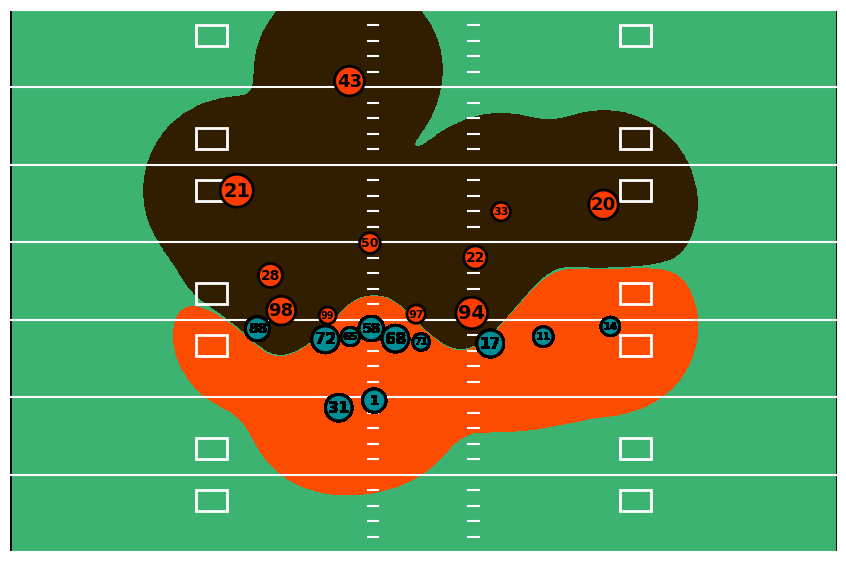

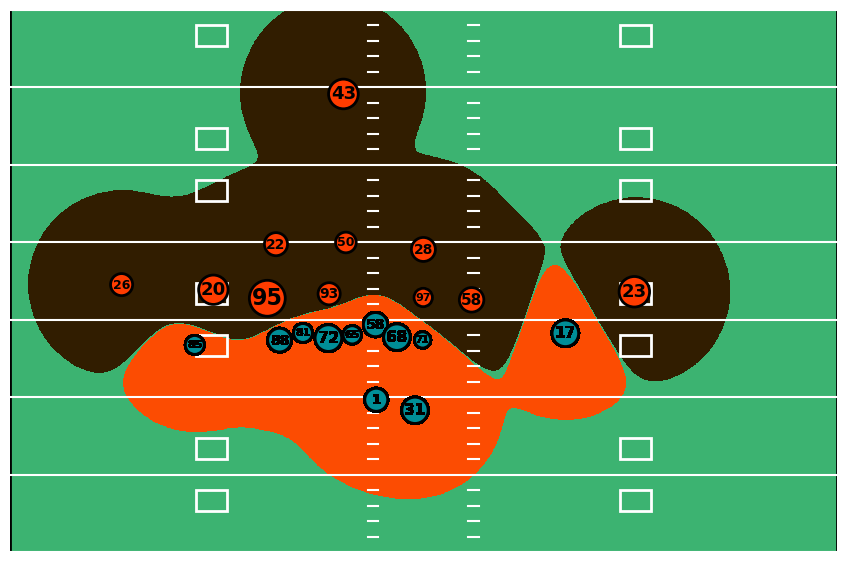

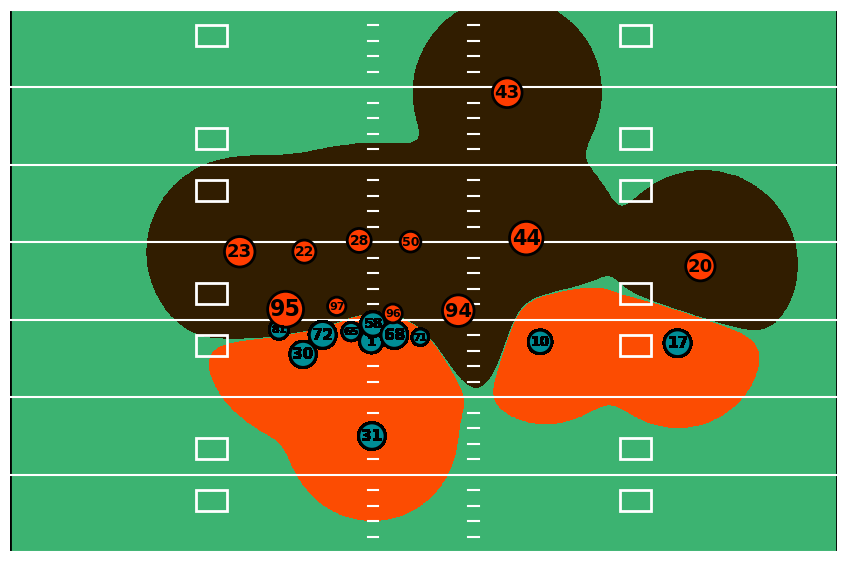

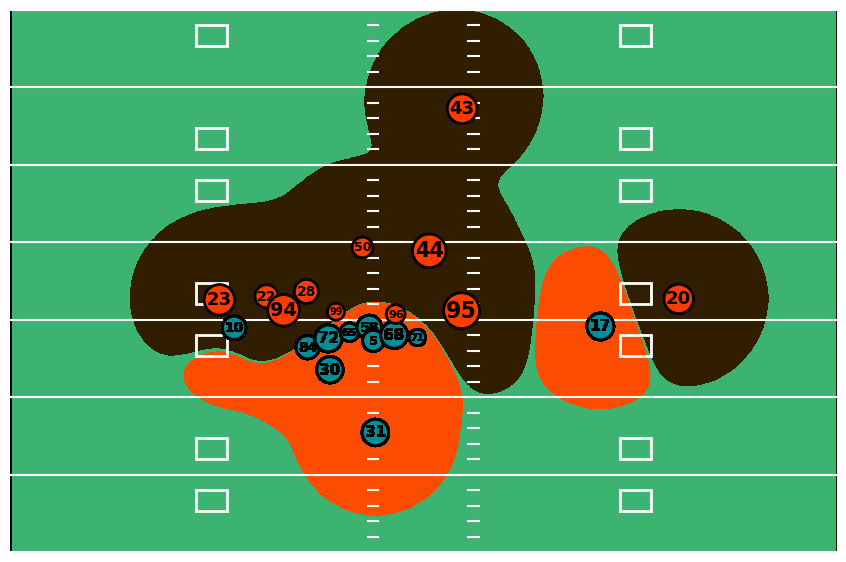

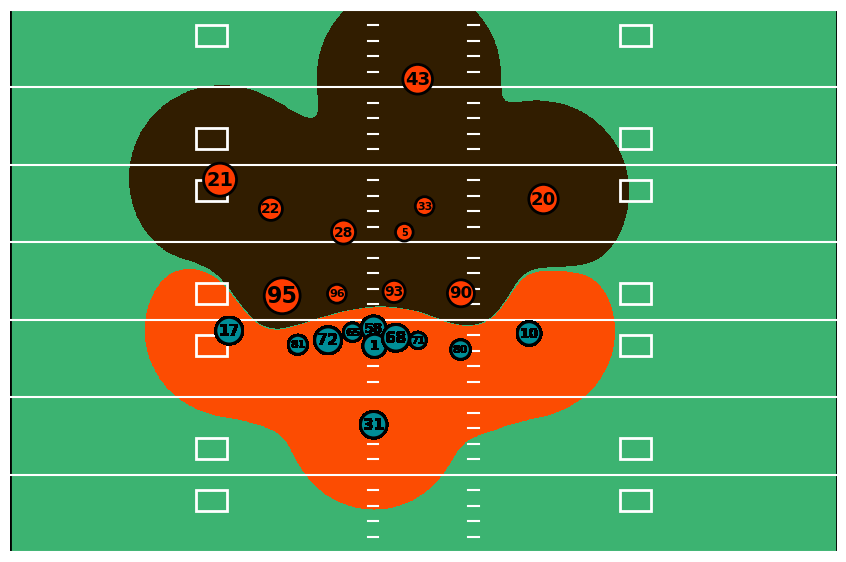

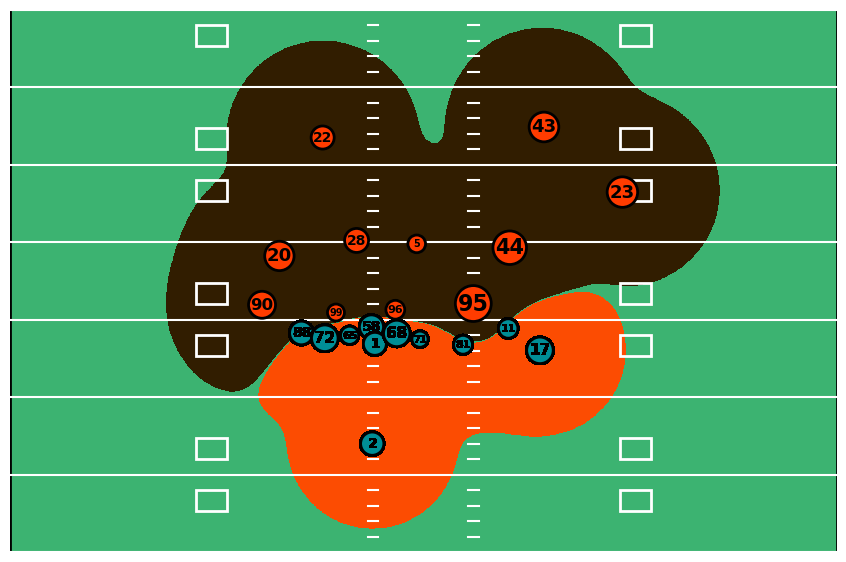

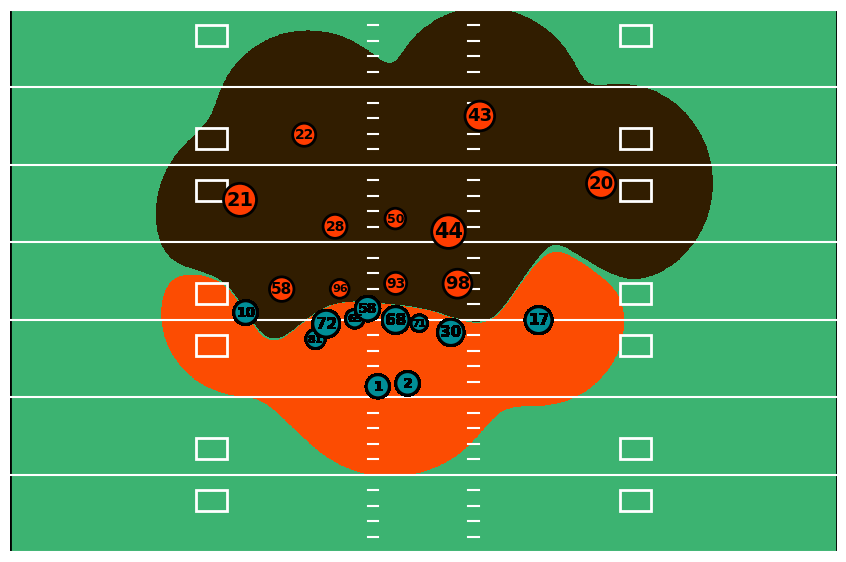

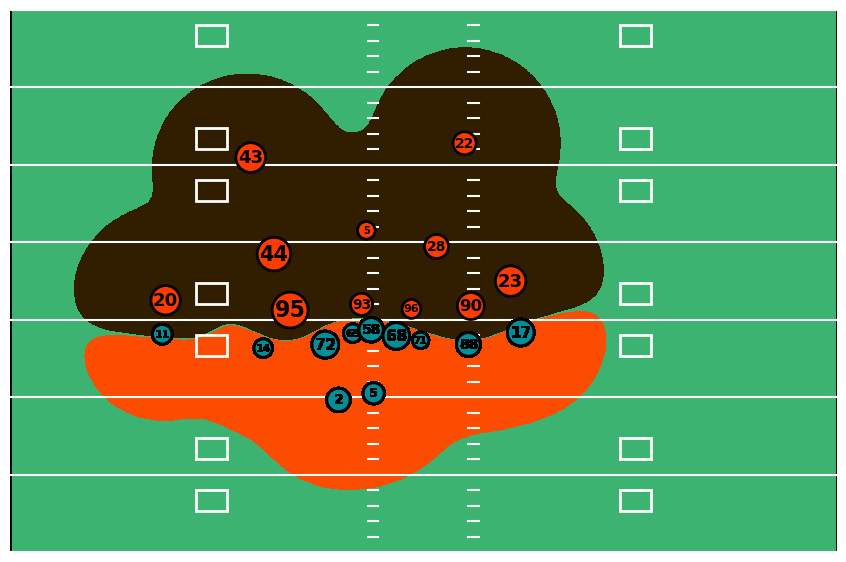

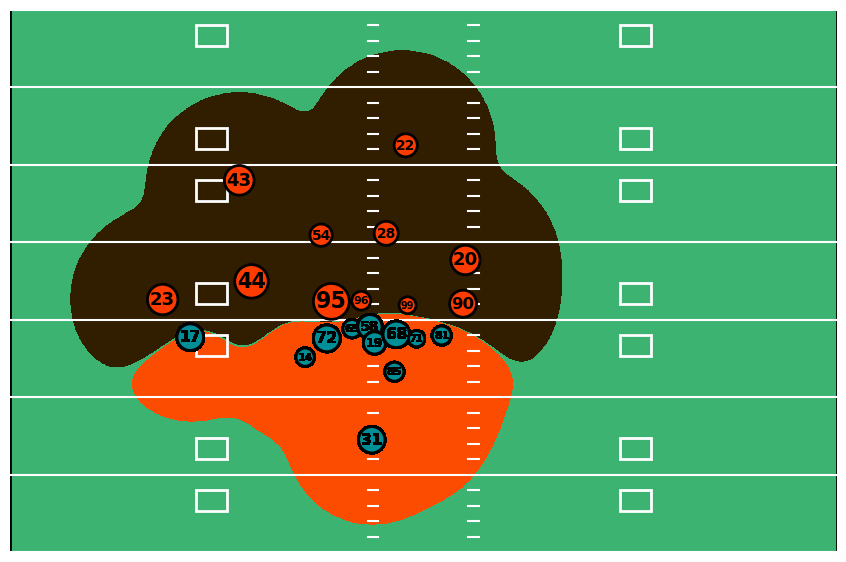

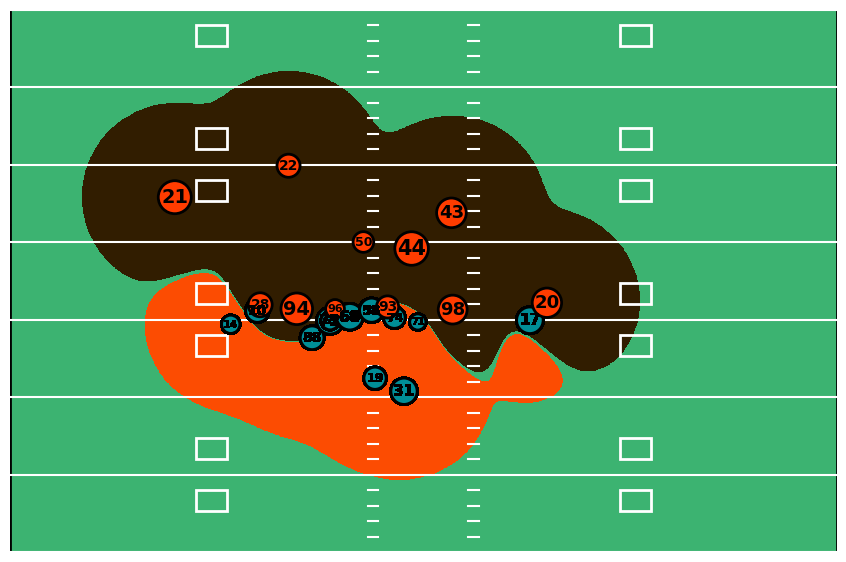

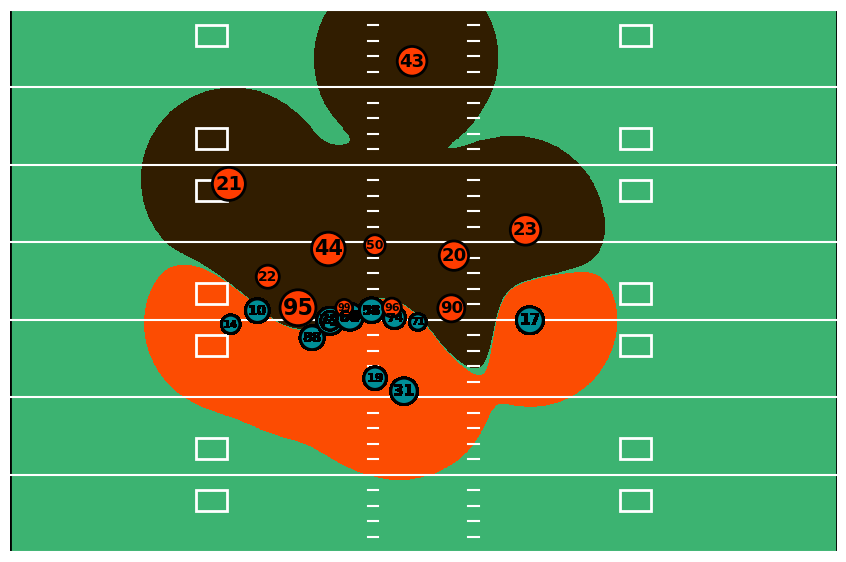

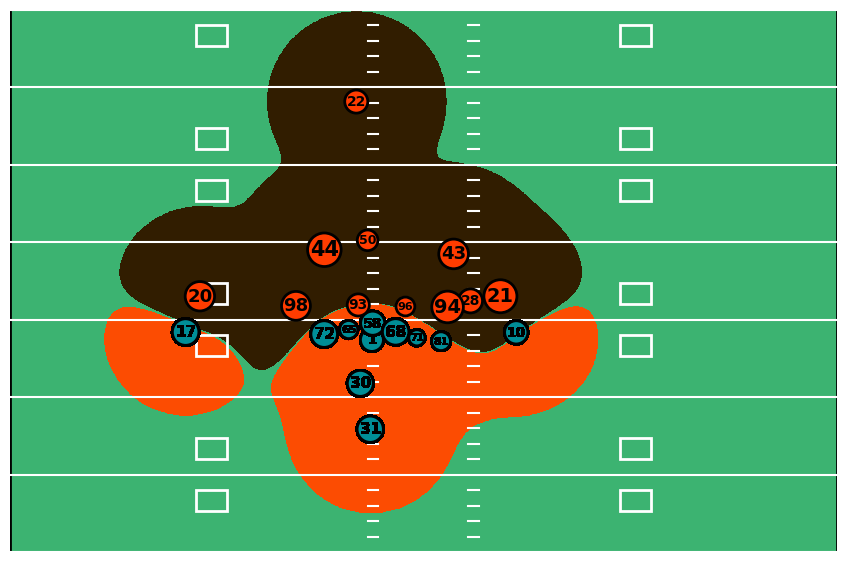

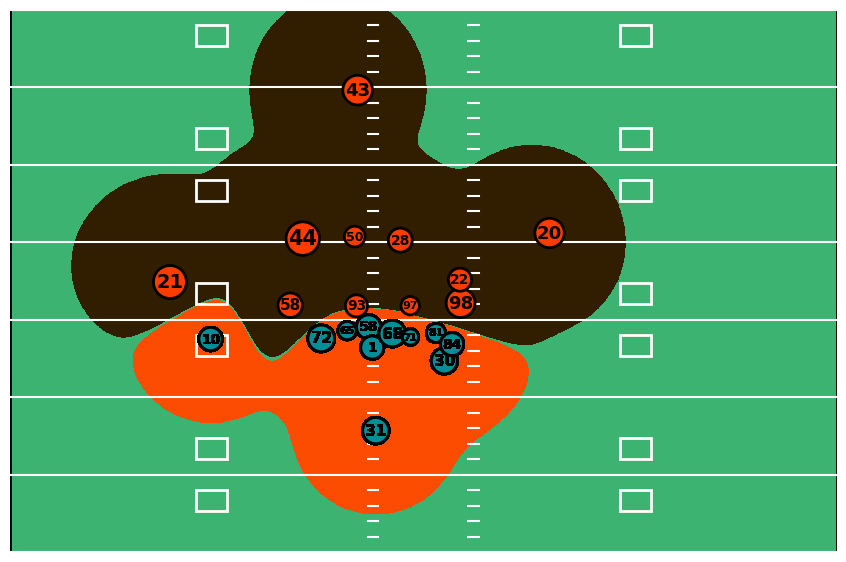

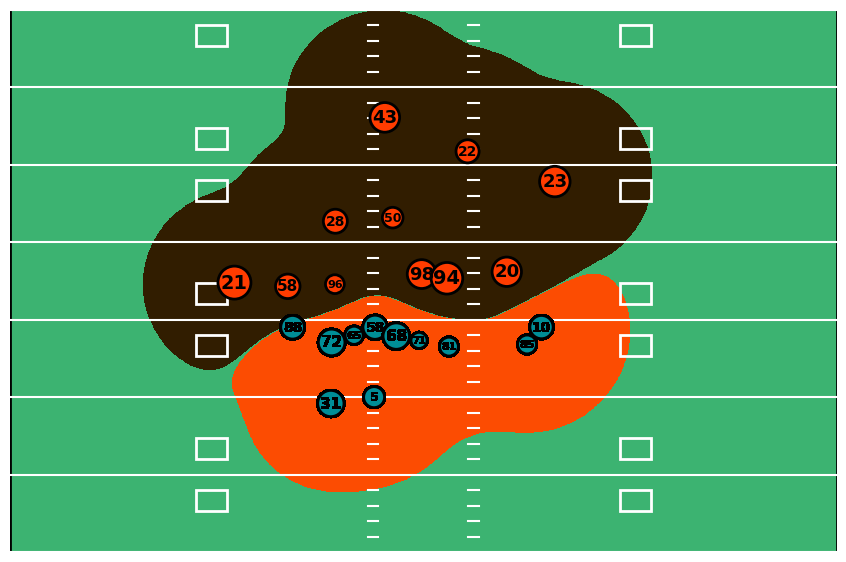

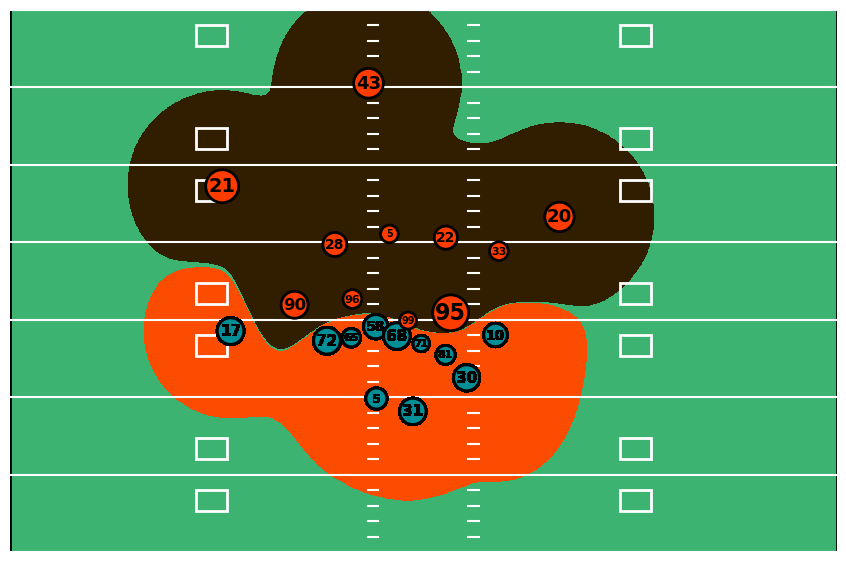

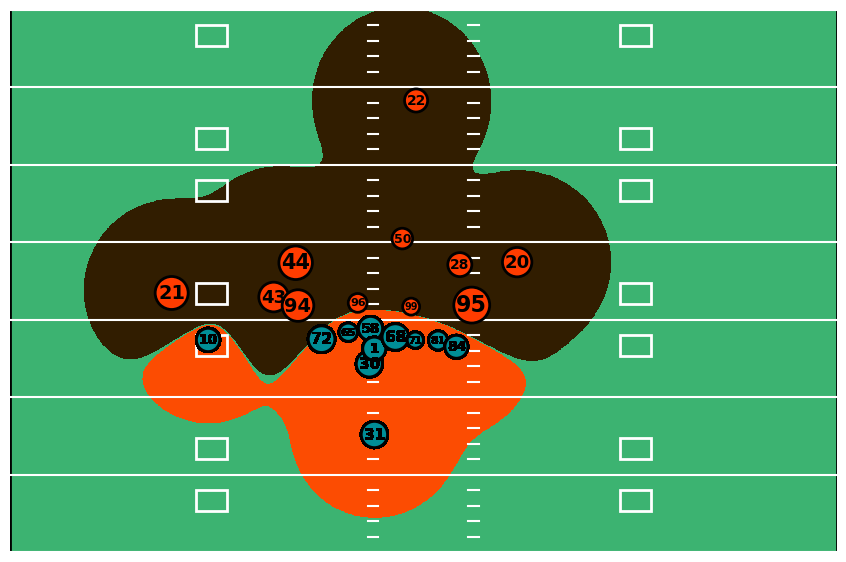

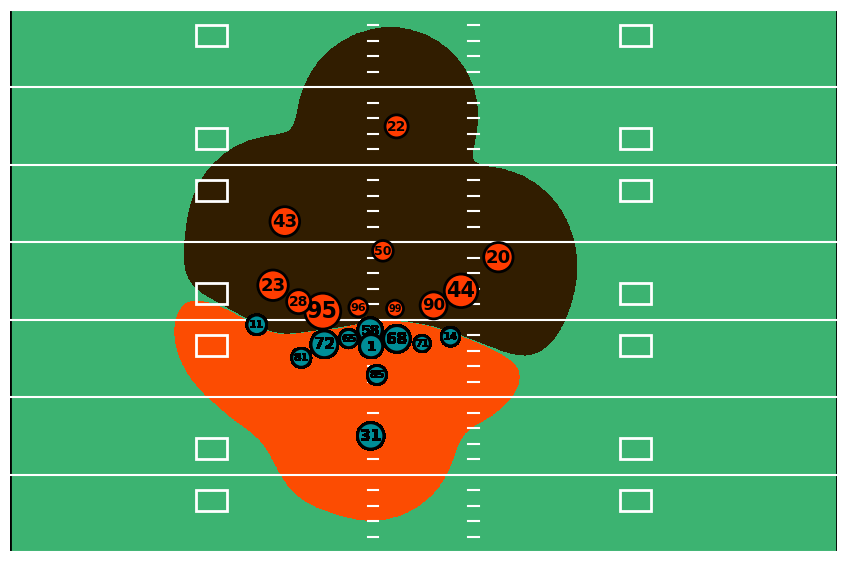

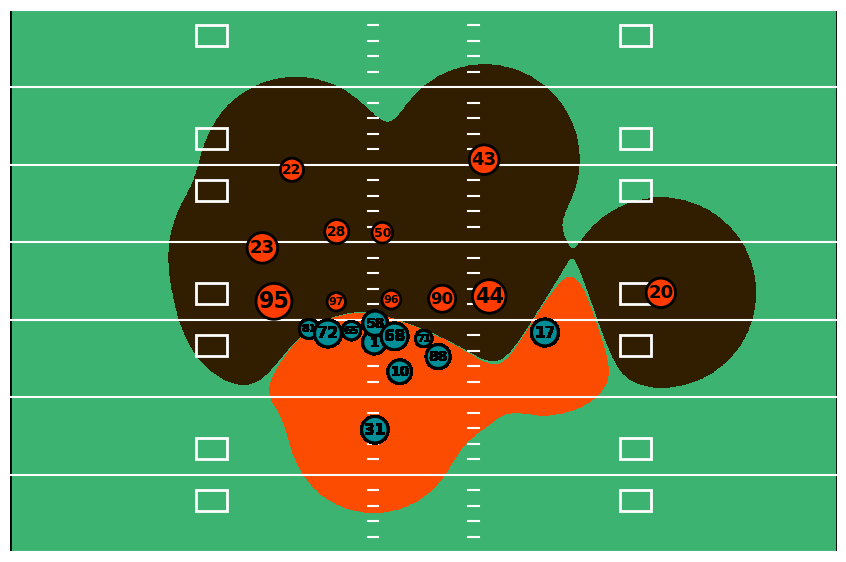

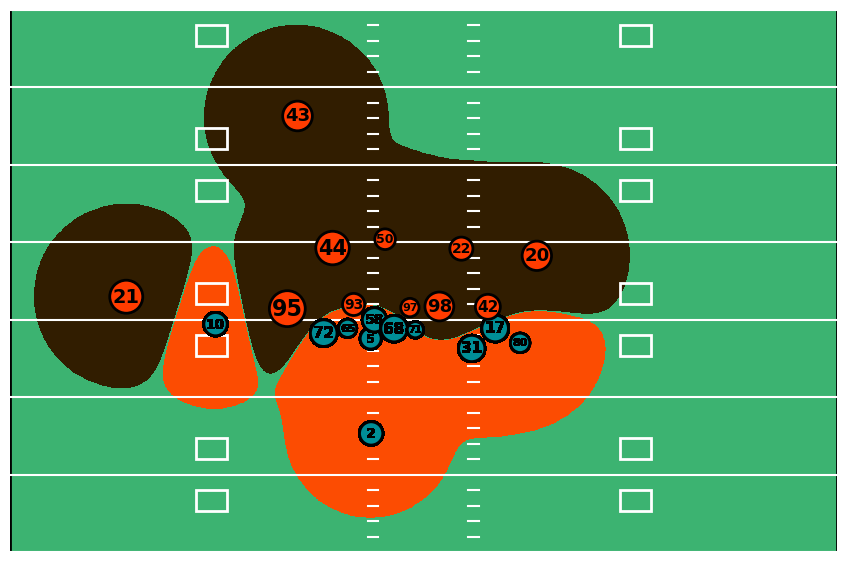

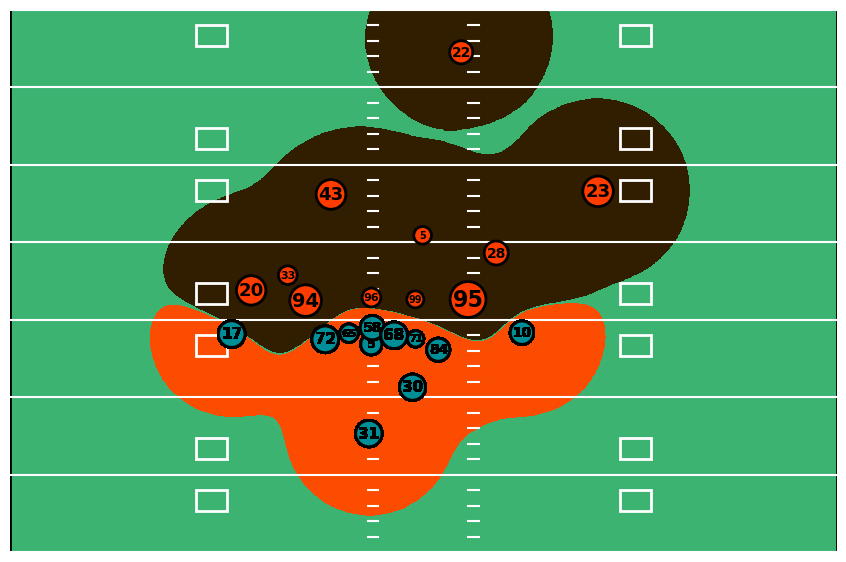

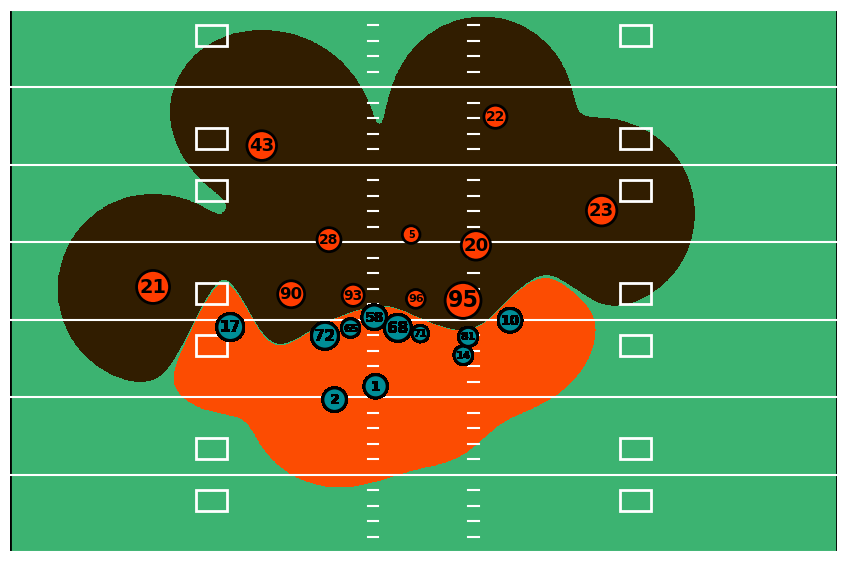

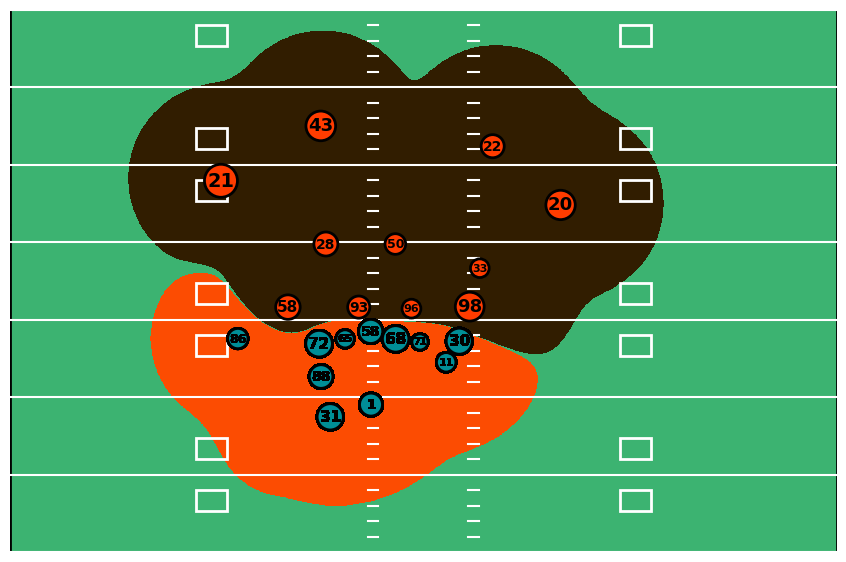

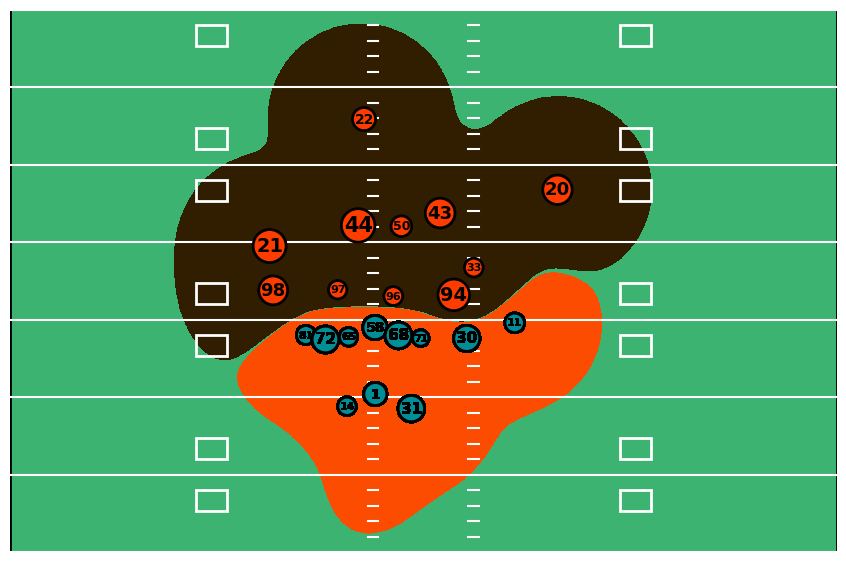

In [53]:
#5 best
var = 'Mean'
ofdf = pd.DataFrame(offensive_formations)
ofdf = ofdf.sort_values(by = 'Mean', ascending=False).reset_index(drop=True)
for hdx, h in enumerate(ofdf_mean['O_Label']):
    offensive_play = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdO'].drop_duplicates())[0]
    playlistD = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdD'].drop_duplicates())
    for idx, i in enumerate(playlistD):
        def_label = predicted_plays.loc[(predicted_plays['PlayIdD'] == i)]['D_Label'].iloc[0]
        snapo = predicted_plays.loc[(predicted_plays['PlayIdO'] == offensive_play) & (predicted_plays['PossessionTeam'] == offense) & (predicted_plays['IsOnOffense'] == True)].reset_index(drop=True)
        snapo = snapo.sort_values(by = 'Y').reset_index(drop=True)
        pos_pl = 0
        for jdx, j in enumerate(snapo['Position']):
            if (j in ['T', 'G', 'C']):
                if pos_pl == 0:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Terron Armstead')]['nflId'].iloc[0]
                elif pos_pl == 1:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Robert Jones')]['nflId'].iloc[0]
                elif pos_pl == 2:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Connor Williams')]['nflId'].iloc[0]
                elif pos_pl == 3:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Robert Hunt')]['nflId'].iloc[0]
                elif pos_pl == 4:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Brandon Shell')]['nflId'].iloc[0]
                pos_pl+=1
        snapo = pd.merge(snapo, player_number, how = 'left', on = 'NflId').reset_index(drop=True)
        snapd = predicted_plays.loc[(predicted_plays['PlayIdD'] == i) & (predicted_plays['DefensiveTeam'] == defense) & (predicted_plays['IsOnOffense'] == False)].reset_index(drop=True)
        snapd = pd.merge(snapd, player_number, how = 'left', left_on = ['PlayIdD', 'NflId'], right_on = ['PlayId', 'NflId']).reset_index(drop=True)
        snap = pd.concat([snapo, snapd]).reset_index(drop=True)
        snap = pd.merge(snap, player_space[['NflId', 'Space Factor Adj']], how = 'left', on = 'NflId').reset_index(drop=True)
        
        
        field_width = 53.33  # NFL field width
        field_length = 120  # View range: -20 to 20
        hashmark_to_sideline = 23.42  # NFL official hash mark distance from sideline
        hashmark_width = .67  # hashmark length
        number_to_sideline = 12  # NFL official hash mark distance from sideline
        number_width = 2  # hashmark length
    
        fig, ax = bdb.plt.subplots(figsize=(field_width/5, field_length/7.5))
    
        overlay_image = ppdict[i][:, :, 3]
        overlay_image = np.rot90(overlay_image)
        overlay_image = np.flip(overlay_image, axis=1)
        
        custom_cmap = ListedColormap(["#311D00", "mediumseagreen", "#FC4C02"])
        x_min, x_max, y_min, y_max = -field_width/2, field_width/2, -field_length/2, field_length/2
        ax.imshow(overlay_image, cmap=custom_cmap, extent=[x_min, x_max, y_min, y_max], zorder = 5)
    
        # Main field (excluding end zones)
        ax.add_patch(bdb.patches.Rectangle(
            (-field_width/2, -field_length/2), field_width, field_length,
            linewidth=2, edgecolor='black', facecolor='none', zorder=9))
        
        for idx, row in snap.iterrows():
            x_draw = row['X'] - (field_length / 2)# - 50
            y_draw = row['Y'] - (field_width / 2)
            #y_draw_d = 53.33 - row['Y'] - (field_width / 2)
            pos = row['Position']
            team = row['PossessionTeam']
            size = row['Space Factor Adj']
            if str(size) == 'nan':
                size = .7
            jersey_number = int(row['JerseyNumber'])
            if team == offense:
                if pos in ['T', 'G', 'C']:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#008E97', edgecolor='black', lw=2)).set_zorder(10)
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
                else:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#008E97', edgecolor='black', lw=2)).set_zorder(10)
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
            else:
                if pos in ['DT', 'DE', 'NT']:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#FF3C00', edgecolor='black', lw=2)).set_zorder(10)
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
                else:
                    ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .5 + size, facecolor='#FF3C00', edgecolor='black', lw=2)).set_zorder(10)   
                    ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=int(7 + 14*size), zorder=11, weight='bold')
            
        for yard in range(int((-field_length/2)), int((field_length/2)), 1):
            linestyle = '-' #if yard % 10 == 0 else '--'
            y_position = yard
            if yard % 5 == 0:
                ax.plot([-field_width/2, field_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
            else:
                ax.plot([-field_width/2 + hashmark_to_sideline - hashmark_width/2, -field_width/2 + hashmark_to_sideline + hashmark_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
                ax.plot([field_width/2 - hashmark_to_sideline + hashmark_width/2, field_width/2 - hashmark_to_sideline - hashmark_width/2], [y_position, y_position], color='white', linestyle=linestyle, zorder=9)
    
            number_offset = number_width / 2  # Half the height of the number box
    
            if (yard % 10 == 0) & (yard != int(-field_length/2)) & (yard != int((field_length/2))):
                # Left numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                
                # Right numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='white', facecolor='None', label="End Zone", zorder=9))
    
        ax.set_xlim(-field_width/2, field_width/2)
        ax.set_ylim(-field_length/2, field_length/2)
        bdb.plt.gca().set_facecolor('green')
        bdb.plt.axis('off')
        #bdb.plt.title(str(i))
        bdb.plt.ylim(-15, 20) 
        bdb.plt.savefig(prefix + '/testfig/best/testfig-O' + str(h) + '-D' + str(def_label) + '-' + str(i)+  '.jpg', bbox_inches="tight", pad_inches = 0, dpi = 600)
        bdb.plt.show()

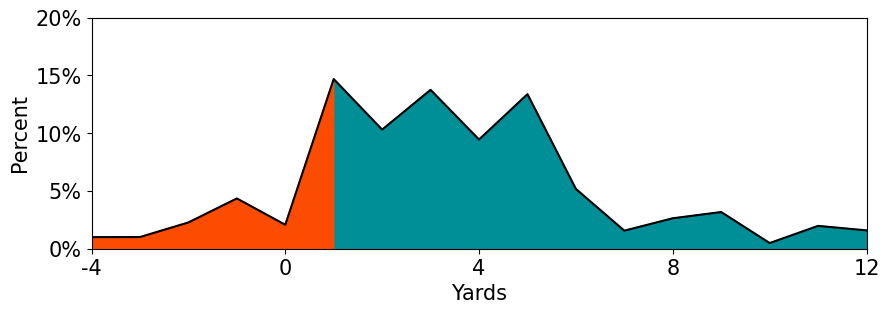

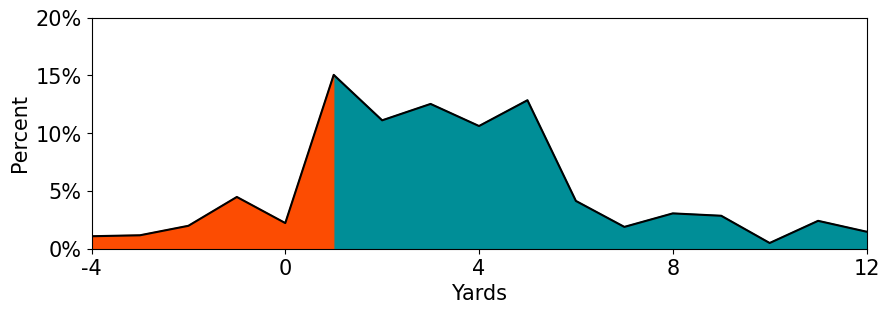

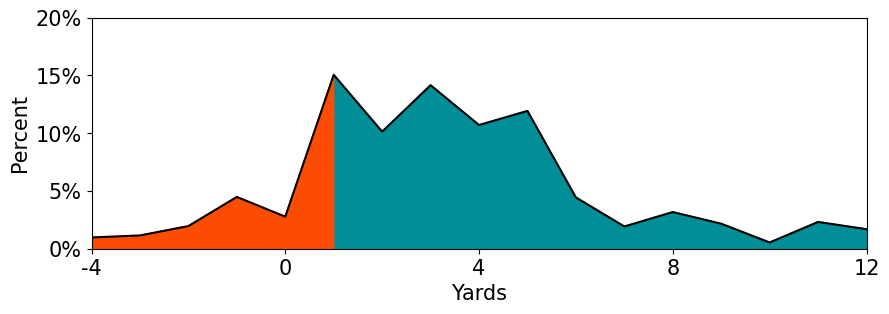

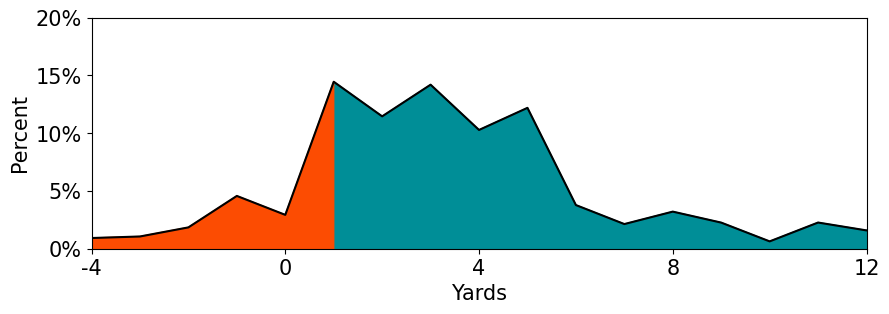

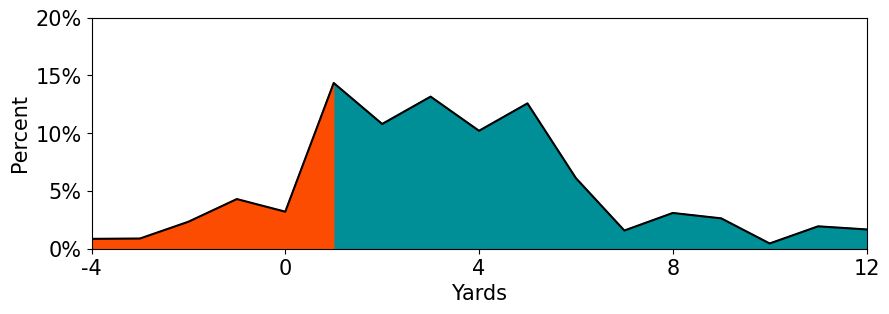

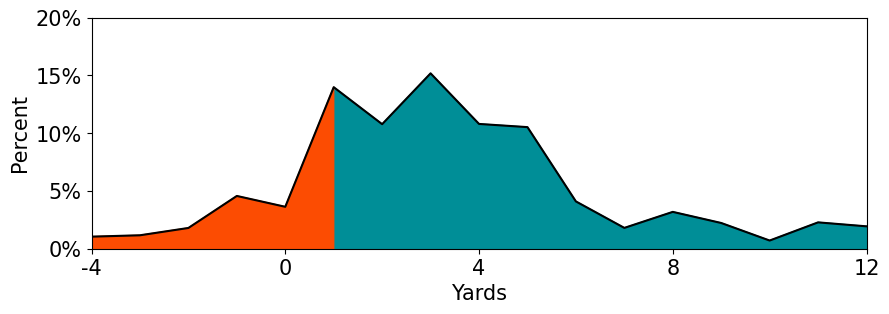

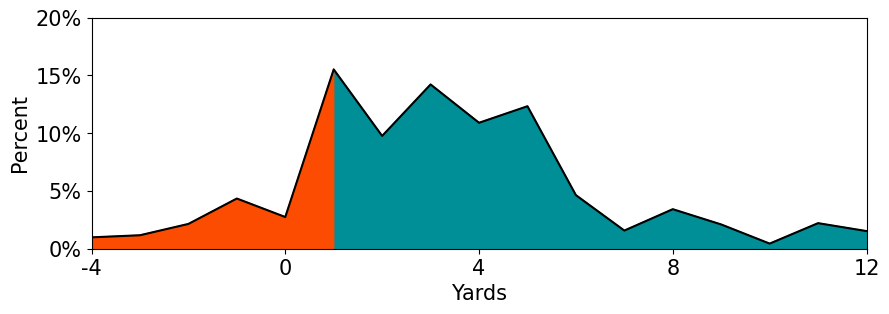

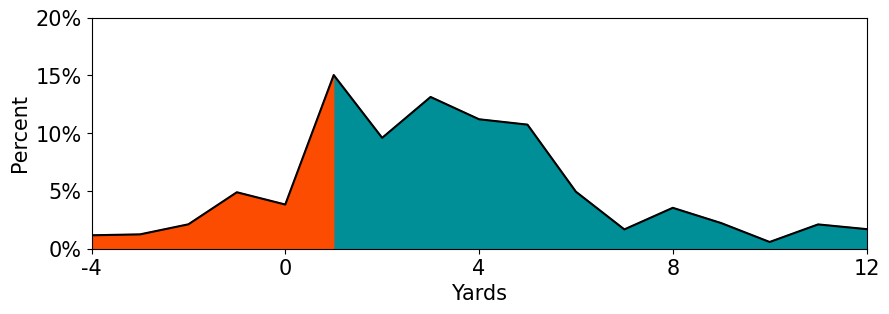

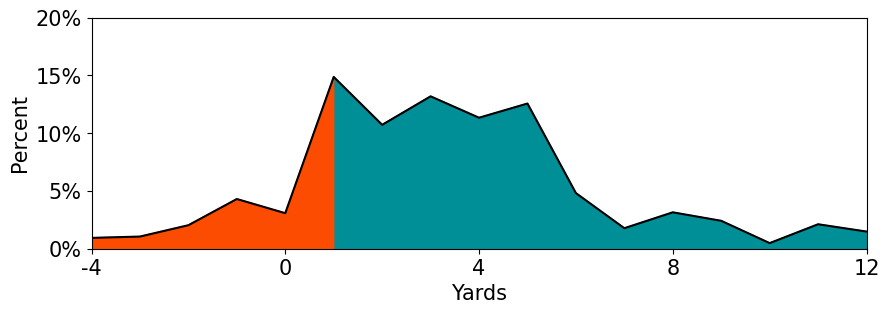

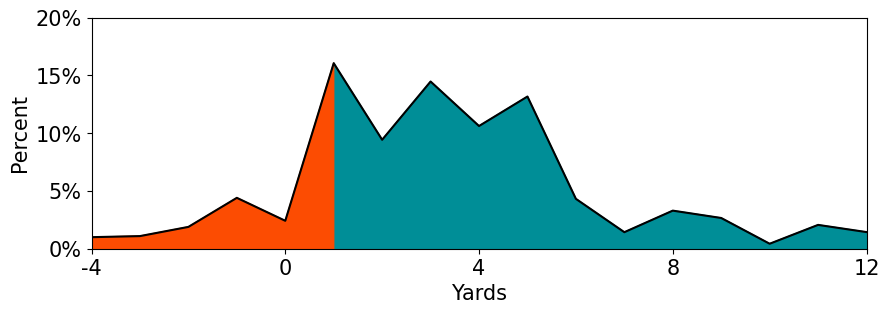

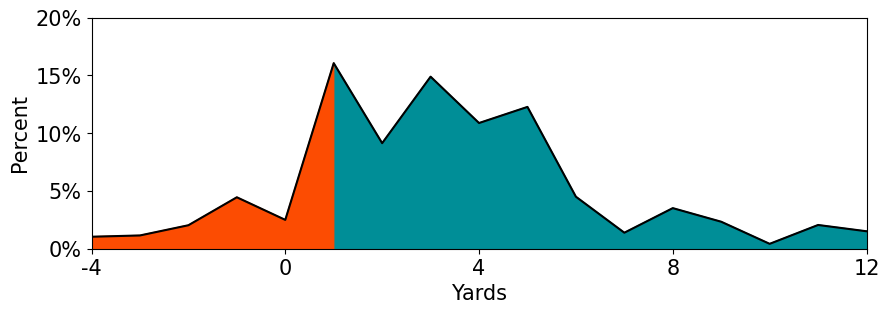

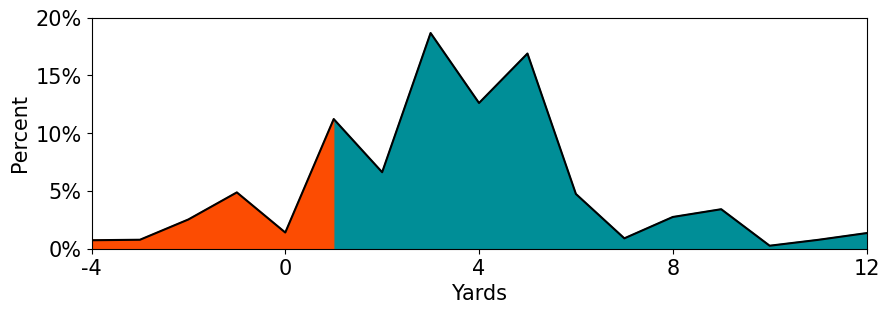

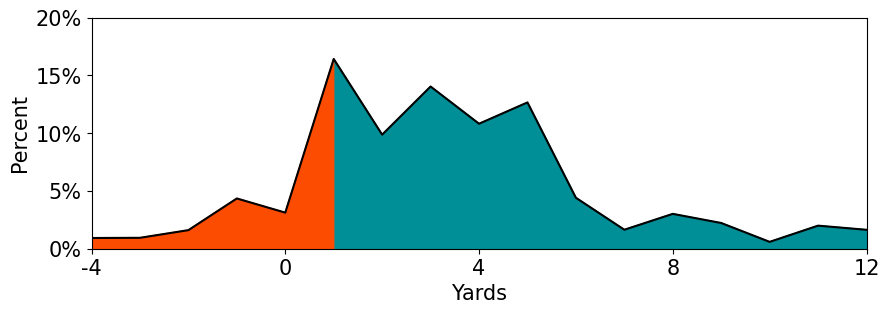

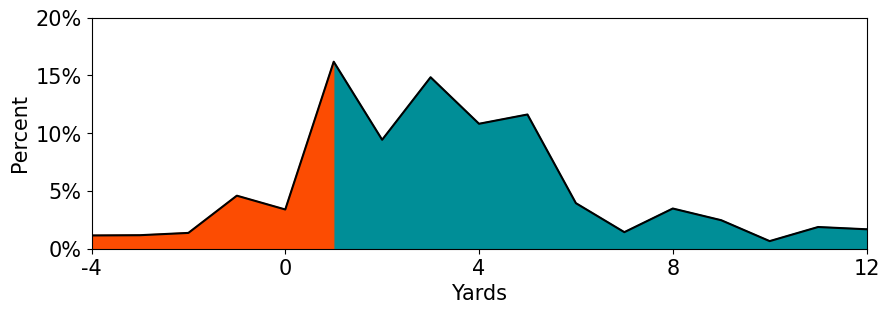

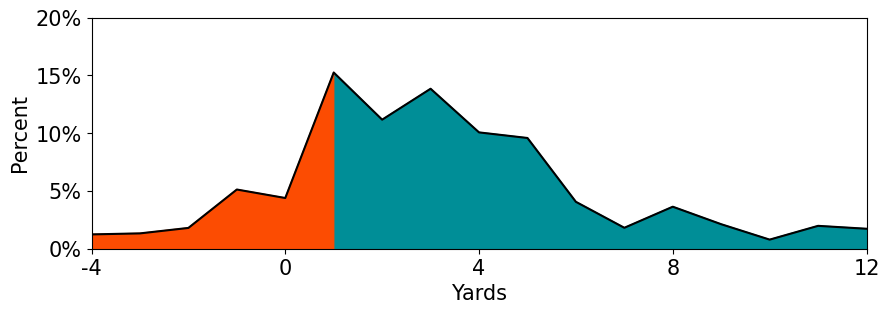

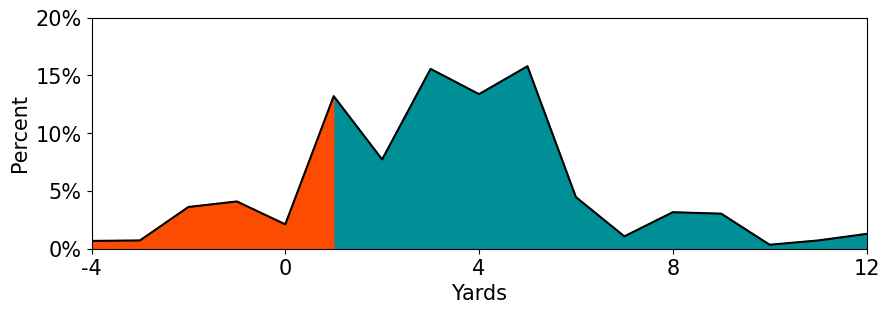

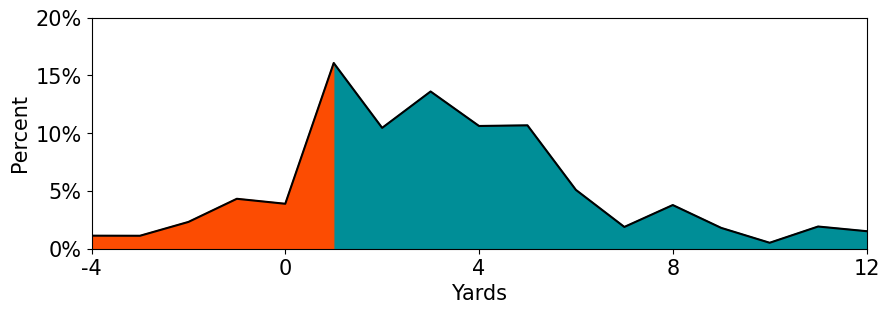

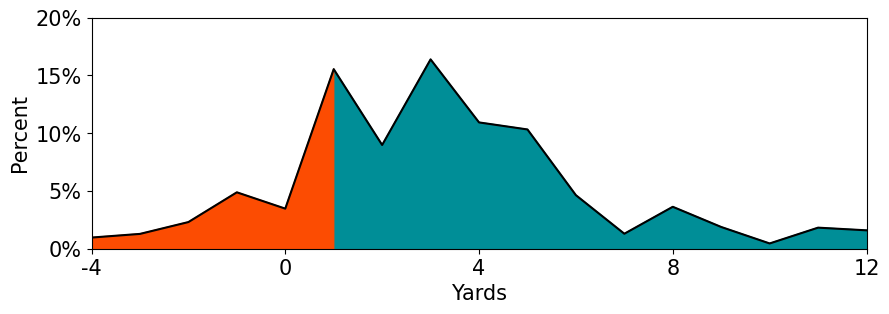

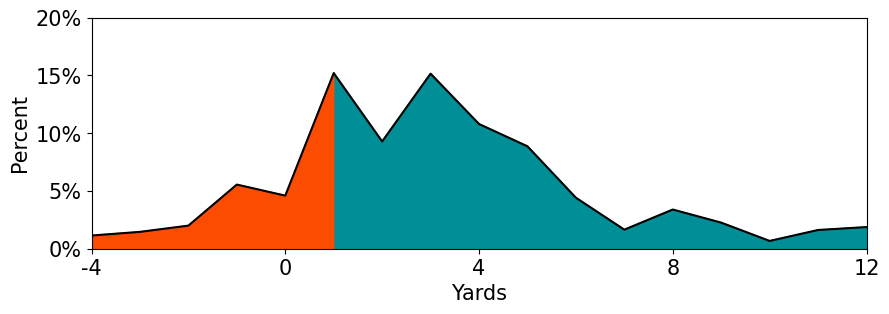

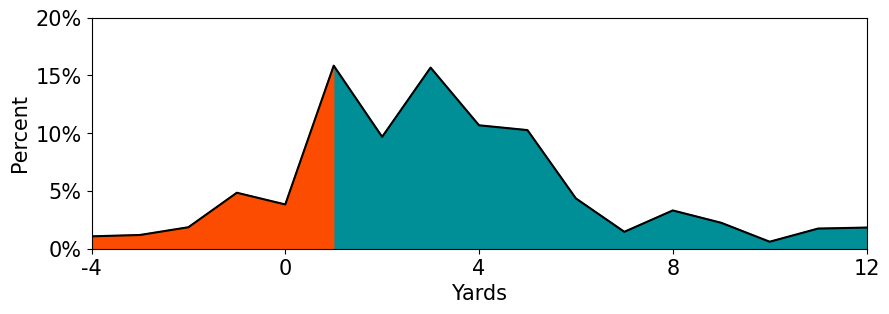

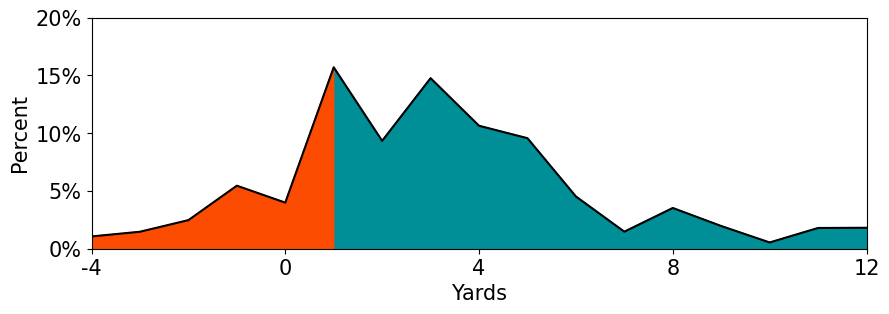

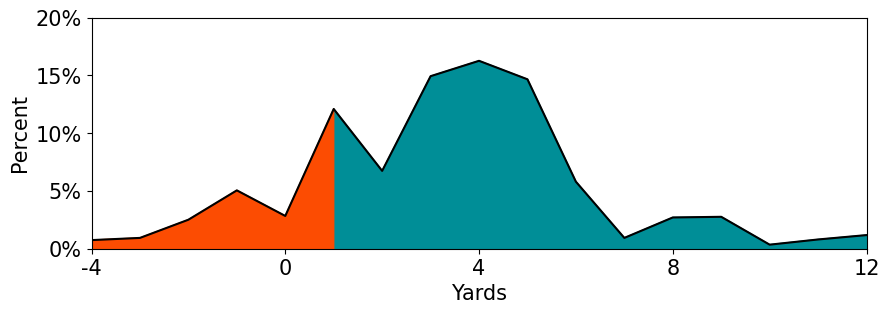

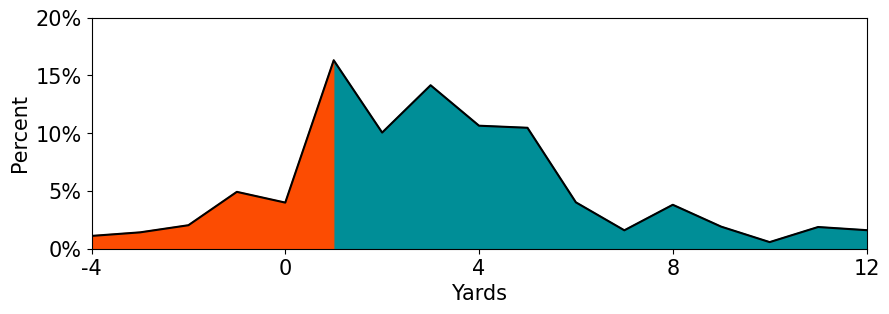

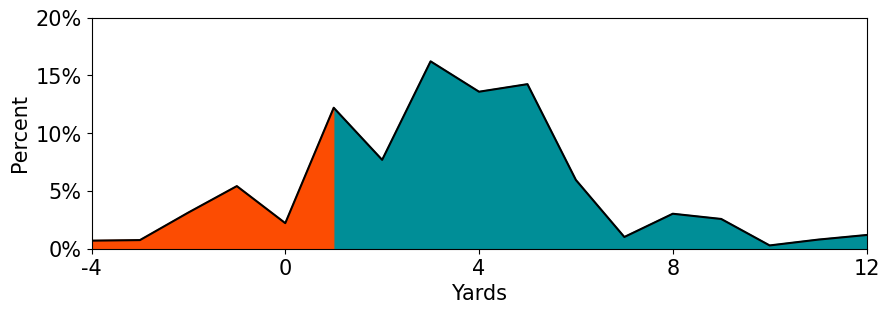

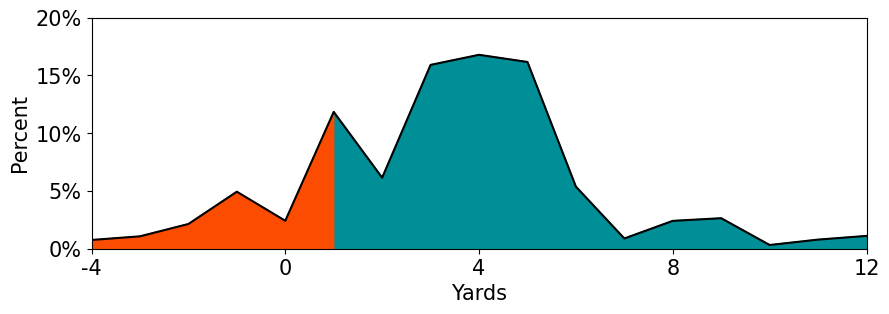

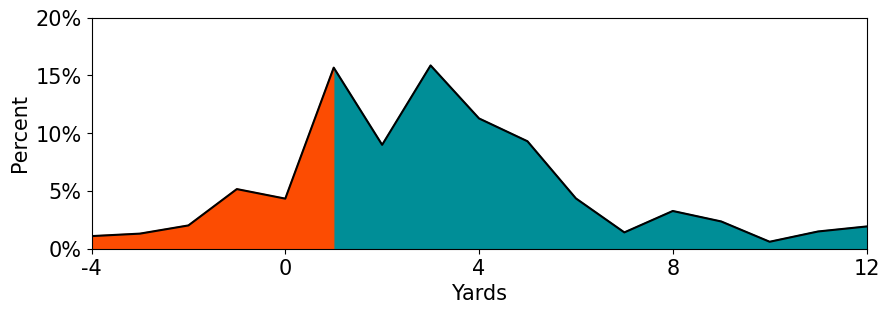

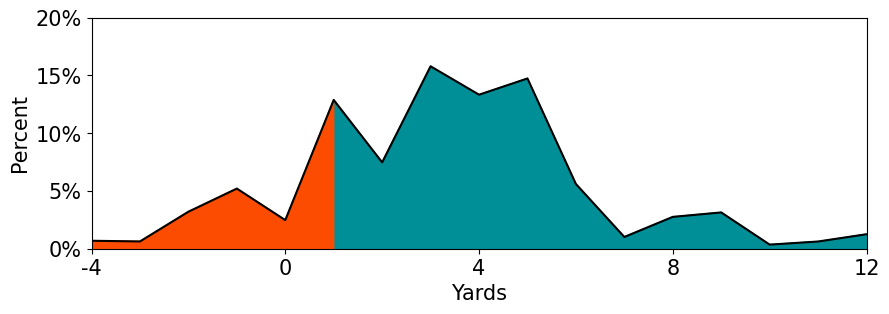

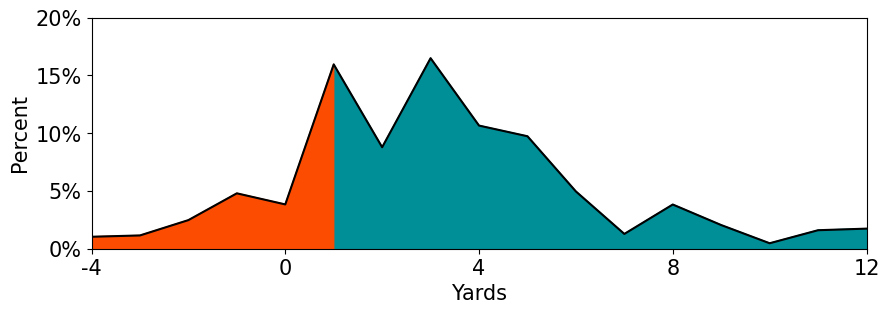

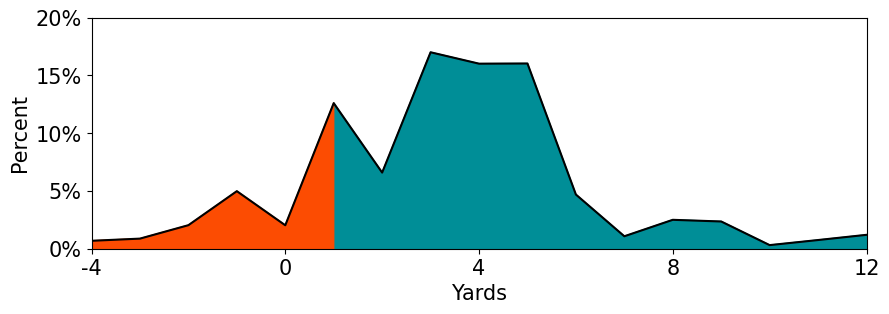

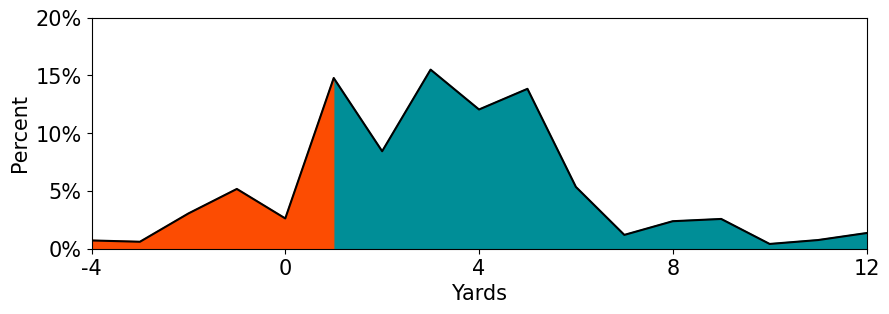

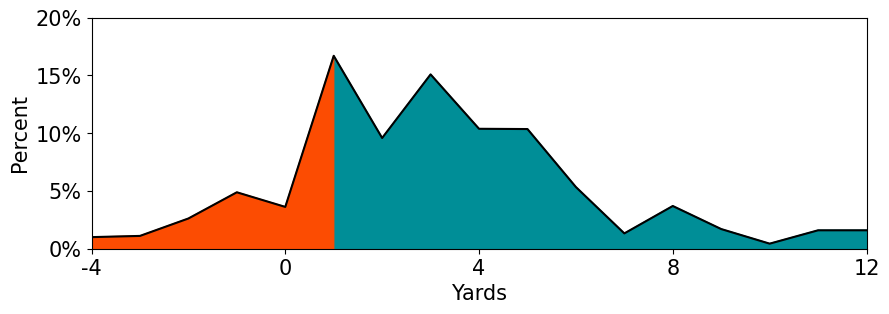

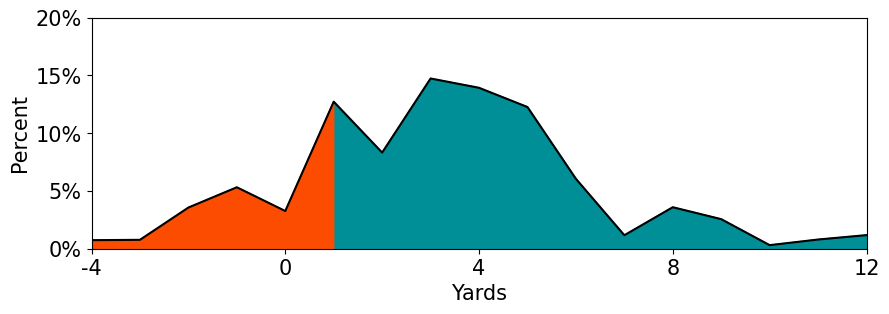

In [63]:
for i in range(len(ofdf_mean)):
    bdb.plt.figure(figsize=(10, 3))  # Optional: Set figure size01
    bdb.plt.ylim([0, .2])
    bdb.plt.xlim([95, 111])
    new_x_ticks = [95, 99, 103, 107, 111]
    new_x_labels = [-4, 0, 4, 8, 12]
    new_y_ticks = [0, .05, .1, .15, .2]
    new_y_labels = ['0%', '5%', '10%', '15%', '20%']
    bdb.plt.xlabel("Yards", fontsize=15)  # X-axis label font size
    bdb.plt.ylabel("Percent", fontsize=15)  # Y-axis label font size
    bdb.plt.xticks(fontsize=15)  # X-tick labels font size
    bdb.plt.yticks(fontsize=15)
    bdb.plt.xticks(new_x_ticks, new_x_labels)
    bdb.plt.yticks(new_y_ticks, new_y_labels)
    y_values = ofdf_mean['Prediction'].iloc[i][0].reshape(-1,)
    x_values = np.array(range(len(y_values)))
    bdb.plt.plot(x_values, y_values, color='black')
    bdb.plt.fill_between(x_values, y_values, 0, where=(x_values >= 100), alpha=1, color='#008E97')
    bdb.plt.fill_between(x_values, y_values, 0, where=(x_values <= 100), alpha=1, color='#FC4C02')# alpha controls the transparency
    bdb.plt.savefig(prefix + '/testfig/line_charts/testfig-O-' + str(ofdf_mean['O_Label'].iloc[i]) + '-D' + str(def_label) + '-' + str(i)+  '.jpg', bbox_inches="tight", pad_inches = 0, dpi = 600)
    bdb.plt.show()

In [56]:
ofdf_mean

O_Label  \
0         2   
1        15   
2         8   
3        25   
4         9   
5         0   
6        22   
7        32   
8        20   
9        35   
10       27   
11       31   
12       34   
13       17   
14       18   
15       21   
16       13   
17        6   
18       19   
19        1   
20       11   
21       14   
22        5   
23       23   
24        3   
25       29   
26        4   
27       36   
28       10   
29       12   
30       33   
31       26   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Prediction  \
0   [[5.6843714e-05, 5.1424126e-05, 6.851252e-05, 2.8548013e-05, 4.076476e-05, 5.6540568e-05, 4.5347842e-05, 4.677565e-05, 4.4885102e-05, 5.539251e-05, 3.9193517e-05, 4.510234e-05, 3.9984683e-05, 4.495926e-05, 5.3225725e-05, 4.5496858e-05, 6.375383e-05, 4.8050046e-05, 4.750538e-05, 6.8528265e-05, 3.9281116e-05, 4.3873984e-05, 3.5082758e-05, 4.477458e-05, 5.0307262e-05, 2.9249068e-05, 3.8886654e-05, 3.3796852e-05, 6.4191634e-05, 3.9128012e-05, 3.3560398e-05, 3.6754773e-05, 3.7788963e-05, 4.708734...   
1   [[4.9128244e-05, 4.199821e-05, 5.0883453e-05, 2.185723e-05, 3.520351e-05, 4.078502e-05, 3.6067424e-05, 3.3628603e-05, 3.3921297e-05, 4.144736e-05, 3.129166e-05, 3.5375553e-05, 3.141e-05, 3.455252e-05, 4.3336207e-05, 3.834886e-05, 4.9028968e-05, 3.6382142e-05, 4.056577e-05, 5.878341e-05, 2.8661005e-05, 3.364509e-05, 3.0069574e-05, 3.5473797e-05, 4.174926e-05, 2.2259754e-05, 2.9580247e-05, 2.677907e-05, 4.5593148e-05, 3.110057e-05, 2.5097324e-05, 2.5762953e-05, 2.9099245e-05, 3.739811e-05, 4.9...   
2   [[6.085523e-05, 5.663537e-05, 7.209006e-05, 3.2576285e-05, 4.2077114e-05, 5.215266e-05, 4.836179e-05, 4.2289845e-05, 4.45811e-05, 5.278408e-05, 4.166665e-05, 4.4208486e-05, 3.5649067e-05, 4.9271315e-05, 5.6282053e-05, 4.316986e-05, 6.099764e-05, 5.052429e-05, 4.4395947e-05, 7.4468015e-05, 4.0410327e-05, 4.6317462e-05, 3.7520473e-05, 4.5429486e-05, 5.4435226e-05, 3.1649233e-05, 3.64252e-05, 3.6152145e-05, 4.9337566e-05, 4.5119214e-05, 3.173592e-05, 3.4876837e-05, 4.060909e-05, 4.4085922e-05, ...   
3   [[5.0332124e-05, 4.857823e-05, 6.2833846e-05, 2.4536339e-05, 3.6303503e-05, 3.941775e-05, 3.9785067e-05, 3.459166e-05, 4.0509833e-05, 4.3390803e-05, 3.1642743e-05, 3.4332414e-05, 3.0841922e-05, 3.9720166e-05, 4.9347833e-05, 3.6001824e-05, 4.8275473e-05, 3.6373647e-05, 3.9155933e-05, 6.0056675e-05, 3.3730907e-05, 3.855542e-05, 2.8706603e-05, 3.6783807e-05, 4.1455707e-05, 2.4636602e-05, 2.9804203e-05, 2.9473473e-05, 4.2025415e-05, 3.8368427e-05, 2.4656842e-05, 2.7343489e-05, 2.993641e-05, 3.70...   
4   [[6.268064e-05, 5.356556e-05, 6.513459e-05, 3.3730834e-05, 4.2255157e-05, 6.293233e-05, 4.9964696e-05, 5.1600528e-05, 4.2043805e-05, 5.3624954e-05, 4.4079483e-05, 4.970368e-05, 3.8105027e-05, 5.0308237e-05, 4.7239355e-05, 4.3269636e-05, 6.523421e-05, 4.951774e-05, 4.822167e-05, 7.138619e-05, 4.2104195e-05, 4.4134544e-05, 3.796824e-05, 4.6534533e-05, 4.851518e-05, 2.959161e-05, 3.649086e-05, 3.8656992e-05, 5.686346e-05, 4.4271714e-05, 3.514701e-05, 3.8188955e-05, 4.0544568e-05, 4.9300146e-05,...   
5   [[5.312606e-05, 5.8939797e-05, 7.3296134e-05, 3.270574e-05, 3.6926784e-05, 4.4623153e-05, 4.413193e-05, 3.6984446e-05, 4.7992147e-05, 4.818982e-05, 3.5403562e-05, 4.1819352e-05, 3.079046e-05, 4.9160666e-05, 4.9820064e-05, 4.0388662e-05, 5.3876498e-05, 4.4852826e-05, 3.8696613e-05, 6.991812e-05, 3.9901908e-05, 4.3796346e-05, 3.1384905e-05, 4.5396126e-05, 4.4840675e-05, 3.119e-05, 3.393252e-05, 3.2862754e-05, 3.9140286e-05, 4.6165573e-05, 2.972818e-05, 3.07375

In [84]:
predicted_plays.loc[(predicted_plays['O_Label'] == 2)]

GameId          PlayId  Team          X          Y     S     A   Dis  \
132  2022091101  20220911011338  away  60.769998  17.520001  0.39  2.05  0.04   
133  2022091101  20220911011338  away  73.919998  21.560001  0.04  0.04  0.02   
134  2022091101  20220911011338  away  64.399998  19.210001  0.17  0.19  0.15   
135  2022091101  20220911011338  away  59.779998  30.590001  0.13  0.91  0.01   
136  2022091101  20220911011338  away  67.839998  13.540001  0.02  0.05  0.00   
137  2022091101  20220911011338  away  59.919998  26.560001  0.34  0.56  0.11   
138  2022091101  20220911011338  away  65.539998  34.700001  0.39  0.59  0.04   
139  2022091101  20220911011338  away  64.479998  28.840001  0.19  0.97  0.02   
140  2022091101  20220911011338  away  64.879998  24.350001  0.01  0.09  0.00   
141  2022091101  20220911011338  away  63.199998  45.020001  0.16  0.40  0.03   
142  2022091101  20220911011338  away  60.869998  21.950001  0.37  1.23  0.04   
143  2022103003  20220911011338  away  58.500000  26.600001  0.28  1.37  0.02   
144  2022103003  20220911011338  away  58.420000  20.300001  0.42  1.95  0.03   
145  2022103003  20220911011338  away  59.510000  14.770001  0.16  1.34  0.01   
146  2022103003  20220911011338  away  58.060000  13.640001  0.03  0.67  0.01   
147  2022103003  20220911011338  away  59.240000  23.570001  0.62  1.41  0.06   
148  2022103003  20220911011338  away  58.550000  42.040001  0.00  0.00  0.00   
149  2022103003  20220911011338  away  57.830000  37.320001  1.00  1.92  0.11   
150  2022103003  20220911011338  away  54.780000  23.380001  0.00  0.00  0.00   
151  2022103003  20220911011338  away  58.710000  22.050001  0.33  1.09  0.03   
152  2022103003  20220911011338  away  59.070000  31.370001  0.00  0.00  0.01   
153  2022103003  20220911011338  away  58.930000  25.050001  0.41  1.37  0.04   

          Dir    NflId Position  YardLine  Quarter  GameClock PossessionTeam  \
132 -3.541099  41227.0      OLB        25        2   0.667574            CAR   
133 -5.520302  44903.0       SS        25        2   0.667574            CAR   
134 -1.913404  44974.0      MLB        25        2   0.667574            CAR   
135 -5.810899  45038.0       DE        25        2   0.667574            CAR   
136 -3.637615  46073.0       CB        25        2   0.667574            CAR   
137 -1.999624  46098.0       DT        25        2   0.667574            CAR   
138 -2.251475  46162.0       DB        25        2   0.667574            CAR   
139 -2.122320  52452.0       SS        25        2   0.667574            CAR   
140 -7.764446  52505.0      MLB        25        2   0.667574            CAR   
141 -5.083271  53455.0       CB        25        2   0.667574            CAR   
142 -3.406185  53561.0       DT        25        2   0.667574            CAR   
143 -3.361155  40023.0        T        50        1   0.733407            MIA   
144 -2.929884  43447.0        T        50        1   0.733407            MIA   
145 -6.291388  43454.0       WR        50        1   0.733407            MIA   
146 -5.955587  46111.0       TE        50        1   0.733407            MIA   
147 -3.948458  46119.0        C        50        1   0.733407            MIA   
148 -4.277278  46203.0       RB        50        1   0.733407            MIA   
149 -5.345594  48233.0       FB        50        1   0.733407            MIA   
150 -6.607642  52413.0       QB        50        1   0.733407            MIA   
151 -2.515019  52447.0        G        50        1   0.733407            MIA   
152 -6.903301  53435.0       WR        50        1   0.733407            MIA   
153 -3.602709  53471.0        G        50        1   0.733407            MIA   

    DefensiveTeam  Down  Distance FieldPosition  HomeScoreBeforePlay  \
132           CLE     1        10           CAR                    0   
133           CLE     1        10           CAR                    0   
134           CLE     1        10           CAR                    0   
135           CL

In [60]:
play_stats1=pd.read_csv('nfl-big-data-bowl-2025/plays.csv')
play_stats1['playId'] = play_stats1['gameId'].astype(str) + play_stats1['playId'].astype(str).str.zfill(4)
play_stats1['playId'] = play_stats1['playId'].astype('int64')

In [80]:
play_stats1.loc[(play_stats1['playId'] == 20220918012894)]

gameId          playId  \
3883  2022091801  20220918012894   

                                               playDescription  quarter  down  \
3883  (14:33) J.Flacco pass incomplete deep middle to E.Moore.        4     2   

      yardsToGo possessionTeam defensiveTeam yardlineSide  yardlineNumber  \
3883         15            NYJ           CLE          CLE              39   

     gameClock  preSnapHomeScore  preSnapVisitorScore playNullifiedByPenalty  \
3883     14:33                17                   14                      N   

      absoluteYardlineNumber  preSnapHomeTeamWinProbability  \
3883                      71                       0.610336   

      preSnapVisitorTeamWinProbability  expectedPoints offenseFormation  \
3883                          0.389664        2.310724       SINGLEBACK   

     receiverAlignment  playClockAtSnap passResult  passLength  targetX  \
3883               2x2              7.0          I        24.0    87.01   

      targetY  playAction dropbackType  dropbackDistance passLocationType  \
3883     30.1       False  TRADITIONAL              7.05       INSIDE_BOX   

      timeToThrow  timeInTackleBox  timeToSack passTippedAtLine  \
3883        3.037            3.037         NaN            False   

     unblockedPressure qbSpike  qbKneel qbSneak rushLocationType  \
3883             False   False        0     NaN              NaN   

      penaltyYards  prePenaltyYardsGained  yardsGained  \
3883           NaN                      0            0   

      homeTeamWinProbabilityAdded  visitorTeamWinProbilityAdded  \
3883                     0.044638                     -0.044638   

      expectedPointsAdded  isDropback pff_runConceptPrimary  \
3883            -1.179915        True                   NaN   

     pff_runConceptSecondary  pff_runPassOption pff_passCoverage pff_manZone  
3883                     NaN                  0          Cover-1         Man

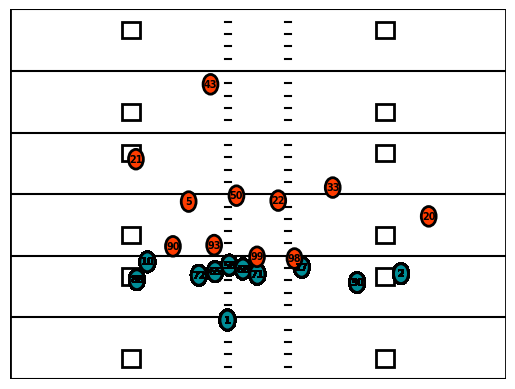

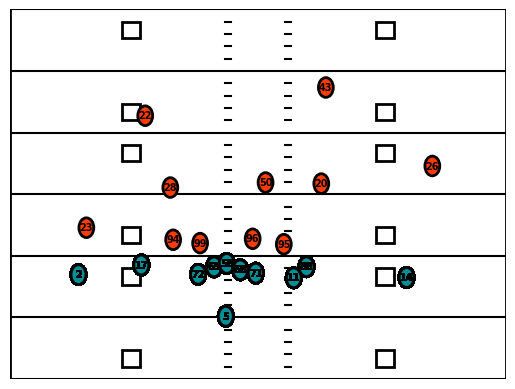

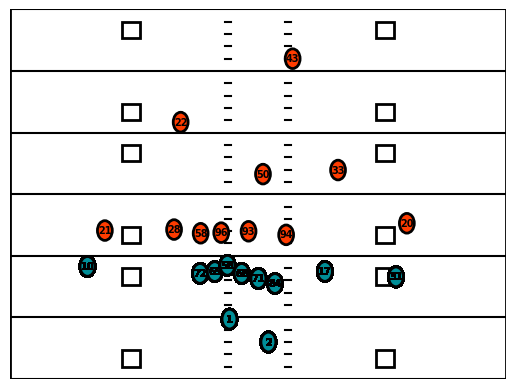

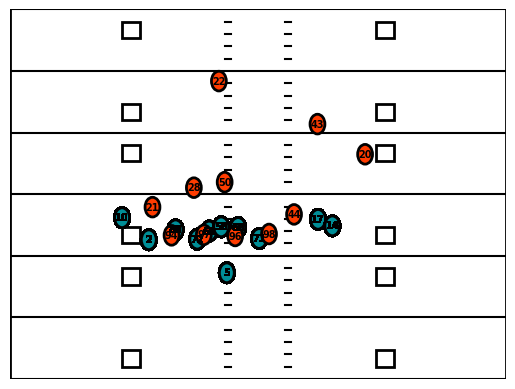

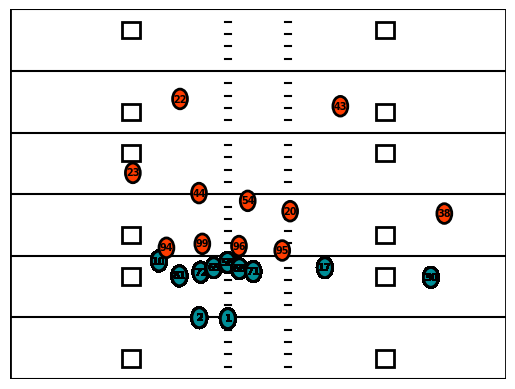

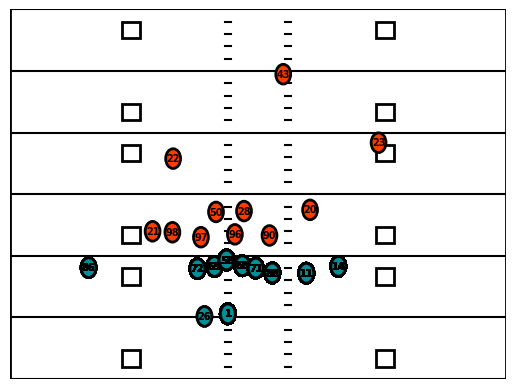

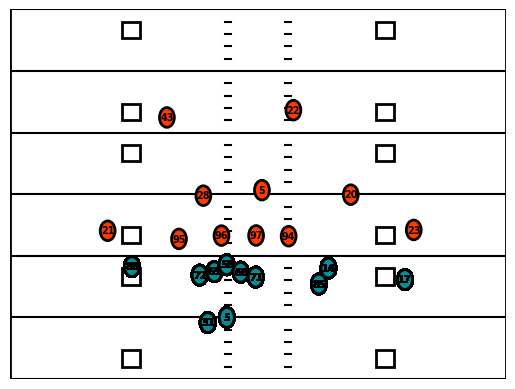

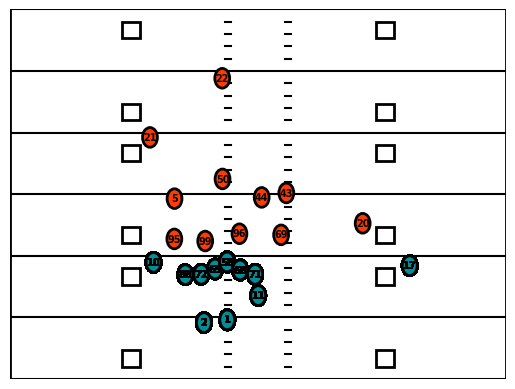

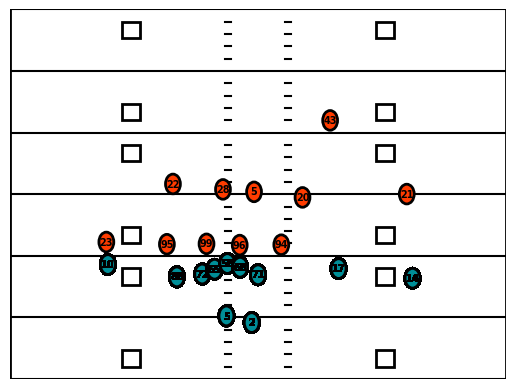

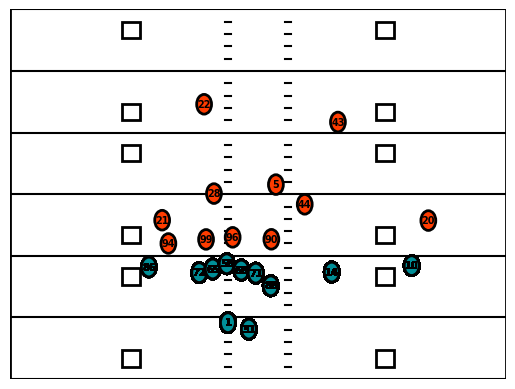

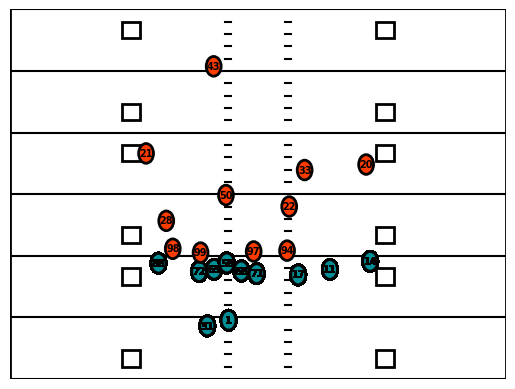

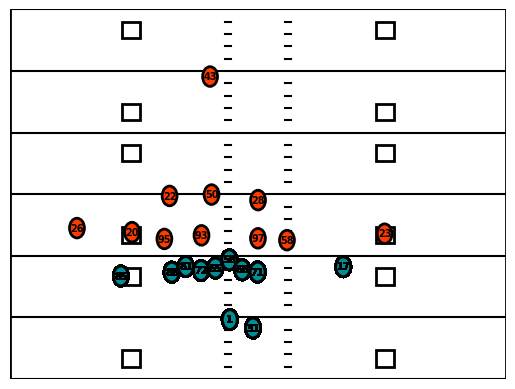

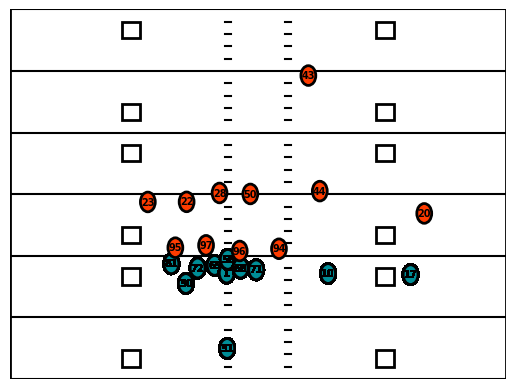

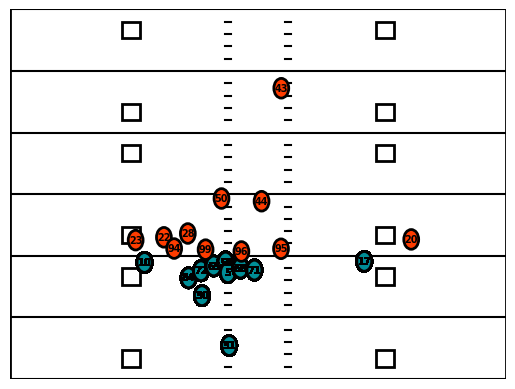

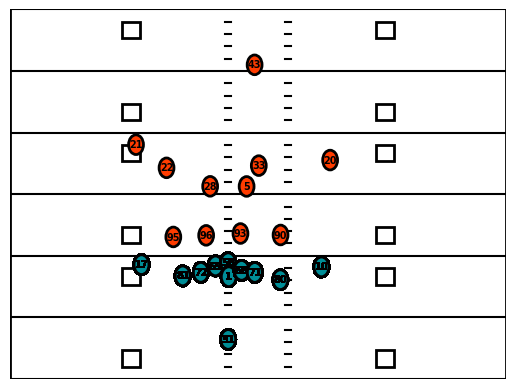

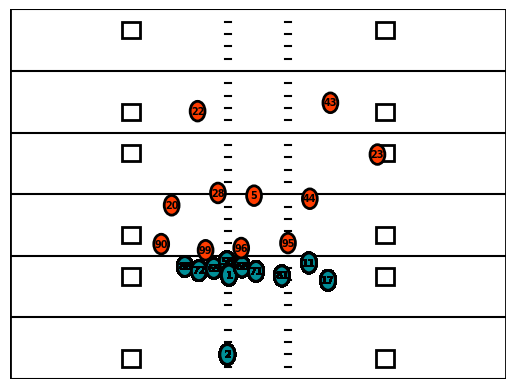

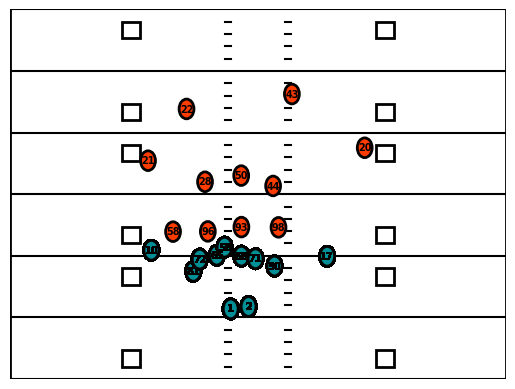

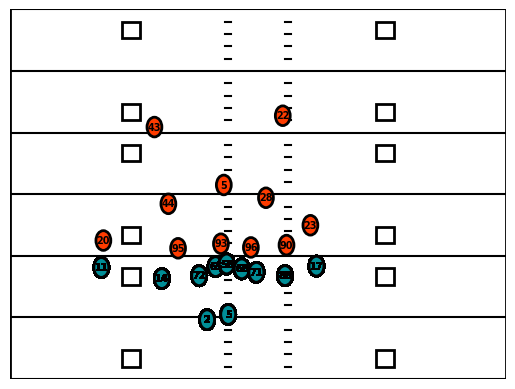

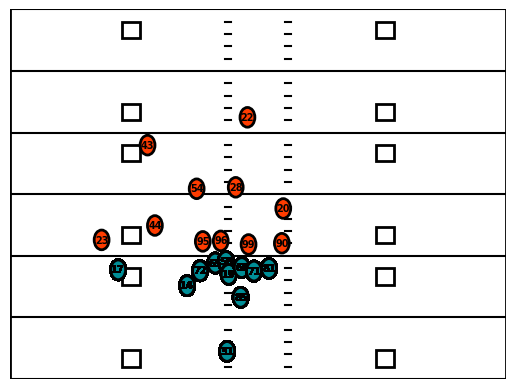

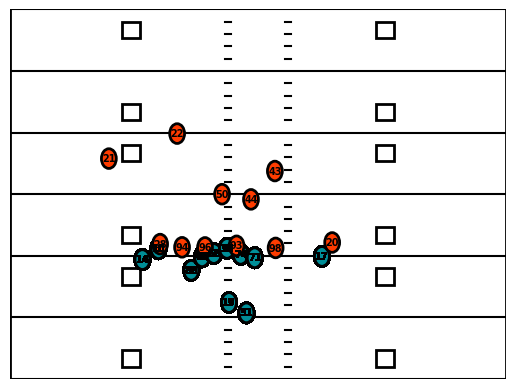

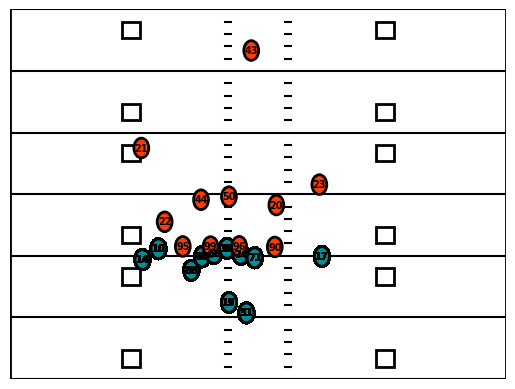

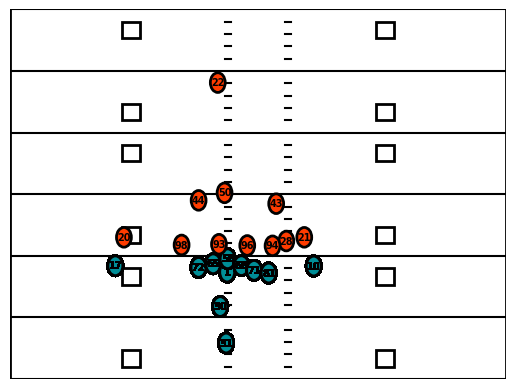

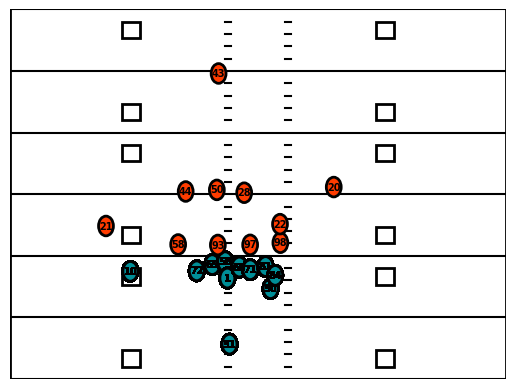

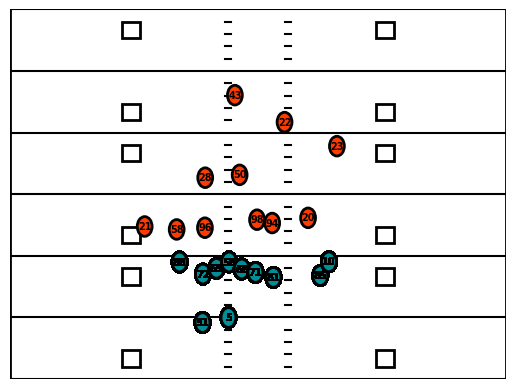

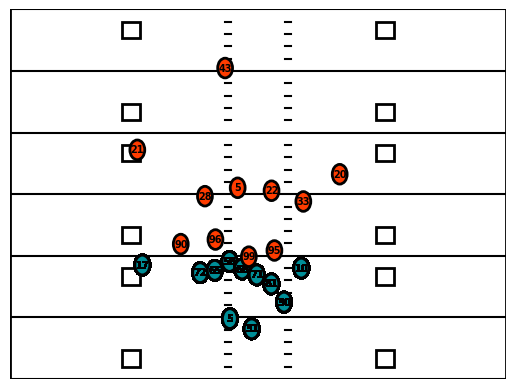

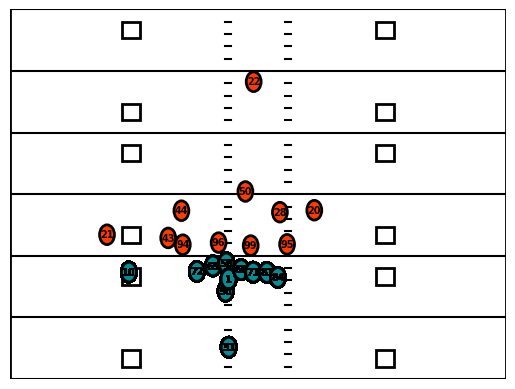

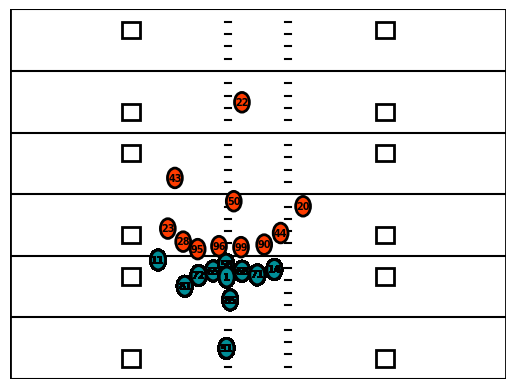

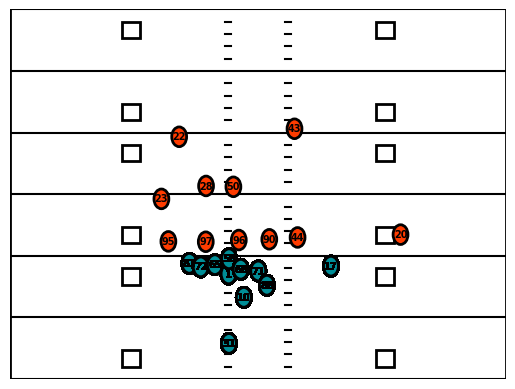

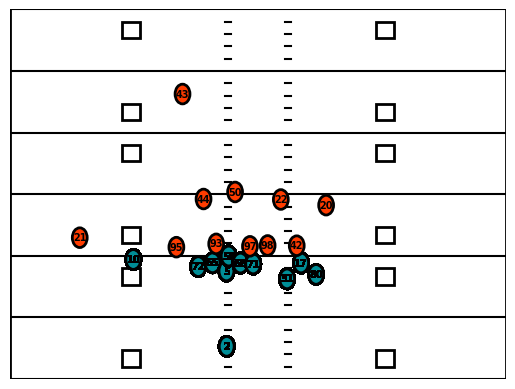

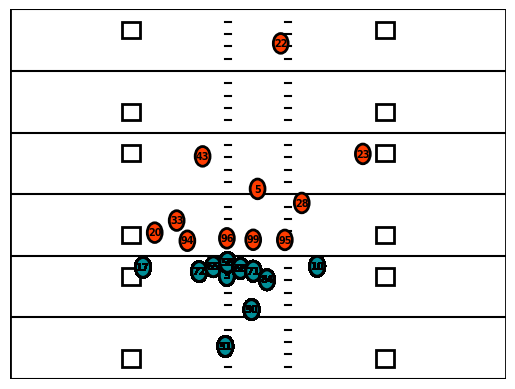

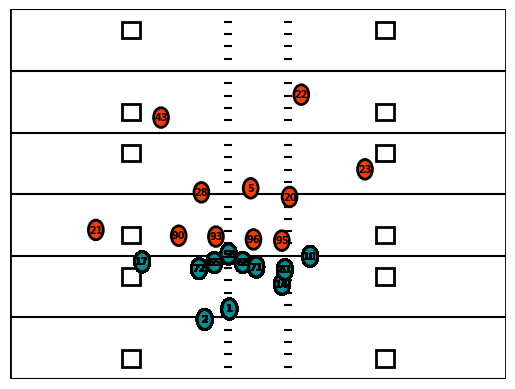

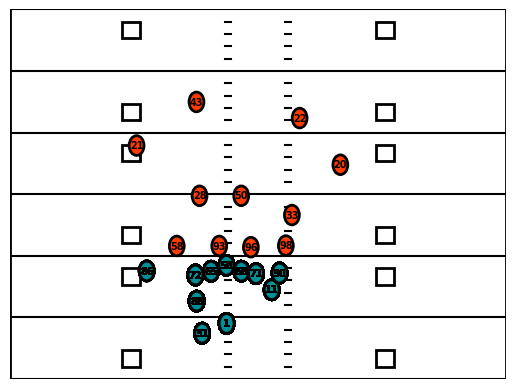

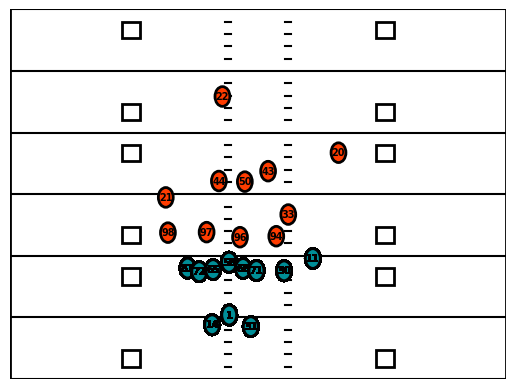

In [55]:
#5 best
var = 'Mean'
ofdf = pd.DataFrame(offensive_formations)
ofdf = ofdf.sort_values(by = 'Mean', ascending=False).reset_index(drop=True)
for hdx, h in enumerate(ofdf_mean['O_Label']):
    offensive_play = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdO'].drop_duplicates())[0]
    playlistD = list(predicted_plays.loc[(predicted_plays['O_Label'] == h)]['PlayIdD'].drop_duplicates())
    for idx, i in enumerate(playlistD):
        def_label = predicted_plays.loc[(predicted_plays['PlayIdD'] == i)]['D_Label'].iloc[0]
        snapo = predicted_plays.loc[(predicted_plays['PlayIdO'] == offensive_play) & (predicted_plays['PossessionTeam'] == offense) & (predicted_plays['IsOnOffense'] == True)].reset_index(drop=True)
        snapo = snapo.sort_values(by = 'Y').reset_index(drop=True)
        pos_pl = 0
        for jdx, j in enumerate(snapo['Position']):
            if (j in ['T', 'G', 'C']):
                if pos_pl == 0:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Terron Armstead')]['nflId'].iloc[0]
                elif pos_pl == 1:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Robert Jones')]['nflId'].iloc[0]
                elif pos_pl == 2:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Connor Williams')]['nflId'].iloc[0]
                elif pos_pl == 3:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Robert Hunt')]['nflId'].iloc[0]
                elif pos_pl == 4:
                    snapo.at[jdx, 'NflId'] = players1.loc[(players1['displayName'] == 'Brandon Shell')]['nflId'].iloc[0]
                pos_pl+=1
        snapo = pd.merge(snapo, player_number, how = 'left', on = 'NflId').reset_index(drop=True)
        snapd = predicted_plays.loc[(predicted_plays['PlayIdD'] == i) & (predicted_plays['DefensiveTeam'] == defense) & (predicted_plays['IsOnOffense'] == False)].reset_index(drop=True)
        snapd = pd.merge(snapd, player_number, how = 'left', left_on = ['PlayIdD', 'NflId'], right_on = ['PlayId', 'NflId']).reset_index(drop=True)
        snap = pd.concat([snapo, snapd]).reset_index(drop=True)
        snap = pd.merge(snap, player_space[['NflId', 'Space Factor Adj']], how = 'left', on = 'NflId').reset_index(drop=True)
        
        
        field_width = 53.33  # NFL field width
        field_length = 120  # View range: -20 to 20
        hashmark_to_sideline = 23.42  # NFL official hash mark distance from sideline
        hashmark_width = .67  # hashmark length
        number_to_sideline = 12  # NFL official hash mark distance from sideline
        number_width = 2  # hashmark length
    
        fig, ax = bdb.plt.subplots()
    
        overlay_image = ppdict[i][:, :, 3]
        overlay_image = np.rot90(overlay_image)
        overlay_image = np.flip(overlay_image, axis=1)
        
        custom_cmap = ListedColormap(["#311D00", "mediumseagreen", "#FC4C02"])
        x_min, x_max, y_min, y_max = -field_width/2, field_width/2, -field_length/2, field_length/2
        #ax.imshow(overlay_image, cmap=custom_cmap, extent=[x_min, x_max, y_min, y_max], zorder = 5)
    
        # Main field (excluding end zones)
        ax.add_patch(bdb.patches.Rectangle(
            (-field_width/2, -field_length/2), field_width, field_length,
            linewidth=2, edgecolor='black', facecolor='none', zorder=9))
        
        for idx, row in snap.iterrows():
            x_draw = row['X'] - (field_length / 2)# - 50
            y_draw = row['Y'] - (field_width / 2)
            #y_draw_d = 53.33 - row['Y'] - (field_width / 2)
            pos = row['Position']
            team = row['PossessionTeam']
            size = row['Space Factor Adj']
            jersey_number = int(row['JerseyNumber'])
            if team == offense:
                ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .8, facecolor='#008E97', edgecolor='black', lw=2)).set_zorder(10)
                ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=7, zorder=11, weight='bold')
            else:
                ax.add_patch(bdb.patches.Circle((y_draw, x_draw), .8, facecolor='#FF3C00', edgecolor='black', lw=2)).set_zorder(10)
                ax.text(y_draw, x_draw, jersey_number, color='black', ha='center', va='center', fontsize=7, zorder=11, weight='bold')

        for yard in range(int((-field_length/2)), int((field_length/2)), 1):
            linestyle = '-' #if yard % 10 == 0 else '--'
            y_position = yard
            if yard % 5 == 0:
                ax.plot([-field_width/2, field_width/2], [y_position, y_position], color='black', linestyle=linestyle, zorder=9)
            else:
                ax.plot([-field_width/2 + hashmark_to_sideline - hashmark_width/2, -field_width/2 + hashmark_to_sideline + hashmark_width/2], [y_position, y_position], color='black', linestyle=linestyle, zorder=9)
                ax.plot([field_width/2 - hashmark_to_sideline + hashmark_width/2, field_width/2 - hashmark_to_sideline - hashmark_width/2], [y_position, y_position], color='black', linestyle=linestyle, zorder=9)
    
            number_offset = number_width / 2  # Half the height of the number box
    
            if (yard % 10 == 0) & (yard != int(-field_length/2)) & (yard != int((field_length/2))):
                # Left numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='black', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (-field_width/2 + number_to_sideline, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='black', facecolor='None', label="End Zone", zorder=9))
                
                # Right numbers
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position + number_offset), number_width, number_width/1.5,
                    linewidth=2, edgecolor='black', facecolor='None', label="End Zone", zorder=9))
                ax.add_patch(bdb.patches.Rectangle(
                    (field_width/2 - number_to_sideline - number_width, y_position - number_offset - number_width/1.5), number_width, number_width/1.5,
                    linewidth=2, edgecolor='black', facecolor='None', label="End Zone", zorder=9))
    
        ax.set_xlim(-field_width/2, field_width/2)
        ax.set_ylim(-field_length/2, field_length/2)
        bdb.plt.gca().set_facecolor('green')
        bdb.plt.axis('off')
        #bdb.plt.title(str(i))
        bdb.plt.ylim(-10, 20) 
        bdb.plt.savefig(prefix + '/testfig/drawing/testfig-O' + str(h) + '-D' + str(def_label) + '-' + str(i)+  '.jpg', bbox_inches="tight", pad_inches = 0, dpi = 600)
        bdb.plt.show()